In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import time
import sklearn
from random import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from tabulate import tabulate
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier

evaluate={'Acc':"Accuracy", 'b_Acc':"Balanced Accuracy", 'F1':"F1 Score", 'kap':"Kappa", 'ROC':"Roc"}

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [4]:
def GA(train,test,cols,gen_number=25,outputcsv="GA_output.csv"):
    #defining various steps required for the genetic algorithm
    # GA adapted from https://datascienceplus.com/genetic-algorithm-in-machine-learning-using-python/
    def initilization_of_population(size,n_feat):
        population = []
        for i in range(size):
            chromosome = np.ones(n_feat,dtype=np.bool)
            chromosome[:int(0.3*n_feat)]=False
            np.random.shuffle(chromosome)
            population.append(chromosome)
        return population

    def fitness_score(population):
        scores = []
        for chromosome in population:
            logmodel.fit(X_train.iloc[:,chromosome],y_train)
            predictions = logmodel.predict(X_test.iloc[:,chromosome])
            scores.append(sklearn.metrics.f1_score(y_test,predictions,average= "macro"))
        scores, population = np.array(scores), np.array(population) 
        inds = np.argsort(scores)
        return list(scores[inds][::-1]), list(population[inds,:][::-1])

    def selection(pop_after_fit,n_parents):
        population_nextgen = []
        for i in range(n_parents):
            population_nextgen.append(pop_after_fit[i])
        return population_nextgen

    def crossover(pop_after_sel):
        population_nextgen=pop_after_sel
        for i in range(len(pop_after_sel)):
            child=pop_after_sel[i]
            child[3:7]=pop_after_sel[(i+1)%len(pop_after_sel)][3:7]
            population_nextgen.append(child)
        return population_nextgen

    def mutation(pop_after_cross,mutation_rate):
        population_nextgen = []
        for i in range(0,len(pop_after_cross)):
            chromosome = pop_after_cross[i]
            for j in range(len(chromosome)):
                if random.random() < mutation_rate:
                    chromosome[j]= not chromosome[j]
            population_nextgen.append(chromosome)
        #print(population_nextgen)
        return population_nextgen

    def generations(size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                       X_test, y_train, y_test):

        best_chromo= []
        best_score= []
        population_nextgen=initilization_of_population(size,n_feat)
        for i in range(n_gen):
            second=time.time()
            scores, pop_after_fit = fitness_score(population_nextgen)
            #print(scores[:2])
            zaman=time.time()-second

            ths.write(f"{np.mean(scores)},{np.mean(scores)},{zaman}\n")
            


            pop_after_sel = selection(pop_after_fit,n_parents)
            pop_after_cross = crossover(pop_after_sel)
            population_nextgen = mutation(pop_after_cross,mutation_rate)
            best_chromo.append(pop_after_fit[0])
            best_score.append(scores[0])
        return best_chromo,best_score
    
    



    df = pd.read_csv(train,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_train =df[df.columns[0:-1]]
    #X_train=np.array(X_train)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_train=df[df.columns[-1]].cat.codes  
    df = pd.read_csv(test,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_test =df[df.columns[0:-1]]
    #X_test=np.array(X_test)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_test=df[df.columns[-1]].cat.codes  

    
    ths = open(f"./{outputcsv}", "w")
    ths.write("MEAN,STD,TIME\n")
    logmodel=DecisionTreeClassifier()
    #print ('%-30s %-30s %-30s' % ("MEAN","STD","TIME"))
    chromo,score=generations(size=200,n_feat=X_train.shape[1],n_parents=120,mutation_rate=0.005,
                         n_gen=gen_number,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)
    #logmodel.fit(X_train.iloc[:,chromo[-1]],y_train)
    #predictions = logmodel.predict(X_test.iloc[:,chromo[-1]])
    #print("F1 Score score after genetic algorithm is= "+str(sklearn.metrics.f1_score(y_test,predictions,average= "macro")))
    ths.close()
    sonuç=[]
    for k,j in enumerate(chromo):
        temp=X_train.iloc[:,j]
        temp=list(temp.columns)
        temp.append("Label")
        sonuç.append(temp)
    
    np.save(outputcsv.replace("csv","npy"), sonuç)
    gf = pd.read_csv(outputcsv)
    gf=gf["MEAN"].values
    gf=np.argmax(gf) 
    return sonuç[gf],gf

In [5]:
def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

In [6]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
    return files_add

In [7]:
ml_list={"LR":{"SYN":LogisticRegression(C=0.331891,penalty="l1",solver="liblinear" ),
               "HTTP":LogisticRegression(C=79.1689 ,penalty="l2",solver="lbfgs" ),
               "ACK":LogisticRegression(C=12.8184 ,penalty="l1",solver="liblinear" ),    
               "UDP":LogisticRegression(C=0.275089,penalty="none",solver="lbfgs" ),    
               "ARP":LogisticRegression(C=13.4981 ,penalty="l1",solver="liblinear" ),
               "SP":LogisticRegression(C=1.94584,penalty="none",solver="lbfgs" ),    
               "BF":LogisticRegression(C=2.87076,penalty="l1",solver="liblinear" ),    
               "OS":LogisticRegression(C= 0.0564484,penalty="l2",solver="liblinear" ),
               "SCHD":LogisticRegression(C=1.52913,penalty="none",solver="lbfgs" ),    
               "MHDis":LogisticRegression(C=0.000436482,penalty="none",solver="lbfgs" )    
              },   
         
"DT":{"SYN":DecisionTreeClassifier(criterion="entropy",max_depth=9,max_features=25,min_samples_split=2 ),
"HTTP":DecisionTreeClassifier(criterion="gini",max_depth=5,max_features=11,min_samples_split=4 ),                      
"ACK":DecisionTreeClassifier(criterion="entropy",max_depth=4,max_features=3,min_samples_split=4),            
"UDP":DecisionTreeClassifier(criterion="entropy",max_depth=5,max_features=18,min_samples_split=4 ),            
"ARP":DecisionTreeClassifier(criterion="entropy",max_depth=12,max_features=60,min_samples_split=2 ),            
"SP":DecisionTreeClassifier(criterion="entropy",max_depth=5,max_features=10,min_samples_split=3 ),            
"BF":DecisionTreeClassifier(criterion="entropy",max_depth=4,max_features=19,min_samples_split=4 ),              
"OS":DecisionTreeClassifier(criterion="entropy",max_depth=2,max_features=28,min_samples_split=3 ),            
"SCHD":DecisionTreeClassifier(criterion="gini",max_depth=2,max_features=18,min_samples_split=4 ),             
"MHDis":DecisionTreeClassifier(criterion="entropy",max_depth=8,max_features=18,min_samples_split=9 )},
         
       
    
"RF":{"SYN":RandomForestClassifier(bootstrap=False,criterion="entropy",max_depth=7,max_features=8,min_samples_split=3,n_estimators=35),
"HTTP":RandomForestClassifier(bootstrap=False,criterion="gini",max_depth=10,max_features=5,min_samples_split=6,n_estimators=114),                      
"ACK":RandomForestClassifier(bootstrap=True,criterion="entropy",max_depth=7,max_features=8,min_samples_split=5,n_estimators=155 ),            
"UDP":RandomForestClassifier(bootstrap=False,criterion="entropy",max_depth=4,max_features=10,min_samples_split=8,n_estimators=192 ),            
"ARP":RandomForestClassifier(bootstrap=True,criterion="entropy",max_depth=20,max_features=3,min_samples_split=2,n_estimators=132),            
"SP":RandomForestClassifier(bootstrap=False,criterion="entropy",max_depth=7,max_features=3,min_samples_split=4,n_estimators=66),            
"BF":RandomForestClassifier(bootstrap=True,criterion="entropy",max_depth=8,max_features=7,min_samples_split=9,n_estimators=192 ),      
"OS":RandomForestClassifier(bootstrap=True,criterion="entropy",max_depth=5,max_features=7,min_samples_split=8,n_estimators=29),            
"SCHD":RandomForestClassifier(bootstrap=False,criterion="entropy",max_depth=7,max_features=6,min_samples_split=9,n_estimators=104),             
"MHDis":RandomForestClassifier(bootstrap=True,criterion="entropy",max_depth=7,max_features=6,min_samples_split=5,n_estimators=73)}
,
    

    
"KNN":{"SYN":KNeighborsClassifier(algorithm="brute",leaf_size=43,n_neighbors=3,weights="distance"),
"HTTP":KNeighborsClassifier(algorithm="auto",leaf_size=31,n_neighbors=3,weights="distance"),                     
"ACK":KNeighborsClassifier(algorithm="ball_tree",leaf_size=2,n_neighbors=3,weights="distance"),        
"UDP":KNeighborsClassifier(algorithm="ball_tree",leaf_size=1,n_neighbors=2,weights="uniform"),       
"ARP":KNeighborsClassifier(algorithm="kd_tree",leaf_size=22,n_neighbors=5,weights="distance"),         
"SP":KNeighborsClassifier(algorithm="auto",leaf_size=2,n_neighbors=1,weights="uniform"),         
"BF":KNeighborsClassifier(algorithm="kd_tree",leaf_size=2,n_neighbors=1,weights="distance"),    
"OS":KNeighborsClassifier(algorithm="kd_tree",leaf_size=38,n_neighbors=1,weights="distance"),         
"SCHD":KNeighborsClassifier(algorithm="kd_tree",leaf_size=11,n_neighbors=2,weights="uniform"),        
"MHDis":KNeighborsClassifier(algorithm="ball_tree",leaf_size=2,n_neighbors=1,weights="distance")}
,


         

         
#"SVM":{"SYN":SVC(gamma=1,C=1),
#"HTTP":SVC(gamma=0.001,C=10),                  
#"ACK":SVC(gamma=0.01,C=10),
#"UDP":SVC(gamma=1,C=0.1),   
#"ARP":SVC(gamma=1,C=10),       
#"SP":SVC(gamma=0.01 ,C=10),      
#"BF":SVC(gamma=0.01,C=10),  
#"OS":SVC(gamma=0.01 ,C=10),
#"SCHD":SVC(gamma=0.1,C=10),     
#"MHDis":SVC(gamma=0.1,C=1)},
       

         
#"MLP":{"SYN":MLPClassifier(solver= 'lbfgs', learning_rate= 'constant', hidden_layer_sizes= (457,), alpha= 0.0001, activation='tanh'),
#"HTTP":MLPClassifier(solver= 'adam', learning_rate= 'constant', hidden_layer_sizes= (1325, 1730),  alpha= 0.01, activation='relu'),             
#"ACK":MLPClassifier(solver= 'adam', learning_rate= 'constant', hidden_layer_sizes= (1747, 250),  alpha= 0.01, activation='relu'),
#"UDP":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes= (1573,),  alpha= 0.0001, activation='relu'),
#"ARP":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes= (685, 263),  alpha= 0.01, activation='relu'),    
#"SP":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes=  (1992,),  alpha= 0.001, activation='relu'), 
#"BF":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes= (879,), alpha= 0.001, activation='relu'),
#"OS":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes= (455,), alpha= 0.1, activation='tanh'),
#"SCHD":MLPClassifier(solver= 'lbfgs', learning_rate= 'adaptive', hidden_layer_sizes= (101,), alpha= 0.01, activation='tanh'),
#"MHDis":MLPClassifier(solver= 'lbfgs', learning_rate= 'constant', hidden_layer_sizes= (1024,), alpha= 0.001, activation='tanh')},
         
         
         
         
         
         
"NB":{"SYN":GaussianNB(var_smoothing=1.23285e-09),
"HTTP":GaussianNB(var_smoothing=1e-09 ),                  
"ACK":GaussianNB(var_smoothing= 0.432876),
"UDP":GaussianNB(var_smoothing=1.23285e-09),  
"ARP":GaussianNB(var_smoothing=1e-09),    
"SP":GaussianNB(var_smoothing=1e-09 ),      
"BF":GaussianNB(var_smoothing=1e-07),  
"OS":GaussianNB(var_smoothing=1.51991e-09),
"SCHD":GaussianNB(var_smoothing=1e-09),  
"MHDis":GaussianNB(var_smoothing=1e-09)}}



In [8]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [9]:
folder("results")
folder("pdfs")
folder("results/fin")
folder("models")


## Calculation of evaluations

In [10]:
def score(train_time,test_time,predict,y_test,class_based_results,repeat,cv,dname,ml,sw):
    train_time=train_time[0]
    test_time=test_time[0]
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=0
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,sw,repeat,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return class_based_results,line

In [11]:
def ML_CV(loop1,loop2,output_csv1,cols,dname,sw):
    fold=5
    repetition=2
    for ii in ml_list:
        output_csv=output_csv1.replace("ML",ii)
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        max_f1=0
        for i in range(repetition):

            rnd = random()
            
            kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            ##df = df.reset_index(drop=True)
            df=df.fillna(0)

            #del df["MAC"] # if dataset has MAC colomn please uncomment this line
            X =df[df.columns[0:-1]]
            X=np.array(X)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y=df[df.columns[-1]].cat.codes  
            X.shape
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]  



                #dname=loop1  [6:-13]  
                results_y=[]
                cv+=1
                results_y.append(y_test)


                precision=[]
                recall=[]
                f1=[]
                accuracy=[]
                train_time=[]
                test_time=[]
                total_time=[]
                kappa=[]
                accuracy_b=[]

                    #machine learning algorithm is applied in this section
                clf = ml_list[ii][dname]#choose algorithm from ml_list dictionary
                second=time.time()
                clf.fit(X_train, y_train)
                train_time.append(float((time.time()-second)) )
                second=time.time()
                predict =clf.predict(X_test)
                test_time.append(float((time.time()-second)) )

                altime=0
                class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
                lines.append(line)
                df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
                if cm.empty:
                    cm =df_cm
                else:
                    cm = cm.add(df_cm, fill_value=0)

                if line[9]>max_f1:
                    max_f1=line[9]
                    pickle.dump(clf, open(f'./models/{ii}_{dname}_{sw}_model.pkl', 'wb'))

        
        class_based_results=class_based_results/(repetition*fold)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","class_based_results.csv"))
        if True:
            cm=cm//(repetition*fold)
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"   
            plt.figure(figsize = (5,3.5))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             


In [12]:
def ML(loop1,loop2,output_csv1,cols,dname,sw):
    fold=1
    repetition=10
    for ii in ml_list:
        output_csv=output_csv1.replace("ML",ii)
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        max_f1=0
        for i in range(repetition):

            #rnd = random()
            
            #kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  


            df = pd.read_csv(loop2,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes  




            #dname=loop1  [6:-13]  
            results_y=[]
            cv+=1
            results_y.append(y_test)


            precision=[]
            recall=[]
            f1=[]
            accuracy=[]
            train_time=[]
            test_time=[]
            total_time=[]
            kappa=[]
            accuracy_b=[]

                #machine learning algorithm is applied in this section
            clf = ml_list[ii][dname]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time.append(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time.append(float((time.time()-second)) )

            altime=0
            class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
            lines.append(line)
            df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
            if cm.empty:
                cm =df_cm
            else:
                cm = cm.add(df_cm, fill_value=0)

            if line[9]>max_f1:
                max_f1=line[9]
                pickle.dump(clf, open(f'./models/{ii}_{dname}_{sw}_model.pkl', 'wb'))
                
        
        class_based_results=class_based_results/(repetition*fold)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","class_based_results.csv"))
        if True:
            cm=cm//(repetition*fold)
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"   
            plt.figure(figsize = (5,3.5))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             


# GA output

In [13]:
import json
with open('GA_output_ET.json', 'r') as fp:
    feature_list = json.load(fp)

# CV

In [14]:
file_list={'./INPUT/SW/DoS-SYN-1.csv':"SYN",
'./INPUT/SW/MB-HTTP-4.csv':"HTTP",
'./INPUT/SW/MB-ACK-4.csv':"ACK",
'./INPUT/SW/MB-UDP-4.csv':"UDP",
'./INPUT/SW/MitM-ARP-6.csv':"ARP",
'./INPUT/SW/H-Scan-Port-3.csv':"SP",
'./INPUT/SW/MB-BF-5.csv':"BF",
'./INPUT/SW/Scan-OS-3.csv':"OS",  
'./INPUT/SW/Scan-HDis-3.csv':"SCHD",
'./INPUT/SW/MB-HDis-3.csv':"MHDis"}

./INPUT/SW/DoS-SYN-1.csv
['ts', 'IP_flags', 'IP_DF', 'TCP_SYN', 'TCP_ACK', 'sport_class', 'dst_IP_diversity', 'IP_add_count', 'pck_size_std_WE', 'pck_size_sum_of_EW', 'ts_mean_WE', 'TCP_window_std_WE', 'pck_size_mean_2', 'TCP_window_mean_2', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_ACK_ratio', 'TCP_SYN_SR', 'TCP_ACK_SR', 'pck_size_mean_6', 'ts_mean_6', 'TCP_window_mean_6', 'ts_mean_9', 'ts_std_9', 'TCP_window_mean_9', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  LR    1        1       1      1      1      1      1        0.323     0.001
 1  SYN           0    2     0  LR    1        1       0.999  1      1      0.999  1        0.228     0
 2  SYN           0    3     0  LR    1        1       0.999  1      1      0.999  1        0.172     0.063
 3  SYN           0   

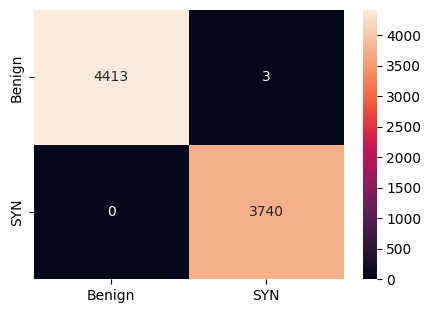





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  DT    1        1       1      1      1      0.999  1        0.278     0
 1  SYN           0    2     0  DT    1        1       1      1      1      1      1        0.191     0
 2  SYN           0    3     0  DT    0.999    0.999   0.999  0.999  0.999  0.999  0.999    0.167     0
 3  SYN           0    4     0  DT    1        1       1      1      1      1      1        0.063     0
 4  SYN           0    5     0  DT    1        1       1      1      1      1      1        0.264     0
 5  SYN           0    1     1  DT    1        1       0.999  1      1      0.999  1        0.204     0
 6  SYN           0    2     1  DT    1        1       1      1      1      1      1        0.263     0
 7  SYN           0    3     1  DT    0.999    0.999

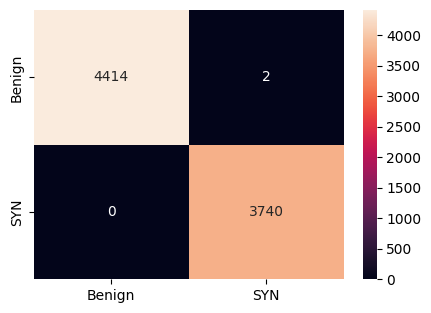





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SYN           0    1     0  RF        1        1   0.999      1     1  0.999      1    3.942     0.047
 1  SYN           0    2     0  RF        1        1   1          1     1  0.999      1    4.233     0.079
 2  SYN           0    3     0  RF        1        1   1          1     1  0.999      1    4.182     0.048
 3  SYN           0    4     0  RF        1        1   1          1     1  1          1    3.591     0.267
 4  SYN           0    5     0  RF        1        1   1          1     1  0.999      1    4.165     0.09
 5  SYN           0    1     1  RF        1        1   1          1     1  0.999      1    3.715     0.469
 6  SYN           0    2     1  RF        1        1   1          1     1  0.999      1    2.259     0.043
 7  SYN           0    3     1  RF

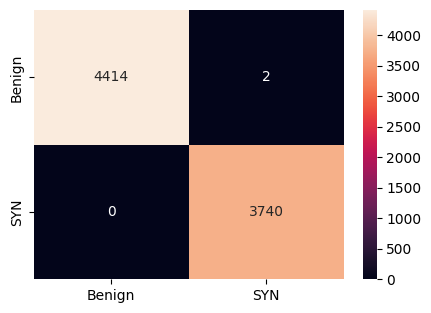





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  KNN   1        1       0.999  1      1      0.999  1        0.016    10.448
 1  SYN           0    2     0  KNN   0.999    0.999   0.999  0.999  0.999  0.998  0.999    0        11.729
 2  SYN           0    3     0  KNN   1        1       0.999  1      1      0.999  1        0        12.158
 3  SYN           0    4     0  KNN   0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.003    11.538
 4  SYN           0    5     0  KNN   1        1       0.999  1      1      0.999  1        0.009    12.02
 5  SYN           0    1     1  KNN   1        1       0.999  1      1      0.999  1        0        10.827
 6  SYN           0    2     1  KNN   1        1       1      1      1      1      1        0.004    10.023
 7  SYN           0    3 

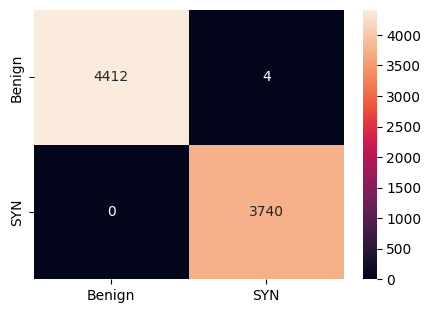





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  NB    0.991    0.991   0.991  0.991  0.991  0.983  0.991    0.024     0.08
 1  SYN           0    2     0  NB    0.991    0.991   0.991  0.991  0.991  0.983  0.991    0.055     0.005
 2  SYN           0    3     0  NB    0.991    0.991   0.991  0.991  0.991  0.982  0.991    0.221     0.006
 3  SYN           0    4     0  NB    0.992    0.992   0.992  0.992  0.992  0.984  0.992    0.124     0
 4  SYN           0    5     0  NB    0.991    0.991   0.991  0.991  0.991  0.983  0.991    0.064     0.229
 5  SYN           0    1     1  NB    0.992    0.992   0.992  0.992  0.992  0.984  0.992    0.063     0
 6  SYN           0    2     1  NB    0.99     0.99    0.991  0.99   0.99   0.981  0.99     0.191     0.013
 7  SYN           0    3     1  N

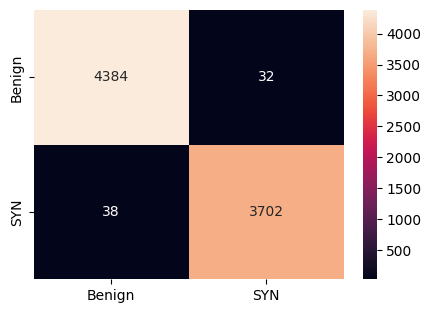





./INPUT/SW/MB-HTTP-4.csv
['TCP_flags', 'dport_class', 'pck_size_sum_of_EW', 'ts_std_WE', 'ts_sum_of_EW', 'payload_bytes_sum_of_EW', 'entropy_mean_WE', 'TCP_window_mean_2', 'sport_sum', 'TCP_ACK_ratio', 'sum', 'TCP_PSH_SR', 'ts_std_6', 'entropy_mean_6', 'TCP_window_mean_9', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  LR    0.999    0.996   0.995  0.996  0.996  0.991  0.996    4.446     0
 1  HTTP          0    2     0  LR    1        0.999   0.998  0.999  0.998  0.997  0.999    4.191     0
 2  HTTP          0    3     0  LR    0.999    0.998   0.985  0.998  0.991  0.982  0.998    4.93      0
 3  HTTP          0    4     0  LR    1        0.999   1      0.999  1      0.999  0.999    5.064     0
 4  HTTP          0    5     0  LR    0.999    0.996   0.995  0.996  0.996  0.991

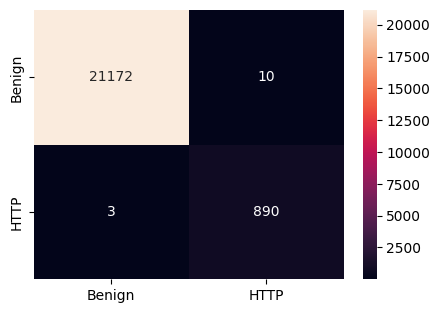





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  DT        1    1       1      1      1      1      1        0.796     0
 1  HTTP          0    2     0  DT        1    0.995   1      0.995  0.997  0.995  0.995    1.925     0.005
 2  HTTP          0    3     0  DT        1    0.996   1      0.996  0.998  0.996  0.996    1.515     0
 3  HTTP          0    4     0  DT        1    1       1      1      1      1      1        1.01      0.01
 4  HTTP          0    5     0  DT        1    0.998   1      0.998  0.999  0.998  0.998    1.25      0.094
 5  HTTP          0    1     1  DT        1    0.999   1      0.999  1      0.999  0.999    1.14      0
 6  HTTP          0    2     1  DT        1    0.998   0.999  0.998  0.999  0.997  0.998    1.775     0
 7  HTTP          0    3     1  DT       

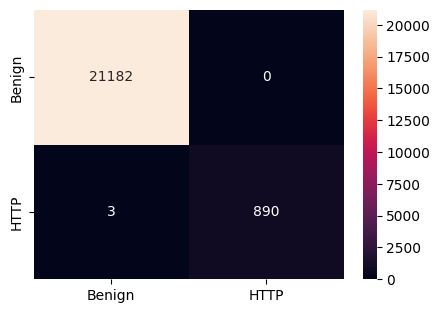





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  RF        1    0.999       1  0.999  0.999  0.999  0.999   67.755     1.226
 1  HTTP          0    2     0  RF        1    1           1  1      1      1      1       72.201     1.201
 2  HTTP          0    3     0  RF        1    1           1  1      1      1      1       34.505     0.196
 3  HTTP          0    4     0  RF        1    1           1  1      1      1      1       16.884     0.356
 4  HTTP          0    5     0  RF        1    1           1  1      1      1      1       15.83      0.194
 5  HTTP          0    1     1  RF        1    1           1  1      1      1      1       15.695     0.214
 6  HTTP          0    2     1  RF        1    1           1  1      1      1      1       15.735     0.22
 7  HTTP          0    3 

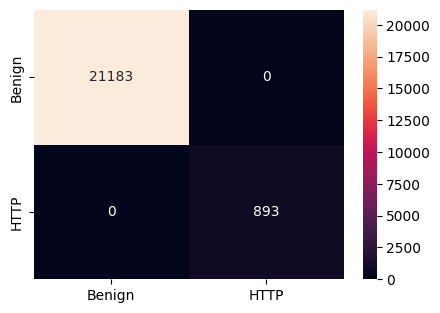





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  KNN       1    0.998   0.999  0.998  0.999  0.998  0.998    0.338     0.156
 1  HTTP          0    2     0  KNN       1    0.998   1      0.998  0.999  0.998  0.998    0.325     0.394
 2  HTTP          0    3     0  KNN       1    1       0.999  1      0.999  0.999  1        0.309     0.239
 3  HTTP          0    4     0  KNN       1    0.998   0.998  0.998  0.998  0.996  0.998    0.47      0.21
 4  HTTP          0    5     0  KNN       1    0.998   0.999  0.998  0.998  0.997  0.998    0.305     0.235
 5  HTTP          0    1     1  KNN       1    0.998   0.997  0.998  0.997  0.995  0.998    0.3       0.241
 6  HTTP          0    2     1  KNN       1    0.998   0.997  0.998  0.998  0.995  0.998    0.346     0.219
 7  HTTP          0    3 

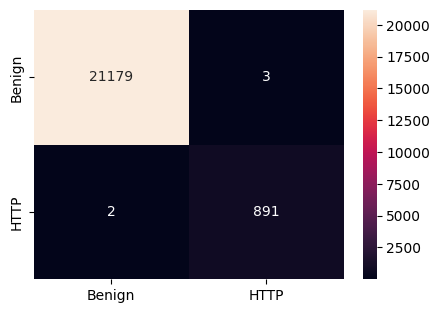





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  NB    0.852    0.923   0.611  0.923  0.64   0.316  0.923    0.047     0.022
 1  HTTP          0    2     0  NB    0.847    0.92    0.604  0.92   0.629  0.298  0.92     0.031     0.016
 2  HTTP          0    3     0  NB    0.851    0.922   0.607  0.922  0.634  0.305  0.922    0.031     0.016
 3  HTTP          0    4     0  NB    0.85     0.922   0.605  0.922  0.632  0.302  0.922    0.047     0
 4  HTTP          0    5     0  NB    0.85     0.922   0.605  0.922  0.631  0.3    0.922    0.124     0
 5  HTTP          0    1     1  NB    0.852    0.923   0.607  0.923  0.635  0.308  0.923    0.047     0
 6  HTTP          0    2     1  NB    0.848    0.921   0.606  0.921  0.631  0.302  0.921    0.047     0
 7  HTTP          0    3     1  NB    0.

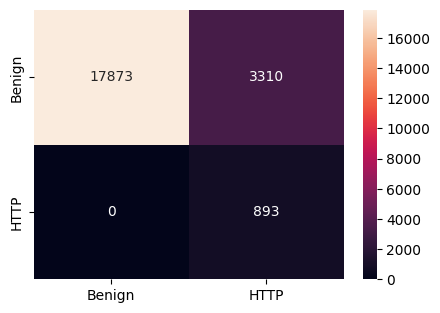





./INPUT/SW/MB-ACK-4.csv
['ts_std_WE', 'TCP_window_sum_of_EW', 'payload_bytes_mean_WE', 'payload_bytes_sum_of_EW', 'sport_sum', 'TCP_ACK_ratio', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  LR    1        0.997       1  0.997  0.998  0.997  0.997  100.123     0.005
 1  ACK           0    2     0  LR    0.999    0.996       1  0.996  0.998  0.995  0.996   96.278     0
 2  ACK           0    3     0  LR    1        0.999       1  0.999  0.999  0.999  0.999   98.668     0
 3  ACK           0    4     0  LR    1        0.998       1  0.998  0.999  0.998  0.998   92.156     0
 4  ACK           0    5     0  LR    1        0.998       1  0.998  0.999  0.998  0.998  104.018     0
 5  ACK           0    1     1  LR    0.999    0.996       1  0.996  0.998  0.996  0.996  115.774     0

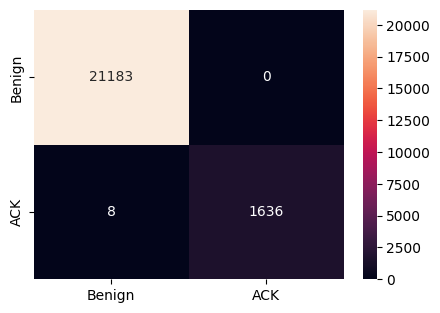





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  DT        1    1       1      1      1      1      1        0.07      0
 1  ACK           0    2     0  DT        1    1       1      1      1      1      1        0.094     0
 2  ACK           0    3     0  DT        1    0.999   1      0.999  1      0.999  0.999    0.047     0.016
 3  ACK           0    4     0  DT        1    0.999   0.999  0.999  0.999  0.999  0.999    0.283     0
 4  ACK           0    5     0  DT        1    1       1      1      1      1      1        0.047     0
 5  ACK           0    1     1  DT        1    1       1      1      1      1      1        0.09      0
 6  ACK           0    2     1  DT        1    0.999   1      0.999  1      0.999  0.999    0.063     0
 7  ACK           0    3     1  DT        1    0

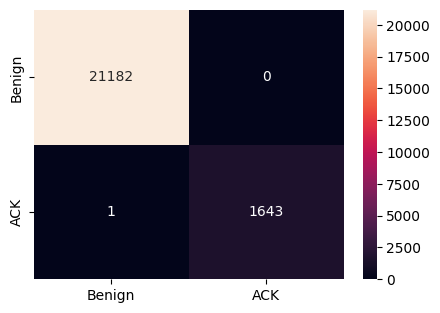





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  RF        1    1           1  1      1      1      1       24.642     0.46
 1  ACK           0    2     0  RF        1    1           1  1      1      1      1       23.267     0.299
 2  ACK           0    3     0  RF        1    0.998       1  0.998  0.999  0.998  0.998   24.464     0.122
 3  ACK           0    4     0  RF        1    1           1  1      1      1      1       23.372     0.264
 4  ACK           0    5     0  RF        1    0.999       1  0.999  1      0.999  0.999   25.581     0.22
 5  ACK           0    1     1  RF        1    0.999       1  0.999  1      0.999  0.999   24.461     0.236
 6  ACK           0    2     1  RF        1    1           1  1      1      1      1       23.186     0.267
 7  ACK           0    3  

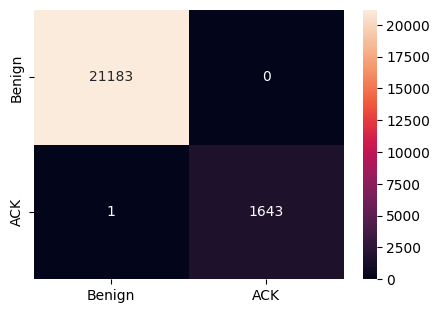





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  KNN   0.957    0.835   0.843  0.835  0.839  0.679  0.835    0.173     1.258
 1  ACK           0    2     0  KNN   0.955    0.826   0.829  0.826  0.828  0.655  0.826    0.299     1.4
 2  ACK           0    3     0  KNN   0.956    0.832   0.84   0.832  0.836  0.672  0.832    0.126     0.597
 3  ACK           0    4     0  KNN   0.956    0.823   0.842  0.823  0.832  0.663  0.823    0.141     0.677
 4  ACK           0    5     0  KNN   0.958    0.845   0.841  0.845  0.843  0.686  0.845    0.149     0.566
 5  ACK           0    1     1  KNN   0.957    0.841   0.841  0.841  0.841  0.682  0.841    0.119     0.598
 6  ACK           0    2     1  KNN   0.953    0.829   0.82   0.829  0.824  0.648  0.829    0.126     0.627
 7  ACK           0    3  

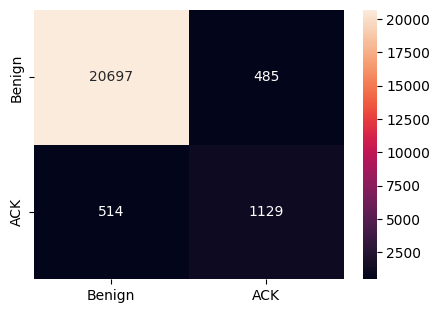





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  NB    0.976    0.844   0.988  0.844  0.902  0.804  0.844    0.141     0.016
 1  ACK           0    2     0  NB    0.977    0.841   0.988  0.841  0.899  0.798  0.841    0.11      0
 2  ACK           0    3     0  NB    0.976    0.831   0.987  0.831  0.892  0.784  0.831    0.141     0.016
 3  ACK           0    4     0  NB    0.977    0.828   0.988  0.828  0.89   0.78   0.828    0.142     0
 4  ACK           0    5     0  NB    0.976    0.832   0.987  0.832  0.893  0.786  0.832    0.034     0.076
 5  ACK           0    1     1  NB    0.976    0.838   0.987  0.838  0.897  0.794  0.838    0.041     0.006
 6  ACK           0    2     1  NB    0.976    0.839   0.988  0.839  0.897  0.795  0.839    0.016     0.016
 7  ACK           0    3     1  

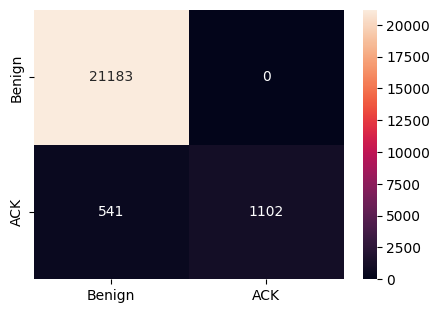





./INPUT/SW/MB-UDP-4.csv
['IP_tos', 'IP_flags', 'IP_DF', 'IP_proto', 'TCP_dataofs', 'TCP_flags', 'TCP_ACK', 'TCP_window', 'TCP_options', 'sport_class', 'Protocol', 'ts_diff', 'ts_std_WE', 'TCP_window_mean_WE', 'TCP_window_std_WE', 'TCP_window_sum_of_EW', 'ts_mean_2', 'TCP_window_mean_2', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'sum', 'TCP_ACK_SR', 'ts_std_6', 'TCP_window_mean_6', 'entropy_std_6', 'ts_std_9', 'TCP_window_mean_9', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           0    1     0  LR        1        1       1      1     1      1      1    2.372     0
 1  UDP           0    2     0  LR        1        1       1      1     1      1      1    2.169     0
 2  UDP           0    3     0  LR        1        1       1      1     1      1      1    4.383     0.016
 3  UDP           0  

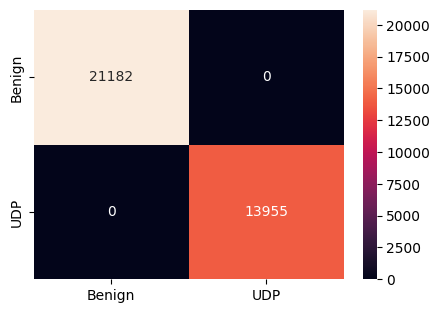





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  DT    1        1       1      1      1      1      1        0.503     0.016
 1  UDP           0    2     0  DT    1        1       1      1      1      1      1        0.503     0
 2  UDP           0    3     0  DT    1        1       1      1      1      1      1        0.424     0.016
 3  UDP           0    4     0  DT    1        1       1      1      1      1      1        0.456     0
 4  UDP           0    5     0  DT    1        1       1      1      1      1      1        1.069     0
 5  UDP           0    1     1  DT    1        1       1      1      1      1      1        0.409     0.016
 6  UDP           0    2     1  DT    1        1       1      1      1      1      1        1.085     0
 7  UDP           0    3     1  DT    1 

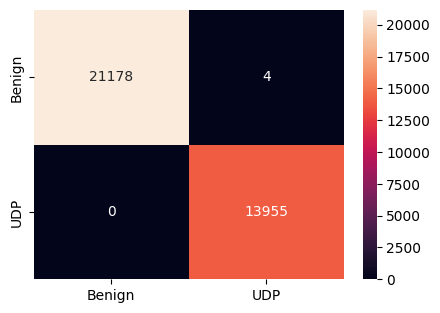





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           0    1     0  RF        1        1       1      1     1      1      1   57.833     0.596
 1  UDP           0    2     0  RF        1        1       1      1     1      1      1   58.967     0.613
 2  UDP           0    3     0  RF        1        1       1      1     1      1      1   59.247     0.56
 3  UDP           0    4     0  RF        1        1       1      1     1      1      1   58.572     0.597
 4  UDP           0    5     0  RF        1        1       1      1     1      1      1   58.923     0.629
 5  UDP           0    1     1  RF        1        1       1      1     1      1      1   60.049     1.32
 6  UDP           0    2     1  RF        1        1       1      1     1      1      1   57.202     0.628
 7  UDP           0    3     1  RF 

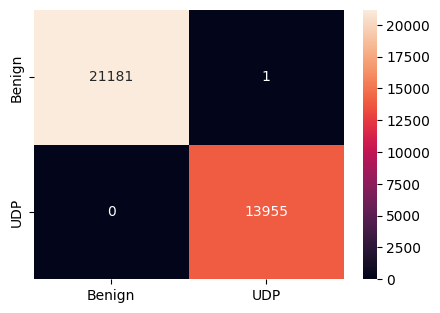





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           0    1     0  KNN       1        1       1      1     1      1      1    1.076    10.086
 1  UDP           0    2     0  KNN       1        1       1      1     1      1      1    0.848    12.372
 2  UDP           0    3     0  KNN       1        1       1      1     1      1      1    1.463    11.934
 3  UDP           0    4     0  KNN       1        1       1      1     1      1      1    1.822    12.754
 4  UDP           0    5     0  KNN       1        1       1      1     1      1      1    1.039    12.921
 5  UDP           0    1     1  KNN       1        1       1      1     1      1      1    0.849     8.809
 6  UDP           0    2     1  KNN       1        1       1      1     1      1      1    0.931    13.915
 7  UDP           0    3     1  K

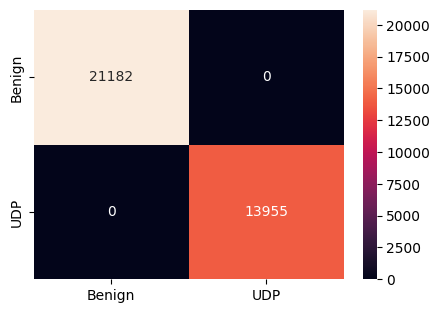





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  NB    0.673    0.728   0.775  0.728  0.668  0.4    0.728    0.094     0.031
 1  UDP           0    2     0  NB    0.675    0.729   0.776  0.729  0.67   0.404  0.729    0.094     0.031
 2  UDP           0    3     0  NB    0.675    0.73    0.775  0.73   0.67   0.404  0.73     0.094     0.047
 3  UDP           0    4     0  NB    0.673    0.729   0.774  0.729  0.668  0.401  0.729    0.11      0.031
 4  UDP           0    5     0  NB    0.674    0.731   0.773  0.731  0.669  0.403  0.731    0.094     0.031
 5  UDP           0    1     1  NB    0.677    0.731   0.776  0.731  0.672  0.407  0.731    0.126     0.031
 6  UDP           0    2     1  NB    0.674    0.73    0.774  0.73   0.669  0.403  0.73     0.107     0.047
 7  UDP           0    3

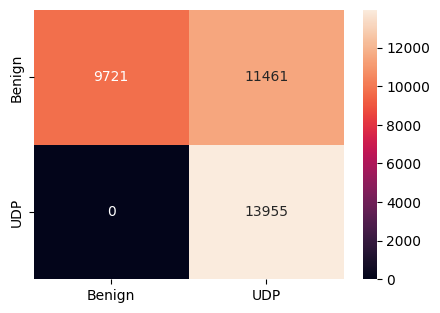





./INPUT/SW/MitM-ARP-6.csv
['ts', 'IP_version', 'IP_ihl', 'IP_tos', 'IP_DF', 'IP_ttl', 'IP_options', 'ICMP_code', 'TCP_reserved', 'TCP_flags', 'TCP_URG', 'TCP_ECE', 'TCP_CWR', 'TCP_urgptr', 'TCP_options', 'UDP_len', 'DNS_rd', 'DNS_qdcount', 'DNS_ancount', 'DNS_nscount', 'dport_class', 'entropy', 'dst_IP_diversity', 'pck_size_diff', 'pck_size_std_WE', 'ts_diff', 'payload_bytes_diff', 'payload_bytes_sum_of_EW', 'entropy_diff', 'entropy_mean_WE', 'entropy_std_WE', 'entropy_sum_of_EW', 'ts_mean_2', 'ts_std_2', 'payload_bytes_mean_2', 'payload_bytes_std_2', 'entropy_std_2', 'sport_sum', 'TCP_FIN_sum', 'TCP_SYN_sum', 'TCP_RST_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_RST_ratio', 'TCP_PSH_ratio', 'TCP_ACK_ratio', 'TCP_CWR_ratio', 'TCP_SYN_SR', 'TCP_PSH_SR', 'TCP_ECE_SR', 'TCP_CWR_SR', 'pck_size_std_6', 'ts_mean_6', 'ts_std_6', 'TCP_window_std_6', 'payload_bytes_mean_6', 'entropy_std_6', 'pck_size_std_9', 'ts_std_9', 'TCP_window_std_9', 'payload_bytes_mean_9', 'entropy_mean_9', 'entropy_st

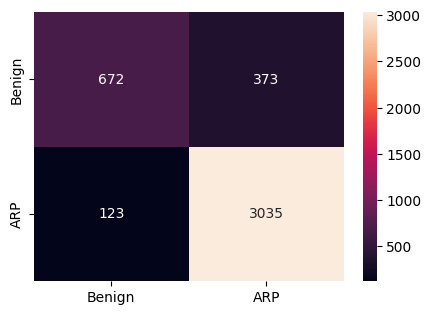





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  DT    0.996    0.995   0.996  0.995  0.995  0.991  0.995    0.361         0
 1  ARP           0    2     0  DT    0.996    0.994   0.995  0.994  0.994  0.989  0.994    0.393         0
 2  ARP           0    3     0  DT    0.997    0.997   0.996  0.997  0.997  0.993  0.997    0.424         0
 3  ARP           0    4     0  DT    0.995    0.995   0.993  0.995  0.994  0.988  0.995    0.441         0
 4  ARP           0    5     0  DT    0.995    0.994   0.993  0.994  0.994  0.988  0.994    0.392         0
 5  ARP           0    1     1  DT    0.996    0.995   0.995  0.995  0.995  0.99   0.995    0.44          0
 6  ARP           0    2     1  DT    0.996    0.995   0.995  0.995  0.995  0.991  0.995    0.424         0
 7  ARP           0    3

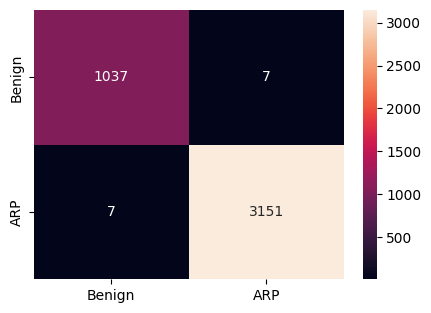





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  RF    0.997    0.997   0.996  0.997  0.996  0.993  0.997    4.622     0.094
 1  ARP           0    2     0  RF    0.997    0.996   0.997  0.996  0.996  0.993  0.996    4.941     0.11
 2  ARP           0    3     0  RF    0.998    0.997   0.997  0.997  0.997  0.994  0.997    4.127     0.314
 3  ARP           0    4     0  RF    0.997    0.995   0.997  0.995  0.996  0.991  0.995    4.875     0.33
 4  ARP           0    5     0  RF    0.998    0.997   0.998  0.997  0.998  0.996  0.997    4.795     0.11
 5  ARP           0    1     1  RF    0.996    0.996   0.993  0.996  0.994  0.989  0.996    5.442     0.298
 6  ARP           0    2     1  RF    0.997    0.996   0.997  0.996  0.996  0.992  0.996    4.856     0.189
 7  ARP           0    3   

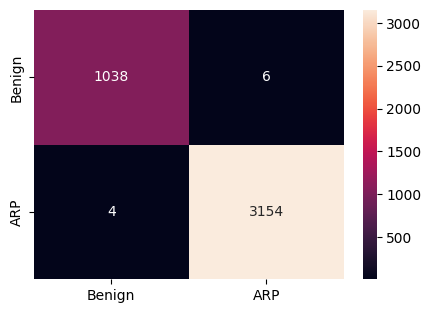





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  KNN   0.882    0.829   0.847  0.829  0.837  0.674  0.829    0.461     0.565
 1  ARP           0    2     0  KNN   0.874    0.815   0.836  0.815  0.825  0.65   0.815    0.173     0.236
 2  ARP           0    3     0  KNN   0.879    0.824   0.844  0.824  0.833  0.667  0.824    0.17      0.25
 3  ARP           0    4     0  KNN   0.87     0.816   0.826  0.816  0.821  0.642  0.816    0.158     0.267
 4  ARP           0    5     0  KNN   0.872    0.811   0.841  0.811  0.824  0.649  0.811    0.149     0.251
 5  ARP           0    1     1  KNN   0.877    0.824   0.835  0.824  0.829  0.659  0.824    0.19      0.299
 6  ARP           0    2     1  KNN   0.872    0.819   0.836  0.819  0.827  0.654  0.819    0.188     0.299
 7  ARP           0    3 

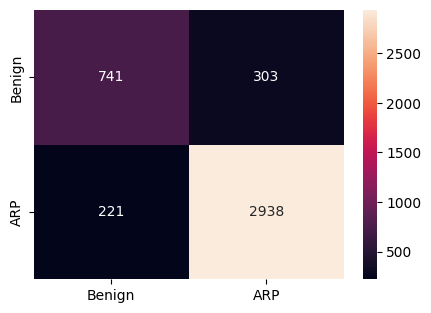





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  NB    0.759    0.581   0.664  0.581  0.586  0.201  0.581    0.031     0.016
 1  ARP           0    2     0  NB    0.757    0.594   0.664  0.594  0.603  0.226  0.594    0.031     0
 2  ARP           0    3     0  NB    0.741    0.563   0.618  0.563  0.563  0.154  0.563    0.016     0.016
 3  ARP           0    4     0  NB    0.773    0.645   0.688  0.645  0.658  0.322  0.645    0.031     0
 4  ARP           0    5     0  NB    0.777    0.613   0.693  0.613  0.627  0.272  0.613    0.016     0.016
 5  ARP           0    1     1  NB    0.767    0.615   0.675  0.615  0.628  0.269  0.615    0.032     0.016
 6  ARP           0    2     1  NB    0.739    0.575   0.641  0.575  0.577  0.183  0.575    0.031     0
 7  ARP           0    3     1  NB  

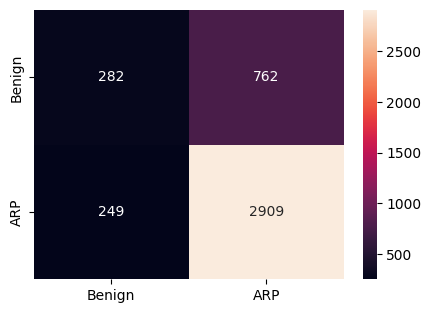





./INPUT/SW/H-Scan-Port-3.csv
['IP_flags', 'IP_DF', 'TCP_flags', 'TCP_SYN', 'TCP_ACK', 'dst_IP_diversity', 'entropy_std_WE', 'entropy_sum_of_EW', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'TCP_ACK_SR', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  LR    1        1       0.998  1      0.999  0.998  1        0.613         0
 1  SP            0    2     0  LR    1        1       0.998  1      0.999  0.998  1        0.381         0
 2  SP            0    3     0  LR    0.999    1       0.996  1      0.998  0.996  1        0.283         0
 3  SP            0    4     0  LR    1        1       0.998  1      0.999  0.998  1        0.235         0
 4  SP            0    5     0  LR    0.999    0.997   0.995  0.997  0.996  0.993  0.997    0.235         0
 5  SP            0    1     1  LR    1 

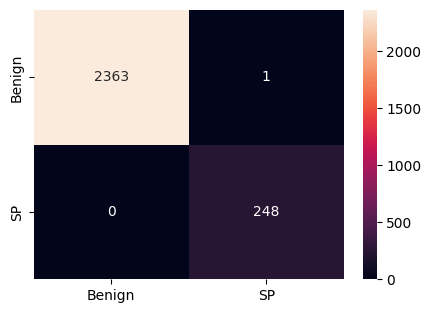





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  DT    0.999    0.996   1      0.996  0.998  0.995  0.996    0.016         0
 1  SP            0    2     0  DT    0.999    1       0.996  1      0.998  0.996  1        0.016         0
 2  SP            0    3     0  DT    1        1       1      1      1      1      1        0.016         0
 3  SP            0    4     0  DT    1        1       1      1      1      1      1        0.016         0
 4  SP            0    5     0  DT    1        1       1      1      1      1      1        0.016         0
 5  SP            0    1     1  DT    1        1       0.998  1      0.999  0.998  1        0.094         0
 6  SP            0    2     1  DT    1        1       1      1      1      1      1        0.063         0
 7  SP            0    3

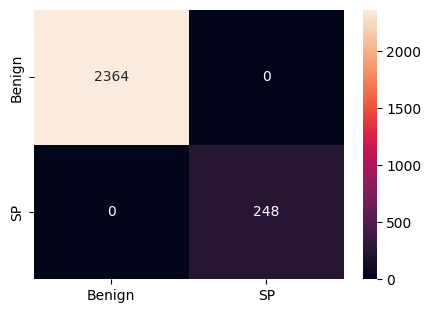





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  RF        1    0.998       1  0.998  0.999  0.998  0.998    0.503     0.016
 1  SP            0    2     0  RF        1    1           1  1      1      1      1        0.314     0.016
 2  SP            0    3     0  RF        1    0.998       1  0.998  0.999  0.998  0.998    0.393     0.016
 3  SP            0    4     0  RF        1    1           1  1      1      1      1        0.378     0.016
 4  SP            0    5     0  RF        1    1           1  1      1      1      1        0.363     0.014
 5  SP            0    1     1  RF        1    1           1  1      1      1      1        0.39      0.031
 6  SP            0    2     1  RF        1    1           1  1      1      1      1        0.409     0.031
 7  SP            0    3

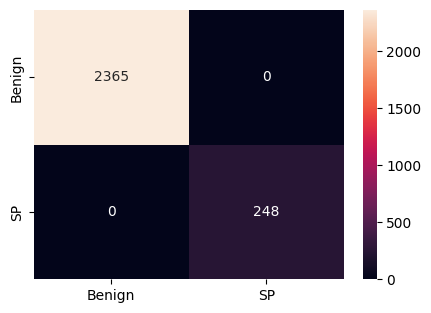





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  KNN   1        1       1      1      1      1      1        0.047     0.126
 1  SP            0    2     0  KNN   1        1       1      1      1      1      1        0.031     0.126
 2  SP            0    3     0  KNN   1        1       0.998  1      0.999  0.997  1        0.031     0.141
 3  SP            0    4     0  KNN   0.999    0.998   0.998  0.998  0.998  0.996  0.998    0.031     0.157
 4  SP            0    5     0  KNN   1        0.998   1      0.998  0.999  0.998  0.998    0.031     0.11
 5  SP            0    1     1  KNN   0.999    0.996   1      0.996  0.998  0.995  0.996    0.031     0.126
 6  SP            0    2     1  KNN   1        1       0.998  1      0.999  0.998  1        0.048     0.11
 7  SP            0    3  

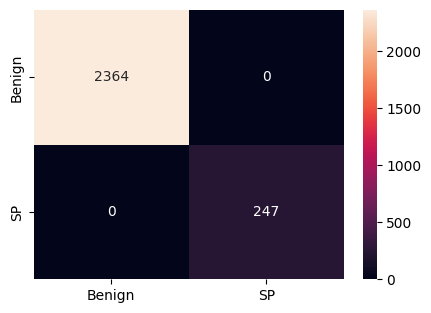





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  NB    0.991    0.99    0.961  0.99   0.975  0.949  0.99     0.016     0
 1  SP            0    2     0  NB    0.991    0.995   0.958  0.995  0.975  0.951  0.995    0         0
 2  SP            0    3     0  NB    0.993    0.994   0.968  0.994  0.981  0.962  0.994    0         0
 3  SP            0    4     0  NB    0.993    0.996   0.968  0.996  0.982  0.963  0.996    0         0
 4  SP            0    5     0  NB    0.992    0.996   0.958  0.996  0.976  0.952  0.996    0.016     0
 5  SP            0    1     1  NB    0.993    0.996   0.966  0.996  0.981  0.961  0.996    0         0.032
 6  SP            0    2     1  NB    0.991    0.995   0.956  0.995  0.974  0.948  0.995    0         0
 7  SP            0    3     1  NB    0.99     0

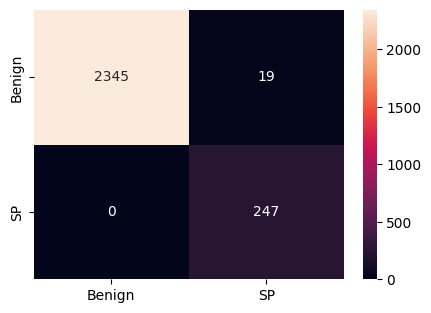





./INPUT/SW/MB-BF-5.csv
['ts', 'TCP_window_sum_of_EW', 'entropy_mean_WE', 'pck_size_std_2', 'TCP_window_mean_2', 'TCP_window_std_2', 'payload_bytes_mean_2', 'sport_sum', 'TCP_FIN_sum', 'TCP_FIN_SR', 'pck_size_mean_6', 'pck_size_std_6', 'ts_std_6', 'TCP_window_mean_6', 'TCP_window_std_6', 'payload_bytes_mean_6', 'payload_bytes_std_6', 'ts_mean_9', 'ts_std_9', 'TCP_window_mean_9', 'TCP_window_std_9', 'payload_bytes_mean_9', 'payload_bytes_std_9', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  LR        1    1           1  1      1      1      1        0.393     0
 1  BF            0    2     0  LR        1    1           1  1      1      1      1        0.126     0
 2  BF            0    3     0  LR        1    1           1  1      1      1      1        0.22      0
 3  BF     

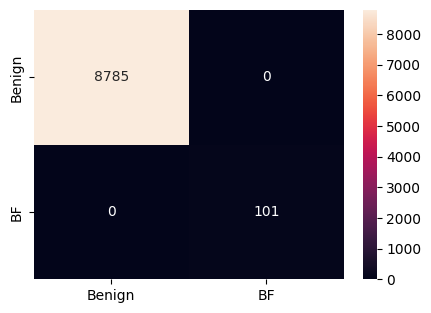





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  DT        1        1   1          1  1      1          1    0.126     0.016
 1  BF            0    2     0  DT        1        1   1          1  1      1          1    0.126     0.016
 2  BF            0    3     0  DT        1        1   1          1  1      1          1    0.126     0
 3  BF            0    4     0  DT        1        1   1          1  1      1          1    0.112     0
 4  BF            0    5     0  DT        1        1   0.996      1  0.998  0.995      1    0.17      0.003
 5  BF            0    1     1  DT        1        1   1          1  1      1          1    0.189     0
 6  BF            0    2     1  DT        1        1   1          1  1      1          1    0.158     0.016
 7  BF            0    3     1  DT  

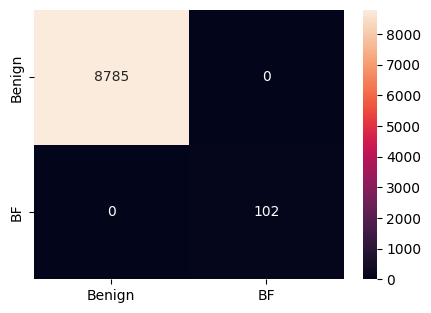





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  BF            0    1     0  RF        1        1       1      1     1      1      1   10.907     0.126
 1  BF            0    2     0  RF        1        1       1      1     1      1      1    9.573     0.141
 2  BF            0    3     0  RF        1        1       1      1     1      1      1    8.838     0.157
 3  BF            0    4     0  RF        1        1       1      1     1      1      1   10.046     0.362
 4  BF            0    5     0  RF        1        1       1      1     1      1      1    8.756     0.267
 5  BF            0    1     1  RF        1        1       1      1     1      1      1    9.135     0.157
 6  BF            0    2     1  RF        1        1       1      1     1      1      1    9.951     0.487
 7  BF            0    3     1  R

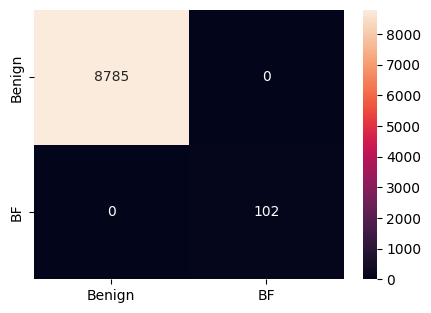





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  KNN   0.998    0.93    0.979  0.93   0.953  0.906  0.93     0.801     0.711
 1  BF            0    2     0  KNN   0.999    0.965   0.979  0.965  0.972  0.945  0.965    0.283     0.252
 2  BF            0    3     0  KNN   0.999    0.982   0.965  0.982  0.973  0.947  0.982    0.252     0.252
 3  BF            0    4     0  KNN   0.999    0.968   0.957  0.968  0.963  0.925  0.968    0.268     0.204
 4  BF            0    5     0  KNN   0.998    0.949   0.98   0.949  0.964  0.928  0.949    0.283     0.283
 5  BF            0    1     1  KNN   0.998    0.97    0.948  0.97   0.958  0.917  0.97     0.299     0.283
 6  BF            0    2     1  KNN   0.999    0.962   0.985  0.962  0.973  0.946  0.962    0.31      0.267
 7  BF            0    3

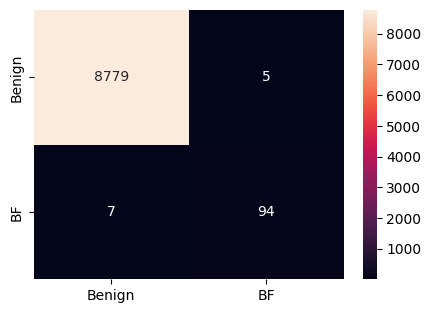





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  NB    0.982    0.681   0.628  0.681  0.65   0.3    0.681    0.016     0.016
 1  BF            0    2     0  NB    0.983    0.72    0.671  0.72   0.692  0.385  0.72     0.016     0.016
 2  BF            0    3     0  NB    0.98     0.665   0.643  0.665  0.653  0.307  0.665    0.11      0
 3  BF            0    4     0  NB    0.982    0.739   0.659  0.739  0.691  0.382  0.739    0.078     0
 4  BF            0    5     0  NB    0.983    0.709   0.629  0.709  0.659  0.318  0.709    0.022     0.01
 5  BF            0    1     1  NB    0.982    0.677   0.626  0.677  0.647  0.294  0.677    0.016     0
 6  BF            0    2     1  NB    0.981    0.696   0.64   0.696  0.663  0.327  0.696    0.016     0.016
 7  BF            0    3     1  NB   

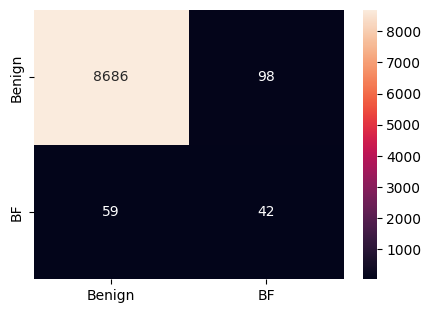





./INPUT/SW/Scan-OS-3.csv
['TCP_flags', 'TCP_SYN', 'TCP_ACK', 'TCP_URG', 'TCP_window', 'TCP_urgptr', 'UDP_len', 'entropy', 'Protocol', 'dst_port_diversity', 'pck_size_mean_WE', 'pck_size_std_WE', 'ts_diff', 'ts_std_WE', 'ts_sum_of_EW', 'TCP_window_std_WE', 'payload_bytes_diff', 'payload_bytes_mean_WE', 'payload_bytes_std_WE', 'entropy_mean_WE', 'entropy_std_WE', 'entropy_sum_of_EW', 'ts_mean_2', 'payload_bytes_std_2', 'dport_sum', 'TCP_SYN_sum', 'TCP_PSH_sum', 'TCP_ACK_sum', 'TCP_URG_sum', 'TCP_FIN_ratio', 'TCP_PSH_ratio', 'TCP_ACK_ratio', 'sum', 'TCP_FIN_SR', 'TCP_SYN_SR', 'TCP_PSH_SR', 'TCP_ACK_SR', 'TCP_URG_SR', 'TCP_ECE_SR', 'TCP_CWR_SR', 'pck_size_mean_6', 'pck_size_std_6', 'ts_mean_6', 'ts_std_6', 'payload_bytes_mean_6', 'entropy_mean_6', 'pck_size_mean_9', 'ts_mean_9', 'payload_bytes_mean_9', 'entropy_mean_9', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  ------

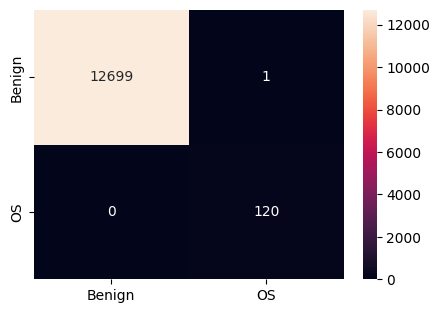





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  DT        1    1       1      1      1      1      1        0.157     0
 1  OS            0    2     0  DT        1    1       1      1      1      1      1        0.173     0
 2  OS            0    3     0  DT        1    0.996   0.992  0.996  0.994  0.988  0.996    0.141     0
 3  OS            0    4     0  DT        1    1       1      1      1      1      1        0.205     0
 4  OS            0    5     0  DT        1    1       1      1      1      1      1        0.182     0.007
 5  OS            0    1     1  DT        1    0.991   1      0.991  0.996  0.991  0.991    0.205     0.016
 6  OS            0    2     1  DT        1    0.996   1      0.996  0.998  0.996  0.996    0.188     0.016
 7  OS            0    3     1  DT      

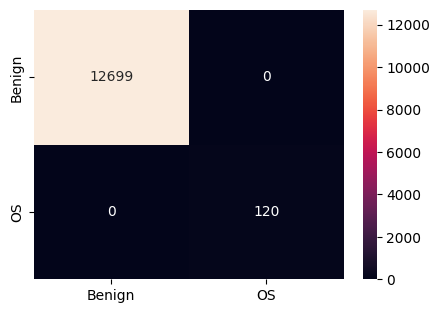





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  RF        1    1       0.996  1      0.998  0.996  1        3.094     0.063
 1  OS            0    2     0  RF        1    1       1      1      1      1      1        1.635     0.031
 2  OS            0    3     0  RF        1    1       1      1      1      1      1        1.273     0.032
 3  OS            0    4     0  RF        1    1       0.996  1      0.998  0.996  1        3.064     0.031
 4  OS            0    5     0  RF        1    0.997   1      0.997  0.998  0.997  0.997    1.47      0.031
 5  OS            0    1     1  RF        1    0.995   1      0.995  0.997  0.995  0.995    1.541     0.031
 6  OS            0    2     1  RF        1    1       0.997  1      0.998  0.997  1        1.321     0.046
 7  OS            0    3

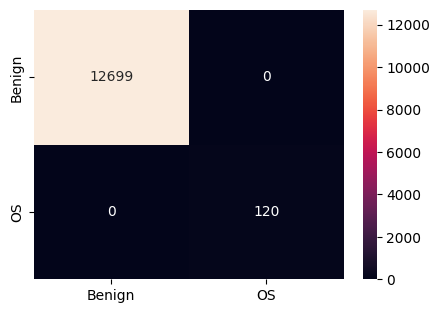





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  KNN       1    0.992   1      0.992  0.996  0.992  0.992    0.456     0.33
 1  OS            0    2     0  KNN       1    1       1      1      1      1      1        0.472     0.426
 2  OS            0    3     0  KNN       1    0.991   0.995  0.991  0.993  0.986  0.991    0.551     0.376
 3  OS            0    4     0  KNN       1    0.992   0.992  0.992  0.992  0.984  0.992    0.519     0.393
 4  OS            0    5     0  KNN       1    1       1      1      1      1      1        0.566     0.393
 5  OS            0    1     1  KNN       1    0.992   1      0.992  0.996  0.992  0.992    1.195     0.816
 6  OS            0    2     1  KNN       1    0.988   0.992  0.988  0.99   0.98   0.988    0.504     0.377
 7  OS            0    3 

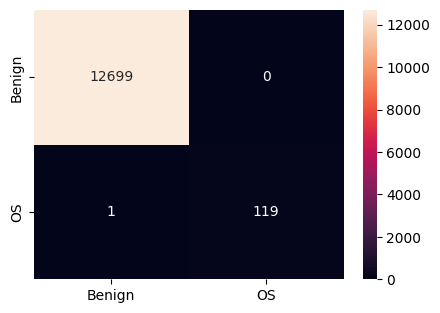





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  NB        1        1   0.988      1  0.994  0.987      1    0.047     0.016
 1  OS            0    2     0  NB        1        1   0.979      1  0.989  0.979      1    0.047     0.016
 2  OS            0    3     0  NB        1        1   0.988      1  0.994  0.988      1    0.048     0.016
 3  OS            0    4     0  NB        1        1   0.993      1  0.996  0.993      1    0.047     0.016
 4  OS            0    5     0  NB        1        1   0.996      1  0.998  0.996      1    0.078     0.016
 5  OS            0    1     1  NB        1        1   0.992      1  0.996  0.992      1    0.063     0.016
 6  OS            0    2     1  NB        1        1   0.988      1  0.994  0.988      1    0.062     0.032
 7  OS            0    3

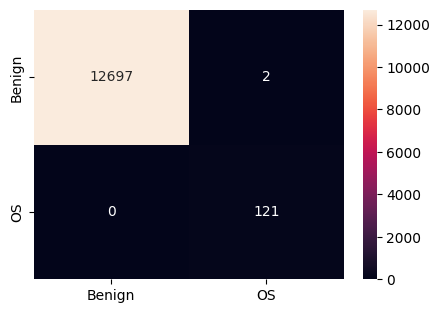





./INPUT/SW/Scan-HDis-3.csv
['ts', 'Ether_type', 'IP_version', 'IP_ihl', 'TCP_dataofs', 'TCP_flags', 'TCP_ACK', 'TCP_options', 'sport_class', 'dport_class', 'pck_size_sum_of_EW', 'ts_mean_WE', 'ts_sum_of_EW', 'TCP_window_mean_WE', 'TCP_window_sum_of_EW', 'payload_bytes_mean_WE', 'payload_bytes_std_WE', 'payload_bytes_sum_of_EW', 'entropy_std_WE', 'TCP_PSH_sum', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'sum', 'pck_size_mean_6', 'ts_mean_6', 'ts_std_6', 'pck_size_mean_9', 'ts_mean_9', 'ts_std_9', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  LR    0.998    0.999   0.982  0.999  0.99   0.981  0.999    0.267         0
 1  SCHD          0    2     0  LR    0.999    1       0.989  1      0.994  0.988  1        0.393         0
 2  SCHD          0    3     0  LR    0.999    1       0.99   1  

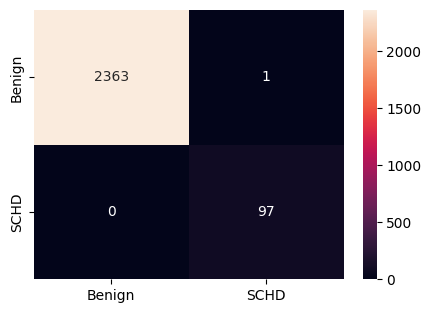





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  DT        1        1   1          1  1      1          1    0.024     0
 1  SCHD          0    2     0  DT        1        1   1          1  1      1          1    0.031     0
 2  SCHD          0    3     0  DT        1        1   1          1  1      1          1    0.016     0
 3  SCHD          0    4     0  DT        1        1   0.995      1  0.998  0.995      1    0.031     0
 4  SCHD          0    5     0  DT        1        1   1          1  1      1          1    0.013     0.004
 5  SCHD          0    1     1  DT        1        1   1          1  1      1          1    0.008     0
 6  SCHD          0    2     1  DT        1        1   1          1  1      1          1    0.016     0
 7  SCHD          0    3     1  DT        1     

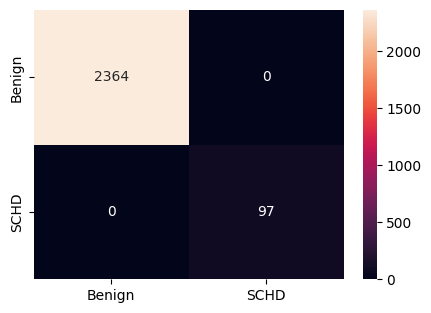





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  RF        1        1   1          1  1      1          1    1.211     0.062
 1  SCHD          0    2     0  RF        1        1   0.995      1  0.997  0.995      1    2.139     0.016
 2  SCHD          0    3     0  RF        1        1   1          1  1      1          1    0.928     0.031
 3  SCHD          0    4     0  RF        1        1   1          1  1      1          1    0.944     0.031
 4  SCHD          0    5     0  RF        1        1   1          1  1      1          1    1.147     0.047
 5  SCHD          0    1     1  RF        1        1   1          1  1      1          1    1.132     0.032
 6  SCHD          0    2     1  RF        1        1   1          1  1      1          1    1.132     0.031
 7  SCHD          0    3

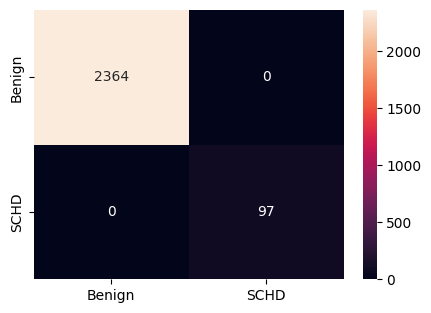





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  KNN   1        1       1      1      1      1      1        0.047     0.189
 1  SCHD          0    2     0  KNN   0.999    1       0.991  1      0.995  0.99   1        0.048     0.11
 2  SCHD          0    3     0  KNN   0.999    0.994   0.989  0.994  0.992  0.984  0.994    0.204     0.267
 3  SCHD          0    4     0  KNN   1        1       0.993  1      0.996  0.993  1        0.062     0.345
 4  SCHD          0    5     0  KNN   1        0.995   1      0.995  0.998  0.995  0.995    0.078     0.298
 5  SCHD          0    1     1  KNN   1        0.995   1      0.995  0.997  0.995  0.995    0.094     0.268
 6  SCHD          0    2     1  KNN   1        1       0.995  1      0.997  0.995  1        0.189     0.22
 7  SCHD          0    3  

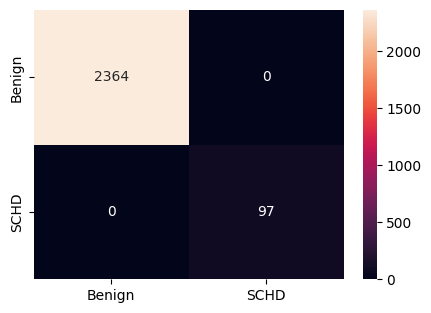





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  NB    0.985    0.992   0.856  0.992  0.912  0.824  0.992    0.012         0
 1  SCHD          0    2     0  NB    0.986    0.993   0.85   0.993  0.908  0.816  0.993    0             0
 2  SCHD          0    3     0  NB    0.982    0.991   0.845  0.991  0.904  0.808  0.991    0             0
 3  SCHD          0    4     0  NB    0.987    0.993   0.892  0.993  0.936  0.872  0.993    0.01          0
 4  SCHD          0    5     0  NB    0.985    0.992   0.866  0.992  0.919  0.837  0.992    0             0
 5  SCHD          0    1     1  NB    0.985    0.992   0.871  0.992  0.922  0.844  0.992    0             0
 6  SCHD          0    2     1  NB    0.985    0.992   0.854  0.992  0.91   0.821  0.992    0.016         0
 7  SCHD          0    3

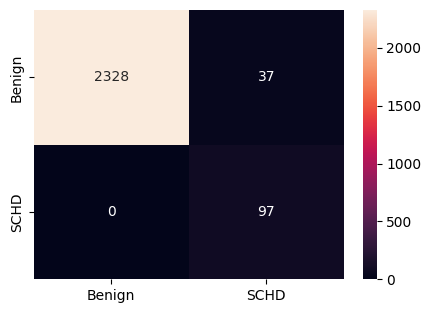





./INPUT/SW/MB-HDis-3.csv
['ts', 'IP_version', 'IP_flags', 'IP_proto', 'TCP_dataofs', 'TCP_options', 'sport_class', 'dport_class', 'Protocol', 'pck_size_mean_WE', 'pck_size_std_WE', 'ts_mean_WE', 'ts_sum_of_EW', 'TCP_window_sum_of_EW', 'ts_mean_2', 'ts_std_2', 'pck_size_mean_6', 'ts_mean_6', 'pck_size_mean_9', 'ts_mean_9', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  LR        1    1       0.976  1      0.988  0.976  1        1.21      0
 1  MHDis         0    2     0  LR        1    0.959   1      0.959  0.979  0.957  0.959    1.133     0
 2  MHDis         0    3     0  LR        1    1       1      1      1      1      1        1.73      0
 3  MHDis         0    4     0  LR        1    1       0.988  1      0.994  0.988  1        2.025     0
 4  MHDis         0    5     0 

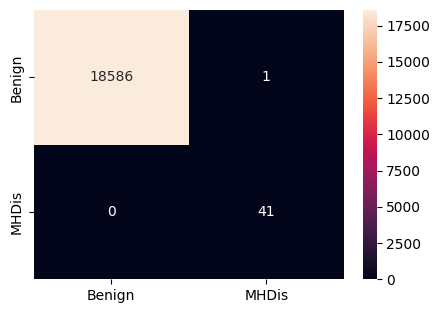





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  DT        1    0.978   1      0.978  0.989  0.978  0.978    0.205     0
 1  MHDis         0    2     0  DT        1    0.981   0.972  0.981  0.977  0.953  0.981    0.22      0
 2  MHDis         0    3     0  DT        1    0.986   0.986  0.986  0.986  0.971  0.986    0.189     0.016
 3  MHDis         0    4     0  DT        1    0.973   1      0.973  0.986  0.972  0.973    0.471     0
 4  MHDis         0    5     0  DT        1    0.949   0.986  0.949  0.967  0.933  0.949    0.55      0
 5  MHDis         0    1     1  DT        1    0.977   0.988  0.977  0.982  0.965  0.977    0.327     0
 6  MHDis         0    2     1  DT        1    1       1      1      1      1      1        0.194     0
 7  MHDis         0    3     1  DT        1    0

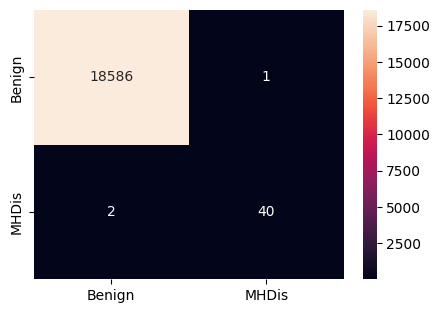





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  RF        1    1       1      1      1      1      1        3.474     0.094
 1  MHDis         0    2     0  RF        1    1       0.915  1      0.953  0.906  1        5.534     0.109
 2  MHDis         0    3     0  RF        1    1       0.94   1      0.968  0.936  1        5.047     0.086
 3  MHDis         0    4     0  RF        1    1       0.979  1      0.989  0.978  1        3.71      0.11
 4  MHDis         0    5     0  RF        1    1       0.946  1      0.971  0.943  1        5.677     0.079
 5  MHDis         0    1     1  RF        1    1       0.977  1      0.988  0.976  1        5.091     0.11
 6  MHDis         0    2     1  RF        1    1       0.935  1      0.965  0.93   1        3.837     0.11
 7  MHDis         0    3   

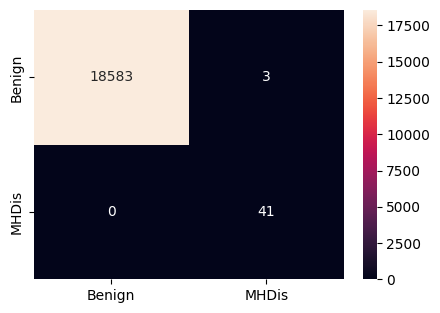





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  KNN       1    0.987   0.953  0.987  0.97   0.94   0.987    0.708     0.094
 1  MHDis         0    2     0  KNN       1    1       0.976  1      0.987  0.975  1        0.3       0.103
 2  MHDis         0    3     0  KNN       1    1       0.948  1      0.973  0.945  1        0.309     0.1
 3  MHDis         0    4     0  KNN       1    1       0.985  1      0.993  0.985  1        0.283     0.11
 4  MHDis         0    5     0  KNN       1    0.989   1      0.989  0.994  0.989  0.989    0.283     0.094
 5  MHDis         0    1     1  KNN       1    1       0.988  1      0.994  0.988  1        0.268     0.094
 6  MHDis         0    2     1  KNN       1    1       0.989  1      0.995  0.989  1        0.236     0.095
 7  MHDis         0    3   

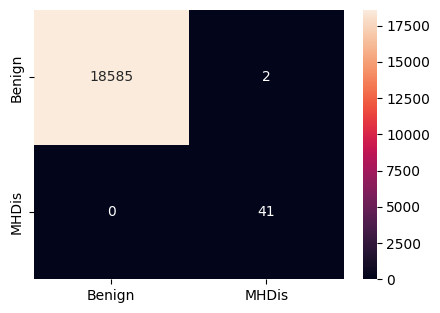





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  NB    0.945    0.972   0.52   0.972  0.525  0.073  0.972    0.032     0.016
 1  MHDis         0    2     0  NB    0.952    0.976   0.526  0.976  0.537  0.095  0.976    0.047     0.022
 2  MHDis         0    3     0  NB    0.951    0.975   0.521  0.975  0.527  0.076  0.975    0.047     0.016
 3  MHDis         0    4     0  NB    0.948    0.974   0.517  0.974  0.52   0.064  0.974    0.055     0.008
 4  MHDis         0    5     0  NB    0.949    0.974   0.522  0.974  0.528  0.079  0.974    0.047     0.031
 5  MHDis         0    1     1  NB    0.951    0.976   0.523  0.976  0.531  0.083  0.976    0.11      0.016
 6  MHDis         0    2     1  NB    0.949    0.974   0.522  0.974  0.53   0.082  0.974    0.189     0.016
 7  MHDis         0    3

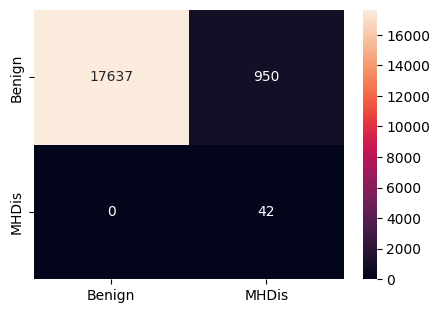

In [15]:
folder("results/cv/")

for file in file_list:
    print(file)
    feature=feature_list[file_list[file]]
    train=file
    test=file
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/cv/{file_list[file]}_VAL_chosed_output_ML_.csv"
    target_names=["Benign",file_list[file]]
    ML_CV(train,test,output_csv,feature,file_list[file],0)   


# SS

In [21]:
file_list={"SYN":['./INPUT/SM/DoS-SYN-1.csv','./INPUT/SW/DoS-SYN-2.csv'],
"HTTP":['./INPUT/SM/MB-HTTP-4.csv','./INPUT/SW/MB-HTTP-1.csv'],
"ACK":['./INPUT/SM/MB-ACK-4.csv','./INPUT/SW/MB-ACK-1.csv'],
"UDP":['./INPUT/SM/MB-UDP-4.csv','./INPUT/SW/MB-UDP-1.csv'],
"ARP":['./INPUT/SM/MitM-ARP-6.csv','./INPUT/SW/MitM-ARP-4.csv'],  
"SP":['./INPUT/SM/Scan-Port-3.csv','./INPUT/SW/H-Scan-Port-4.csv'],
"BF":['./INPUT/SM/MB-BF-5.csv','./INPUT/SW/MB-BF-3.csv'],
"OS":['./INPUT/SM/Scan-OS-3.csv','./INPUT/SW/Scan-OS-6.csv'],
"SCHD":['./INPUT/SM/Scan-HDis-3.csv','./INPUT/SW/MB-HDis-2.csv'],
"MHDis":['./INPUT/SM/MB-HDis-3.csv','./INPUT/SW/Scan-HDis-4.csv' ]}
 

SYN
['ts', 'IP_flags', 'IP_DF', 'TCP_SYN', 'TCP_ACK', 'sport_class', 'dst_IP_diversity', 'IP_add_count', 'pck_size_std_WE', 'pck_size_sum_of_EW', 'ts_mean_WE', 'TCP_window_std_WE', 'pck_size_mean_2', 'TCP_window_mean_2', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_ACK_ratio', 'TCP_SYN_SR', 'TCP_ACK_SR', 'pck_size_mean_6', 'ts_mean_6', 'TCP_window_mean_6', 'ts_mean_9', 'ts_std_9', 'TCP_window_mean_9', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  LR    0.993    0.994   0.991  0.994  0.992  0.985  0.994    0.11      0.016
 1  SYN           0    1     1  LR    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.069     0.007
 2  SYN           0    1     2  LR    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.075     0
 3  SYN           0    1     3  LR    0.997

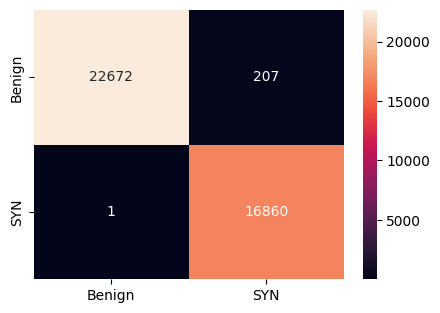





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.036     0.013
 1  SYN           0    1     1  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.022     0
 2  SYN           0    1     2  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.02      0
 3  SYN           0    1     3  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.038     0.01
 4  SYN           0    1     4  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.026     0.013
 5  SYN           0    1     5  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.038     0.008
 6  SYN           0    1     6  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.019     0.016
 7  SYN           0    1     7  D

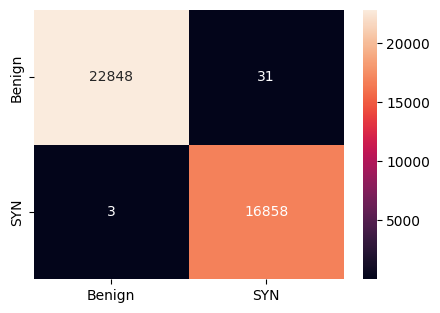





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  RF    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.51      0.14
 1  SYN           0    1     1  RF    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.512     0.151
 2  SYN           0    1     2  RF    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.547     0.131
 3  SYN           0    1     3  RF    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.568     0.145
 4  SYN           0    1     4  RF    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.547     0.136
 5  SYN           0    1     5  RF    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.546     0.142
 6  SYN           0    1     6  RF    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.518     0.141
 7  SYN           0    1 

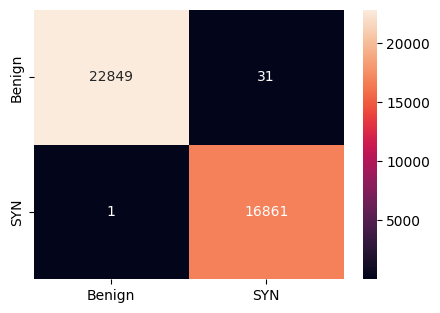





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  KNN   0.994    0.995   0.994  0.995  0.994  0.989  0.995    0.009     2.865
 1  SYN           0    1     1  KNN   0.994    0.995   0.994  0.995  0.994  0.989  0.995    0.004     1.508
 2  SYN           0    1     2  KNN   0.994    0.995   0.994  0.995  0.994  0.989  0.995    0.005     1.524
 3  SYN           0    1     3  KNN   0.994    0.995   0.994  0.995  0.994  0.989  0.995    0         1.541
 4  SYN           0    1     4  KNN   0.994    0.995   0.994  0.995  0.994  0.989  0.995    0         1.634
 5  SYN           0    1     5  KNN   0.994    0.995   0.994  0.995  0.994  0.989  0.995    0         1.611
 6  SYN           0    1     6  KNN   0.994    0.995   0.994  0.995  0.994  0.989  0.995    0         1.553
 7  SYN           0    1

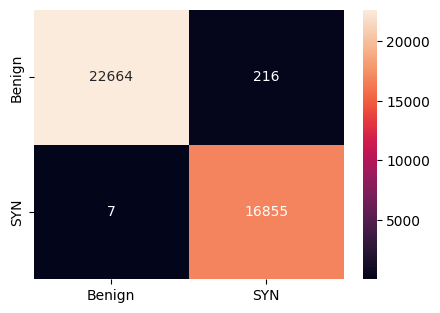





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  NB    0.994    0.995   0.993  0.995  0.994  0.987  0.995    0.016     0.031
 1  SYN           0    1     1  NB    0.994    0.995   0.993  0.995  0.994  0.987  0.995    0         0.031
 2  SYN           0    1     2  NB    0.994    0.995   0.993  0.995  0.994  0.987  0.995    0.01      0.022
 3  SYN           0    1     3  NB    0.994    0.995   0.993  0.995  0.994  0.987  0.995    0.016     0.031
 4  SYN           0    1     4  NB    0.994    0.995   0.993  0.995  0.994  0.987  0.995    0.019     0.029
 5  SYN           0    1     5  NB    0.994    0.995   0.993  0.995  0.994  0.987  0.995    0         0.031
 6  SYN           0    1     6  NB    0.994    0.995   0.993  0.995  0.994  0.987  0.995    0.016     0.031
 7  SYN           0    1

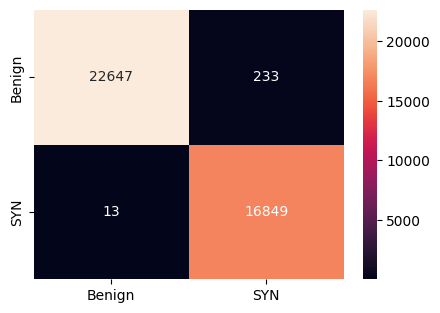





HTTP
['TCP_flags', 'dport_class', 'pck_size_sum_of_EW', 'ts_std_WE', 'ts_sum_of_EW', 'payload_bytes_sum_of_EW', 'entropy_mean_WE', 'TCP_window_mean_2', 'sport_sum', 'TCP_ACK_ratio', 'sum', 'TCP_PSH_SR', 'ts_std_6', 'entropy_mean_6', 'TCP_window_mean_9', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  LR    0.972    0.754   0.976  0.754  0.828  0.657  0.754    0.534     0
 1  HTTP          0    1     1  LR    0.972    0.754   0.976  0.754  0.828  0.657  0.754    0.441     0
 2  HTTP          0    1     2  LR    0.972    0.754   0.976  0.754  0.828  0.657  0.754    0.44      0.009
 3  HTTP          0    1     3  LR    0.972    0.754   0.976  0.754  0.828  0.657  0.754    0.425     0.016
 4  HTTP          0    1     4  LR    0.972    0.754   0.976  0.754  0.828  0.657  0.754    0

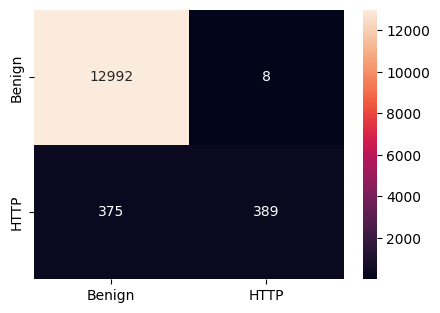





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  DT    0.992    0.931   0.996  0.931  0.961  0.922  0.931    0.047     0
 1  HTTP          0    1     1  DT    0.999    0.995   1      0.995  0.998  0.995  0.995    0.031     0
 2  HTTP          0    1     2  DT    0.995    0.956   0.995  0.956  0.975  0.95   0.956    0.047     0
 3  HTTP          0    1     3  DT    0.999    0.995   0.999  0.995  0.997  0.994  0.995    0.063     0
 4  HTTP          0    1     4  DT    0.999    0.995   1      0.995  0.998  0.995  0.995    0.016     0
 5  HTTP          0    1     5  DT    0.994    0.944   0.997  0.944  0.969  0.937  0.944    0.094     0.016
 6  HTTP          0    1     6  DT    0.999    0.995   1      0.995  0.998  0.995  0.995    0.031     0.016
 7  HTTP          0    1     7  DT    0.999 

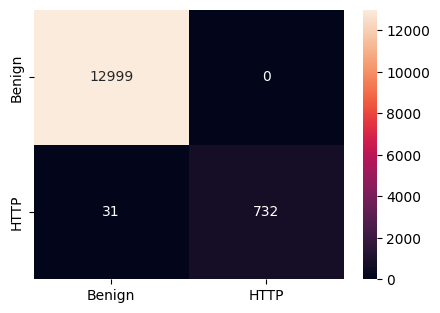





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  RF    0.999    0.995       1  0.995  0.998  0.995  0.995    2.796     0.126
 1  HTTP          0    1     1  RF    0.999    0.995       1  0.995  0.998  0.995  0.995    2.684     0.125
 2  HTTP          0    1     2  RF    0.999    0.991       1  0.991  0.995  0.991  0.991    2.777     0.094
 3  HTTP          0    1     3  RF    0.999    0.993       1  0.993  0.996  0.992  0.993    2.685     0.125
 4  HTTP          0    1     4  RF    0.999    0.995       1  0.995  0.997  0.994  0.995    2.593     0.11
 5  HTTP          0    1     5  RF    0.999    0.995       1  0.995  0.998  0.995  0.995    2.599     0.126
 6  HTTP          0    1     6  RF    0.999    0.995       1  0.995  0.998  0.995  0.995    2.638     0.11
 7  HTTP          0    1  

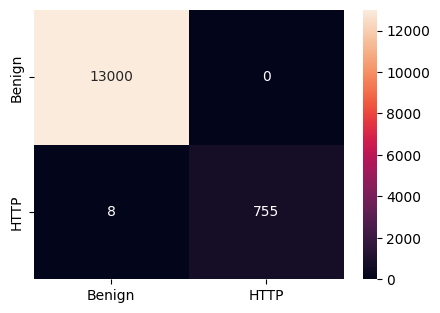





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  HTTP          0    1     0  KNN   0.979    0.817   0.979  0.817  0.88   0.76  0.817    0.063     0.157
 1  HTTP          0    1     1  KNN   0.979    0.817   0.979  0.817  0.88   0.76  0.817    0.063     0.158
 2  HTTP          0    1     2  KNN   0.979    0.817   0.979  0.817  0.88   0.76  0.817    0.063     0.157
 3  HTTP          0    1     3  KNN   0.979    0.817   0.979  0.817  0.88   0.76  0.817    0.063     0.172
 4  HTTP          0    1     4  KNN   0.979    0.817   0.979  0.817  0.88   0.76  0.817    0.063     0.175
 5  HTTP          0    1     5  KNN   0.979    0.817   0.979  0.817  0.88   0.76  0.817    0.057     0.155
 6  HTTP          0    1     6  KNN   0.979    0.817   0.979  0.817  0.88   0.76  0.817    0.066     0.164
 7  HTTP          0    1     7  K

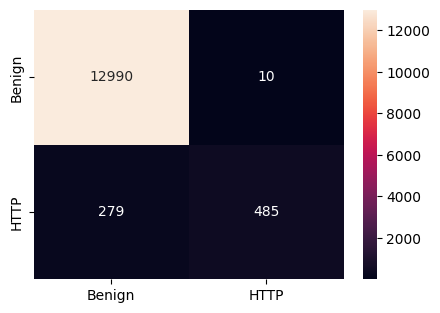





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  NB    0.564    0.769   0.556  0.769  0.451  0.115  0.769    0.009     0.008
 1  HTTP          0    1     1  NB    0.564    0.769   0.556  0.769  0.451  0.115  0.769    0.011     0.008
 2  HTTP          0    1     2  NB    0.564    0.769   0.556  0.769  0.451  0.115  0.769    0.016     0
 3  HTTP          0    1     3  NB    0.564    0.769   0.556  0.769  0.451  0.115  0.769    0.008     0.01
 4  HTTP          0    1     4  NB    0.564    0.769   0.556  0.769  0.451  0.115  0.769    0.011     0.002
 5  HTTP          0    1     5  NB    0.564    0.769   0.556  0.769  0.451  0.115  0.769    0.006     0.001
 6  HTTP          0    1     6  NB    0.564    0.769   0.556  0.769  0.451  0.115  0.769    0.008     0.004
 7  HTTP          0    1     

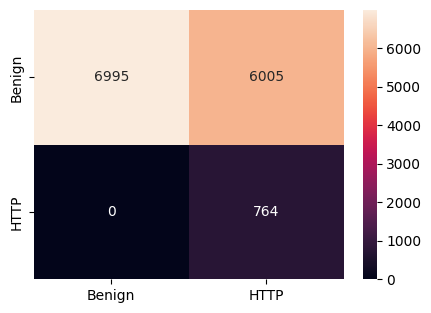





ACK
['ts_std_WE', 'TCP_window_sum_of_EW', 'payload_bytes_mean_WE', 'payload_bytes_sum_of_EW', 'sport_sum', 'TCP_ACK_ratio', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  LR    0.999    0.999   0.998  0.999  0.999  0.997  0.999   16.201     0
 1  ACK           0    1     1  LR    0.999    0.999   0.998  0.999  0.999  0.997  0.999   15.669     0.002
 2  ACK           0    1     2  LR    0.999    0.999   0.998  0.999  0.999  0.997  0.999   41.919     0.002
 3  ACK           0    1     3  LR    0.999    0.999   0.998  0.999  0.999  0.997  0.999   14.952     0.003
 4  ACK           0    1     4  LR    0.999    0.999   0.998  0.999  0.998  0.997  0.999   12.801     0
 5  ACK           0    1     5  LR    0.999    0.999   0.998  0.999  0.999  0.997  0.999   12.787     0.002
 6  ACK

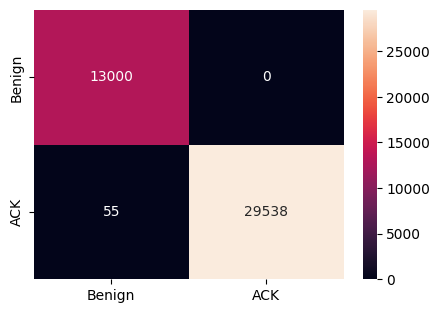





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  DT    1        1       1      1      1      0.999  1        0.018     0.002
 1  ACK           0    1     1  DT    1        1       1      1      1      0.999  1        0.013     0.003
 2  ACK           0    1     2  DT    0.826    0.875   0.818  0.875  0.817  0.646  0.875    0.014     0.003
 3  ACK           0    1     3  DT    1        1       0.999  1      1      0.999  1        0.016     0.002
 4  ACK           0    1     4  DT    0.999    0.999   0.998  0.999  0.999  0.997  0.999    0.014     0.001
 5  ACK           0    1     5  DT    1        1       0.999  1      1      0.999  1        0.016     0.002
 6  ACK           0    1     6  DT    1        1       1      1      1      0.999  1        0.026     0.002
 7  ACK           0    1

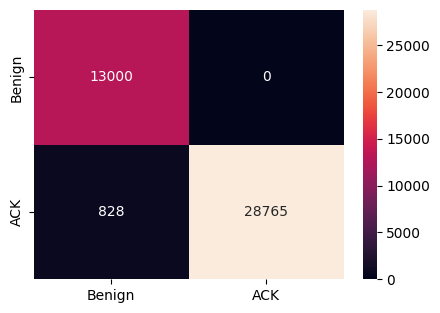





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  ACK           0    1     0  RF        1        1   0.999      1     1  0.999      1    3.605     0.391
 1  ACK           0    1     1  RF        1        1   0.999      1     1  0.999      1    3.541     0.402
 2  ACK           0    1     2  RF        1        1   0.999      1     1  0.999      1    3.603     0.404
 3  ACK           0    1     3  RF        1        1   0.999      1     1  0.999      1    3.63      0.42
 4  ACK           0    1     4  RF        1        1   0.999      1     1  0.999      1    3.725     0.42
 5  ACK           0    1     5  RF        1        1   0.999      1     1  0.999      1    3.703     0.465
 6  ACK           0    1     6  RF        1        1   0.999      1     1  0.999      1    3.571     0.39
 7  ACK           0    1     7  RF  

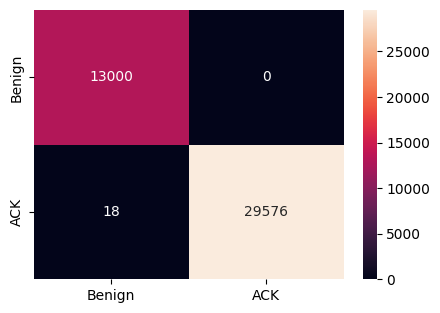





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  KNN   0.627    0.722   0.708  0.722  0.627  0.335  0.722    0.03      1.015
 1  ACK           0    1     1  KNN   0.627    0.722   0.708  0.722  0.627  0.335  0.722    0.031     1.024
 2  ACK           0    1     2  KNN   0.627    0.722   0.708  0.722  0.627  0.335  0.722    0.026     1.025
 3  ACK           0    1     3  KNN   0.627    0.722   0.708  0.722  0.627  0.335  0.722    0.037     0.934
 4  ACK           0    1     4  KNN   0.627    0.722   0.708  0.722  0.627  0.335  0.722    0.03      1.021
 5  ACK           0    1     5  KNN   0.627    0.722   0.708  0.722  0.627  0.335  0.722    0.029     1.03
 6  ACK           0    1     6  KNN   0.627    0.722   0.708  0.722  0.627  0.335  0.722    0.033     1.009
 7  ACK           0    1 

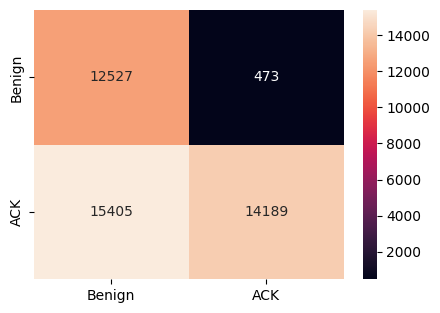





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  NB    0.567    0.688   0.707  0.688  0.566  0.269  0.688    0.005     0.01
 1  ACK           0    1     1  NB    0.567    0.688   0.707  0.688  0.566  0.269  0.688    0.006     0.008
 2  ACK           0    1     2  NB    0.567    0.688   0.707  0.688  0.566  0.269  0.688    0.005     0.008
 3  ACK           0    1     3  NB    0.567    0.688   0.707  0.688  0.566  0.269  0.688    0.005     0.009
 4  ACK           0    1     4  NB    0.567    0.688   0.707  0.688  0.566  0.269  0.688    0.006     0.008
 5  ACK           0    1     5  NB    0.567    0.688   0.707  0.688  0.566  0.269  0.688    0.005     0.009
 6  ACK           0    1     6  NB    0.567    0.688   0.707  0.688  0.566  0.269  0.688    0.004     0.008
 7  ACK           0    1 

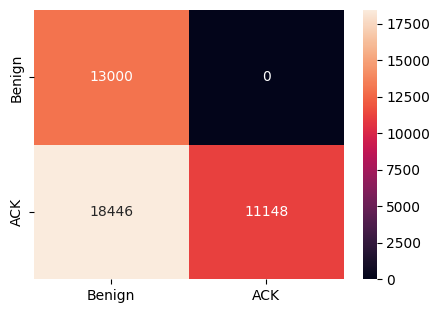





UDP
['IP_tos', 'IP_flags', 'IP_DF', 'IP_proto', 'TCP_dataofs', 'TCP_flags', 'TCP_ACK', 'TCP_window', 'TCP_options', 'sport_class', 'Protocol', 'ts_diff', 'ts_std_WE', 'TCP_window_mean_WE', 'TCP_window_std_WE', 'TCP_window_sum_of_EW', 'ts_mean_2', 'TCP_window_mean_2', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'sum', 'TCP_ACK_SR', 'ts_std_6', 'TCP_window_mean_6', 'entropy_std_6', 'ts_std_9', 'TCP_window_mean_9', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  LR        1    0.998       1  0.998  0.999  0.998  0.998    0.404     0.028
 1  UDP           0    1     1  LR        1    0.998       1  0.998  0.999  0.998  0.998    0.396     0.029
 2  UDP           0    1     2  LR        1    0.998       1  0.998  0.999  0.998  0.998    0.396     0.03
 3  UDP           0    1     

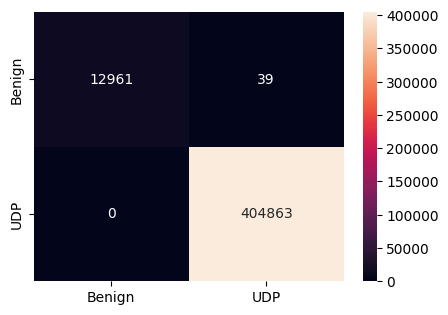





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           0    1     0  DT        1        1       1      1     1      1      1    0.044     0.059
 1  UDP           0    1     1  DT        1        1       1      1     1      1      1    0.04      0.073
 2  UDP           0    1     2  DT        1        1       1      1     1      1      1    0.047     0.053
 3  UDP           0    1     3  DT        1        1       1      1     1      1      1    0.056     0.054
 4  UDP           0    1     4  DT        1        1       1      1     1      1      1    0.041     0.07
 5  UDP           0    1     5  DT        1        1       1      1     1      1      1    0.044     0.059
 6  UDP           0    1     6  DT        1        1       1      1     1      1      1    0.066     0.061
 7  UDP           0    1     7  DT

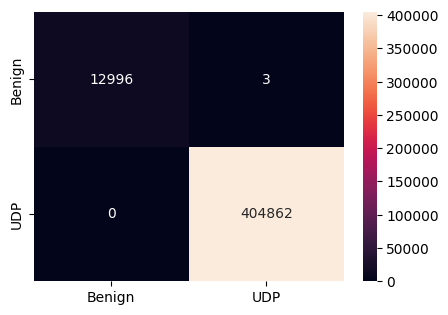





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           0    1     0  RF        1        1       1      1     1      1      1    5.42      6.284
 1  UDP           0    1     1  RF        1        1       1      1     1      1      1    5.428     6.148
 2  UDP           0    1     2  RF        1        1       1      1     1      1      1    5.359     6.274
 3  UDP           0    1     3  RF        1        1       1      1     1      1      1    5.528     6.492
 4  UDP           0    1     4  RF        1        1       1      1     1      1      1    5.483     6.343
 5  UDP           0    1     5  RF        1        1       1      1     1      1      1    5.624     6.224
 6  UDP           0    1     6  RF        1        1       1      1     1      1      1    5.532     6.412
 7  UDP           0    1     7  R

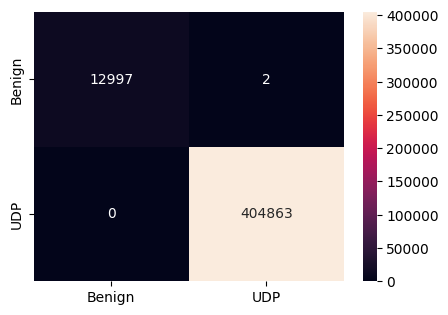





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  KNN       1    0.999       1  0.999  0.999  0.999  0.999    0.12     83.043
 1  UDP           0    1     1  KNN       1    0.999       1  0.999  0.999  0.999  0.999    0.123    84.213
 2  UDP           0    1     2  KNN       1    0.999       1  0.999  0.999  0.999  0.999    0.115    86.254
 3  UDP           0    1     3  KNN       1    0.999       1  0.999  0.999  0.999  0.999    0.126    83.595
 4  UDP           0    1     4  KNN       1    0.999       1  0.999  0.999  0.999  0.999    0.11     84.244
 5  UDP           0    1     5  KNN       1    0.999       1  0.999  0.999  0.999  0.999    0.125    82.93
 6  UDP           0    1     6  KNN       1    0.999       1  0.999  0.999  0.999  0.999    0.103    84.954
 7  UDP           0    1 

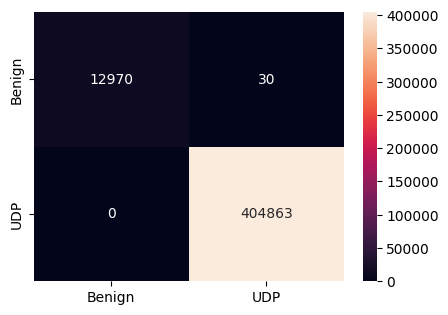





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  NB    0.998    0.968   0.999  0.968  0.983  0.966  0.968    0.031     0.338
 1  UDP           0    1     1  NB    0.998    0.968   0.999  0.968  0.983  0.966  0.968    0.006     0.345
 2  UDP           0    1     2  NB    0.998    0.968   0.999  0.968  0.983  0.966  0.968    0.015     0.345
 3  UDP           0    1     3  NB    0.998    0.968   0.999  0.968  0.983  0.966  0.968    0.017     0.314
 4  UDP           0    1     4  NB    0.998    0.968   0.999  0.968  0.983  0.966  0.968    0.016     0.424
 5  UDP           0    1     5  NB    0.998    0.968   0.999  0.968  0.983  0.966  0.968    0.016     0.439
 6  UDP           0    1     6  NB    0.998    0.968   0.999  0.968  0.983  0.966  0.968    0.013     0.267
 7  UDP           0    1

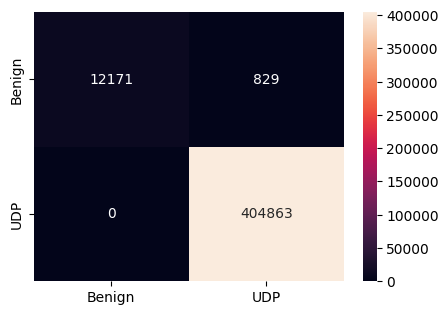





ARP
['ts', 'IP_version', 'IP_ihl', 'IP_tos', 'IP_DF', 'IP_ttl', 'IP_options', 'ICMP_code', 'TCP_reserved', 'TCP_flags', 'TCP_URG', 'TCP_ECE', 'TCP_CWR', 'TCP_urgptr', 'TCP_options', 'UDP_len', 'DNS_rd', 'DNS_qdcount', 'DNS_ancount', 'DNS_nscount', 'dport_class', 'entropy', 'dst_IP_diversity', 'pck_size_diff', 'pck_size_std_WE', 'ts_diff', 'payload_bytes_diff', 'payload_bytes_sum_of_EW', 'entropy_diff', 'entropy_mean_WE', 'entropy_std_WE', 'entropy_sum_of_EW', 'ts_mean_2', 'ts_std_2', 'payload_bytes_mean_2', 'payload_bytes_std_2', 'entropy_std_2', 'sport_sum', 'TCP_FIN_sum', 'TCP_SYN_sum', 'TCP_RST_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_RST_ratio', 'TCP_PSH_ratio', 'TCP_ACK_ratio', 'TCP_CWR_ratio', 'TCP_SYN_SR', 'TCP_PSH_SR', 'TCP_ECE_SR', 'TCP_CWR_SR', 'pck_size_std_6', 'ts_mean_6', 'ts_std_6', 'TCP_window_std_6', 'payload_bytes_mean_6', 'entropy_std_6', 'pck_size_std_9', 'ts_std_9', 'TCP_window_std_9', 'payload_bytes_mean_9', 'entropy_mean_9', 'entropy_std_9', 'Label']
    Dat

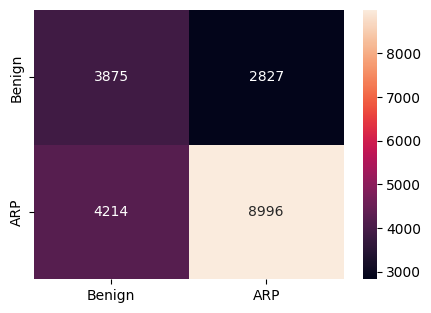





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  DT    0.704    0.629   0.664  0.629  0.635  0.281  0.629    0.507     0
 1  ARP           0    1     1  DT    0.674    0.608   0.625  0.608  0.611  0.228  0.608    0.479     0.001
 2  ARP           0    1     2  DT    0.746    0.689   0.718  0.689  0.698  0.4    0.689    0.498     0.016
 3  ARP           0    1     3  DT    0.706    0.626   0.666  0.626  0.632  0.277  0.626    0.52      0.007
 4  ARP           0    1     4  DT    0.704    0.626   0.664  0.626  0.632  0.275  0.626    0.514     0.003
 5  ARP           0    1     5  DT    0.744    0.687   0.715  0.687  0.695  0.394  0.687    0.484     0
 6  ARP           0    1     6  DT    0.739    0.683   0.708  0.683  0.691  0.385  0.683    0.524     0
 7  ARP           0    1     7  DT  

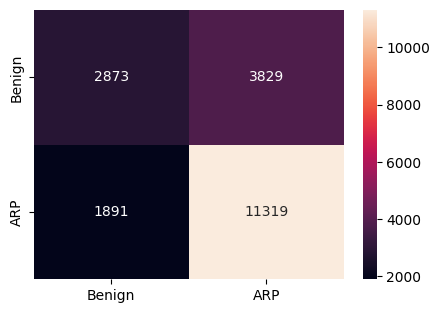





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  RF    0.716    0.623   0.69   0.623  0.627  0.278  0.623    4.304     0.352
 1  ARP           0    1     1  RF    0.717    0.625   0.691  0.625  0.63   0.283  0.625    4.384     0.391
 2  ARP           0    1     2  RF    0.709    0.612   0.68   0.612  0.613  0.255  0.612    4.1       0.347
 3  ARP           0    1     3  RF    0.707    0.608   0.678  0.608  0.609  0.248  0.608    4.285     0.353
 4  ARP           0    1     4  RF    0.713    0.618   0.685  0.618  0.621  0.268  0.618    4.37      0.37
 5  ARP           0    1     5  RF    0.722    0.633   0.697  0.633  0.64   0.3    0.633    4.286     0.329
 6  ARP           0    1     6  RF    0.712    0.614   0.687  0.614  0.616  0.261  0.614    4.236     0.333
 7  ARP           0    1 

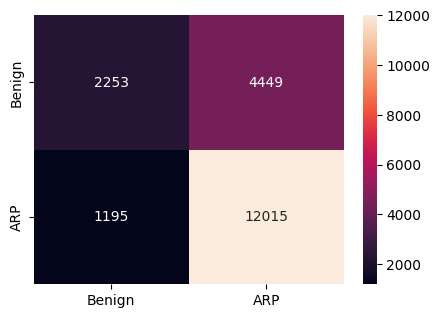





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  KNN   0.687    0.601    0.64  0.601  0.603  0.224  0.601    0.25      1.991
 1  ARP           0    1     1  KNN   0.687    0.601    0.64  0.601  0.603  0.224  0.601    0.211     1.863
 2  ARP           0    1     2  KNN   0.687    0.601    0.64  0.601  0.603  0.224  0.601    0.205     1.455
 3  ARP           0    1     3  KNN   0.687    0.601    0.64  0.601  0.603  0.224  0.601    0.236     1.989
 4  ARP           0    1     4  KNN   0.687    0.601    0.64  0.601  0.603  0.224  0.601    0.213     1.887
 5  ARP           0    1     5  KNN   0.687    0.601    0.64  0.601  0.603  0.224  0.601    0.205     1.836
 6  ARP           0    1     6  KNN   0.687    0.601    0.64  0.601  0.603  0.224  0.601    0.251     1.598
 7  ARP           0    1

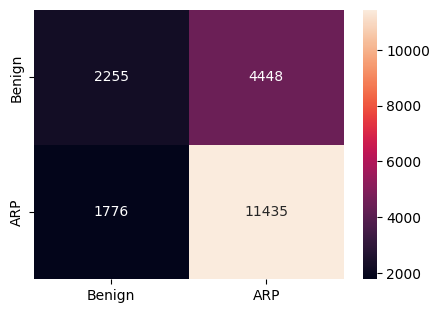





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  NB    0.731    0.626   0.739  0.626  0.628  0.295  0.626    0.016     0.031
 1  ARP           0    1     1  NB    0.731    0.626   0.739  0.626  0.628  0.295  0.626    0.032     0.031
 2  ARP           0    1     2  NB    0.731    0.626   0.739  0.626  0.628  0.295  0.626    0.016     0.031
 3  ARP           0    1     3  NB    0.731    0.626   0.739  0.626  0.628  0.295  0.626    0.016     0.063
 4  ARP           0    1     4  NB    0.731    0.626   0.739  0.626  0.628  0.295  0.626    0.026     0.021
 5  ARP           0    1     5  NB    0.731    0.626   0.739  0.626  0.628  0.295  0.626    0.016     0.031
 6  ARP           0    1     6  NB    0.731    0.626   0.739  0.626  0.628  0.295  0.626    0.024     0.031
 7  ARP           0    1

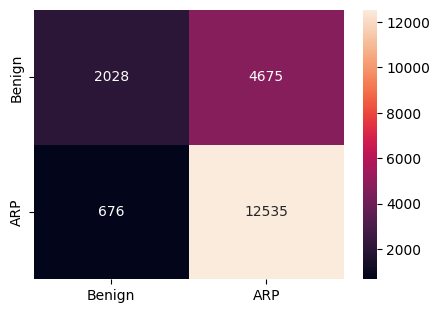





SP
['IP_flags', 'IP_DF', 'TCP_flags', 'TCP_SYN', 'TCP_ACK', 'dst_IP_diversity', 'entropy_std_WE', 'entropy_sum_of_EW', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'TCP_ACK_SR', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  LR    0.677    0.806   0.671  0.806  0.635  0.346  0.806    0.252     0
 1  SP            0    1     1  LR    0.677    0.806   0.671  0.806  0.635  0.346  0.806    0.236     0
 2  SP            0    1     2  LR    0.677    0.806   0.671  0.806  0.635  0.346  0.806    0.22      0.016
 3  SP            0    1     3  LR    0.677    0.806   0.671  0.806  0.635  0.346  0.806    0.22      0
 4  SP            0    1     4  LR    0.677    0.806   0.671  0.806  0.635  0.346  0.806    0.236     0
 5  SP            0    1     5  LR    0.677    0.806   0.671  0.806  0.635  0.346 

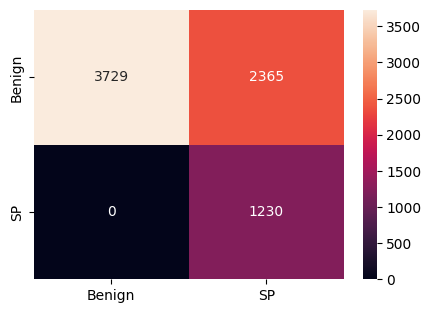





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  DT    0.882    0.929   0.794  0.929  0.832   0.67  0.929    0.016     0
 1  SP            0    1     1  DT    0.882    0.929   0.794  0.929  0.832   0.67  0.929    0.016     0
 2  SP            0    1     2  DT    0.882    0.929   0.794  0.929  0.832   0.67  0.929    0.018     0
 3  SP            0    1     3  DT    0.882    0.929   0.794  0.929  0.832   0.67  0.929    0.012     0
 4  SP            0    1     4  DT    1        1       1      1      1       1     1        0.016     0
 5  SP            0    1     5  DT    0.882    0.929   0.794  0.929  0.832   0.67  0.929    0.01      0.007
 6  SP            0    1     6  DT    0.882    0.929   0.794  0.929  0.832   0.67  0.929    0.012     0
 7  SP            0    1     7  DT    0.882    0

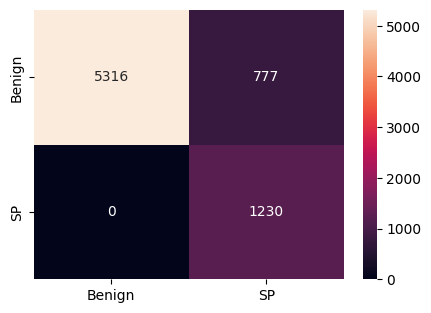





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SP            0    1     0  RF        1        1       1      1     1      1      1    0.427     0.029
 1  SP            0    1     1  RF        1        1       1      1     1      1      1    0.456     0.031
 2  SP            0    1     2  RF        1        1       1      1     1      1      1    0.459     0.049
 3  SP            0    1     3  RF        1        1       1      1     1      1      1    0.405     0.04
 4  SP            0    1     4  RF        1        1       1      1     1      1      1    0.425     0.054
 5  SP            0    1     5  RF        1        1       1      1     1      1      1    0.416     0.047
 6  SP            0    1     6  RF        1        1       1      1     1      1      1    0.42      0.038
 7  SP            0    1     7  RF

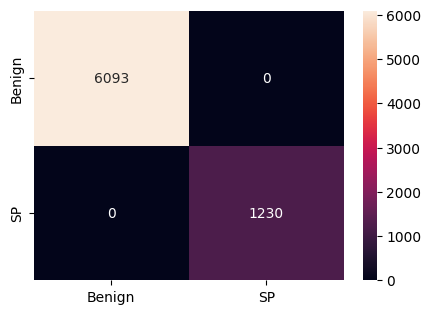





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SP            0    1     0  KNN       1        1   0.999      1     1  0.999      1    0.041     0.283
 1  SP            0    1     1  KNN       1        1   0.999      1     1  0.999      1    0.03      0.412
 2  SP            0    1     2  KNN       1        1   0.999      1     1  0.999      1    0.031     0.388
 3  SP            0    1     3  KNN       1        1   0.999      1     1  0.999      1    0.032     0.398
 4  SP            0    1     4  KNN       1        1   0.999      1     1  0.999      1    0.032     0.33
 5  SP            0    1     5  KNN       1        1   0.999      1     1  0.999      1    0.031     0.394
 6  SP            0    1     6  KNN       1        1   0.999      1     1  0.999      1    0.027     0.383
 7  SP            0    1     7  KN

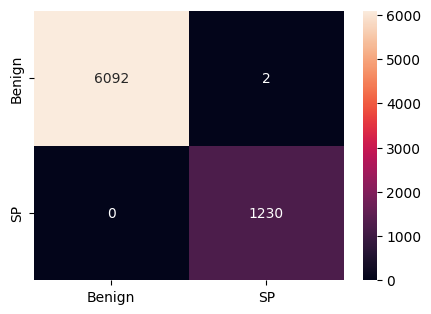





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  NB    0.984    0.991   0.958  0.991  0.973  0.946  0.991    0.018     0.001
 1  SP            0    1     1  NB    0.984    0.991   0.958  0.991  0.973  0.946  0.991    0         0
 2  SP            0    1     2  NB    0.984    0.991   0.958  0.991  0.973  0.946  0.991    0         0
 3  SP            0    1     3  NB    0.984    0.991   0.958  0.991  0.973  0.946  0.991    0         0
 4  SP            0    1     4  NB    0.984    0.991   0.958  0.991  0.973  0.946  0.991    0         0
 5  SP            0    1     5  NB    0.984    0.991   0.958  0.991  0.973  0.946  0.991    0.002     0.002
 6  SP            0    1     6  NB    0.984    0.991   0.958  0.991  0.973  0.946  0.991    0.015     0
 7  SP            0    1     7  NB    0.984 

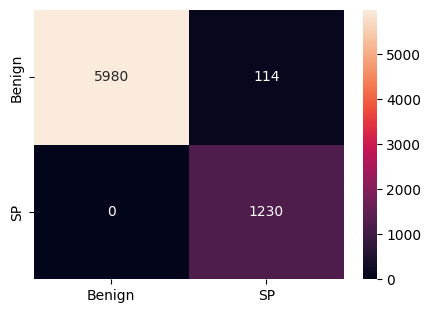





BF
['ts', 'TCP_window_sum_of_EW', 'entropy_mean_WE', 'pck_size_std_2', 'TCP_window_mean_2', 'TCP_window_std_2', 'payload_bytes_mean_2', 'sport_sum', 'TCP_FIN_sum', 'TCP_FIN_SR', 'pck_size_mean_6', 'pck_size_std_6', 'ts_std_6', 'TCP_window_mean_6', 'TCP_window_std_6', 'payload_bytes_mean_6', 'payload_bytes_std_6', 'ts_mean_9', 'ts_std_9', 'TCP_window_mean_9', 'TCP_window_std_9', 'payload_bytes_mean_9', 'payload_bytes_std_9', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  LR    0.994    0.507   0.585  0.507  0.512  0.025  0.507    0.063     0
 1  BF            0    1     1  LR    0.994    0.517   0.586  0.517  0.527  0.055  0.517    0.047     0
 2  BF            0    1     2  LR    0.994    0.526   0.621  0.526  0.541  0.084  0.526    0.048     0.012
 3  BF            0    1   

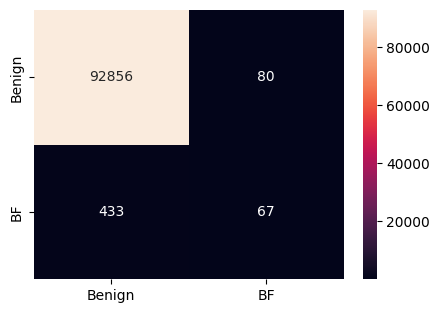





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  DT    0.828    0.87    0.514  0.87   0.479  0.044  0.87     0.041     0.016
 1  BF            0    1     1  DT    0.84     0.888   0.515  0.888  0.486  0.049  0.888    0.03      0.01
 2  BF            0    1     2  DT    0.828    0.875   0.514  0.875  0.48   0.044  0.875    0.045     0.01
 3  BF            0    1     3  DT    0.828    0.875   0.514  0.875  0.48   0.044  0.875    0.048     0.015
 4  BF            0    1     4  DT    0.828    0.87    0.514  0.87   0.479  0.044  0.87     0.043     0.013
 5  BF            0    1     5  DT    0.839    0.874   0.514  0.874  0.485  0.047  0.874    0.031     0.016
 6  BF            0    1     6  DT    0.828    0.875   0.514  0.875  0.48   0.044  0.875    0.031     0.016
 7  BF            0    1  

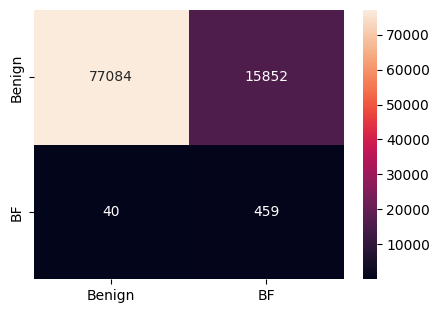





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  RF    0.999    0.964   0.979  0.964  0.971  0.943  0.964    1.621     1.406
 1  BF            0    1     1  RF    0.999    0.962   0.974  0.962  0.968  0.936  0.962    2.368     1.34
 2  BF            0    1     2  RF    0.999    0.962   0.968  0.962  0.965  0.93   0.962    2.503     1.412
 3  BF            0    1     3  RF    0.999    0.96    0.966  0.96   0.963  0.926  0.96     2.394     1.321
 4  BF            0    1     4  RF    0.999    0.962   0.974  0.962  0.968  0.936  0.962    2.546     1.382
 5  BF            0    1     5  RF    0.999    0.962   0.966  0.962  0.964  0.927  0.962    2.386     1.653
 6  BF            0    1     6  RF    0.999    0.965   0.916  0.965  0.939  0.879  0.965    2.441     1.281
 7  BF            0    1 

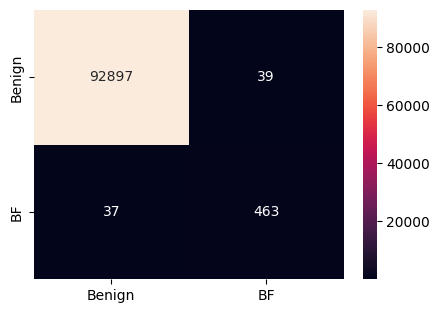





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  KNN   0.991    0.812   0.665  0.812  0.715  0.431  0.812    0.093     1.786
 1  BF            0    1     1  KNN   0.991    0.812   0.665  0.812  0.715  0.431  0.812    0.094     1.809
 2  BF            0    1     2  KNN   0.991    0.812   0.665  0.812  0.715  0.431  0.812    0.082     1.881
 3  BF            0    1     3  KNN   0.991    0.812   0.665  0.812  0.715  0.431  0.812    0.093     1.711
 4  BF            0    1     4  KNN   0.991    0.812   0.665  0.812  0.715  0.431  0.812    0.094     1.815
 5  BF            0    1     5  KNN   0.991    0.812   0.665  0.812  0.715  0.431  0.812    0.09      1.73
 6  BF            0    1     6  KNN   0.991    0.812   0.665  0.812  0.715  0.431  0.812    0.082     1.774
 7  BF            0    1 

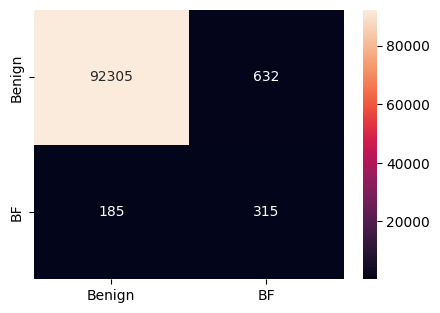





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  NB    0.976    0.832    0.57  0.832  0.612  0.228  0.832    0.016     0.063
 1  BF            0    1     1  NB    0.976    0.832    0.57  0.832  0.612  0.228  0.832    0.016     0.079
 2  BF            0    1     2  NB    0.976    0.832    0.57  0.832  0.612  0.228  0.832    0.016     0.094
 3  BF            0    1     3  NB    0.976    0.832    0.57  0.832  0.612  0.228  0.832    0.004     0.1
 4  BF            0    1     4  NB    0.976    0.832    0.57  0.832  0.612  0.228  0.832    0.01      0.063
 5  BF            0    1     5  NB    0.976    0.832    0.57  0.832  0.612  0.228  0.832    0.016     0.078
 6  BF            0    1     6  NB    0.976    0.832    0.57  0.832  0.612  0.228  0.832    0.016     0.079
 7  BF            0    1  

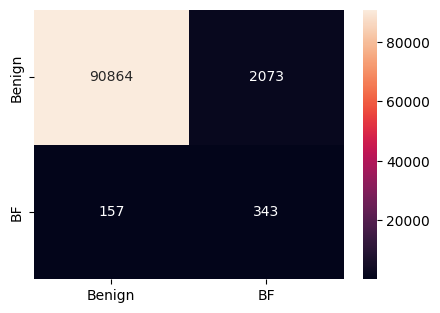





OS
['TCP_flags', 'TCP_SYN', 'TCP_ACK', 'TCP_URG', 'TCP_window', 'TCP_urgptr', 'UDP_len', 'entropy', 'Protocol', 'dst_port_diversity', 'pck_size_mean_WE', 'pck_size_std_WE', 'ts_diff', 'ts_std_WE', 'ts_sum_of_EW', 'TCP_window_std_WE', 'payload_bytes_diff', 'payload_bytes_mean_WE', 'payload_bytes_std_WE', 'entropy_mean_WE', 'entropy_std_WE', 'entropy_sum_of_EW', 'ts_mean_2', 'payload_bytes_std_2', 'dport_sum', 'TCP_SYN_sum', 'TCP_PSH_sum', 'TCP_ACK_sum', 'TCP_URG_sum', 'TCP_FIN_ratio', 'TCP_PSH_ratio', 'TCP_ACK_ratio', 'sum', 'TCP_FIN_SR', 'TCP_SYN_SR', 'TCP_PSH_SR', 'TCP_ACK_SR', 'TCP_URG_SR', 'TCP_ECE_SR', 'TCP_CWR_SR', 'pck_size_mean_6', 'pck_size_std_6', 'ts_mean_6', 'ts_std_6', 'payload_bytes_mean_6', 'entropy_mean_6', 'pck_size_mean_9', 'ts_mean_9', 'payload_bytes_mean_9', 'entropy_mean_9', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----

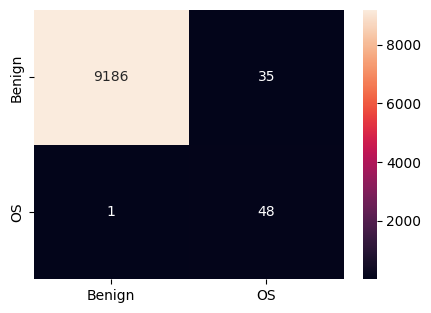





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  OS            0    1     0  DT    0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.079         0
 1  OS            0    1     1  DT    0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.031         0
 2  OS            0    1     2  DT    0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.031         0
 3  OS            0    1     3  DT    0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.027         0
 4  OS            0    1     4  DT    0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.047         0
 5  OS            0    1     5  DT    0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.063         0
 6  OS            0    1     6  DT    0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.047         0
 7  OS            0    1     7  D

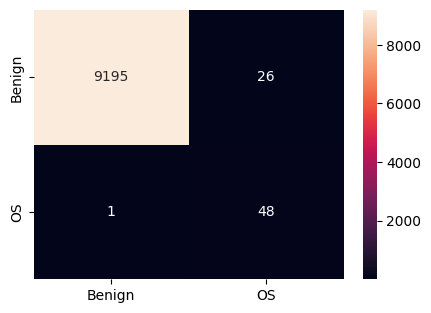





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  OS            0    1     0  RF    0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.267     0.016
 1  OS            0    1     1  RF    0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.299     0.031
 2  OS            0    1     2  RF    0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.298     0.016
 3  OS            0    1     3  RF    0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.267     0.031
 4  OS            0    1     4  RF    0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.314     0.031
 5  OS            0    1     5  RF    0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.298     0.025
 6  OS            0    1     6  RF    0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.298     0.016
 7  OS            0    1     7  R

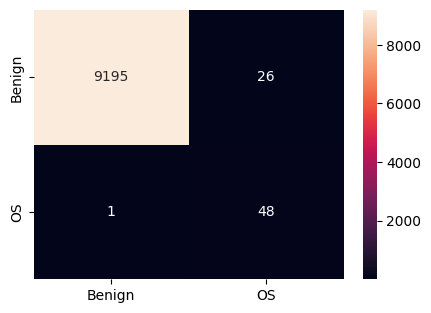





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  KNN   0.771    0.509     0.5  0.509  0.441  0.001  0.509    0.094     0.424
 1  OS            0    1     1  KNN   0.771    0.509     0.5  0.509  0.441  0.001  0.509    0.094     0.409
 2  OS            0    1     2  KNN   0.771    0.509     0.5  0.509  0.441  0.001  0.509    0.094     0.424
 3  OS            0    1     3  KNN   0.771    0.509     0.5  0.509  0.441  0.001  0.509    0.095     0.439
 4  OS            0    1     4  KNN   0.771    0.509     0.5  0.509  0.441  0.001  0.509    0.078     0.392
 5  OS            0    1     5  KNN   0.771    0.509     0.5  0.509  0.441  0.001  0.509    0.094     0.393
 6  OS            0    1     6  KNN   0.771    0.509     0.5  0.509  0.441  0.001  0.509    0.078     0.407
 7  OS            0    1

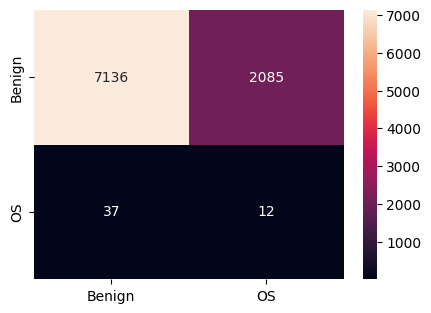





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  NB    0.972    0.905   0.569  0.905  0.612  0.231  0.905    0.016     0.016
 1  OS            0    1     1  NB    0.972    0.905   0.569  0.905  0.612  0.231  0.905    0.016     0.016
 2  OS            0    1     2  NB    0.972    0.905   0.569  0.905  0.612  0.231  0.905    0         0.016
 3  OS            0    1     3  NB    0.972    0.905   0.569  0.905  0.612  0.231  0.905    0.016     0.016
 4  OS            0    1     4  NB    0.972    0.905   0.569  0.905  0.612  0.231  0.905    0.016     0.016
 5  OS            0    1     5  NB    0.972    0.905   0.569  0.905  0.612  0.231  0.905    0.016     0.016
 6  OS            0    1     6  NB    0.972    0.905   0.569  0.905  0.612  0.231  0.905    0.016     0.016
 7  OS            0    1

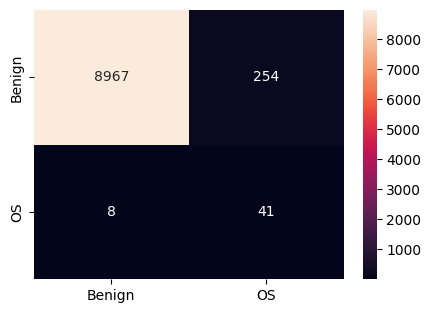





SCHD
['ts', 'Ether_type', 'IP_version', 'IP_ihl', 'TCP_dataofs', 'TCP_flags', 'TCP_ACK', 'TCP_options', 'sport_class', 'dport_class', 'pck_size_sum_of_EW', 'ts_mean_WE', 'ts_sum_of_EW', 'TCP_window_mean_WE', 'TCP_window_sum_of_EW', 'payload_bytes_mean_WE', 'payload_bytes_std_WE', 'payload_bytes_sum_of_EW', 'entropy_std_WE', 'TCP_PSH_sum', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'sum', 'pck_size_mean_6', 'ts_mean_6', 'ts_std_6', 'pck_size_mean_9', 'ts_mean_9', 'ts_std_9', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  LR    0.999    0.999   0.772  0.999  0.852  0.703  0.999    0.236     0.016
 1  SCHD          0    1     1  LR    0.999    0.999   0.772  0.999  0.852  0.703  0.999    0.204     0
 2  SCHD          0    1     2  LR    0.999    0.999   0.772  0.999  0.852  0.703  0.999   

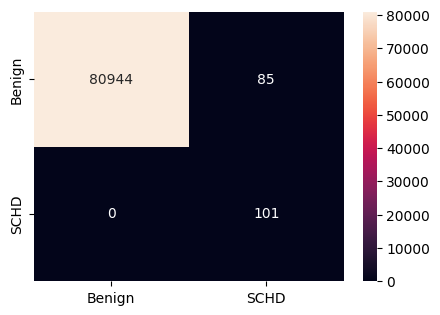





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  DT    0.998    0.999   0.687  0.999  0.772  0.544  0.999    0.032     0
 1  SCHD          0    1     1  DT    0.999    0.999   0.751  0.999  0.834  0.668  0.999    0.019     0.03
 2  SCHD          0    1     2  DT    0.999    0.999   0.751  0.999  0.834  0.668  0.999    0.022     0.016
 3  SCHD          0    1     3  DT    0.999    0.999   0.751  0.999  0.834  0.668  0.999    0.016     0.016
 4  SCHD          0    1     4  DT    0.998    0.999   0.693  0.999  0.778  0.556  0.999    0.025     0.007
 5  SCHD          0    1     5  DT    0.999    0.999   0.751  0.999  0.834  0.668  0.999    0.016     0.016
 6  SCHD          0    1     6  DT    0.998    0.999   0.687  0.999  0.772  0.544  0.999    0.031     0.016
 7  SCHD          0    1     

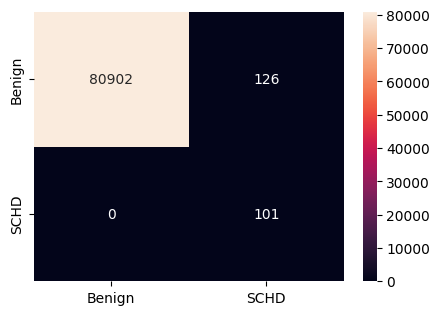





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  RF    0.999    0.703   0.894  0.703  0.768  0.536  0.703    1.124     0.601
 1  SCHD          0    1     1  RF    0.999    0.703   1      0.703  0.789  0.577  0.703    1.163     0.599
 2  SCHD          0    1     2  RF    0.999    0.703   0.918  0.703  0.773  0.546  0.703    1.042     0.616
 3  SCHD          0    1     3  RF    0.999    0.703   0.894  0.703  0.768  0.536  0.703    1.089     0.599
 4  SCHD          0    1     4  RF    0.999    0.703   1      0.703  0.789  0.577  0.703    1.159     0.645
 5  SCHD          0    1     5  RF    0.999    0.703   0.894  0.703  0.768  0.536  0.703    1.146     0.613
 6  SCHD          0    1     6  RF    0.999    0.703   1      0.703  0.789  0.577  0.703    0.99      0.614
 7  SCHD          0    1

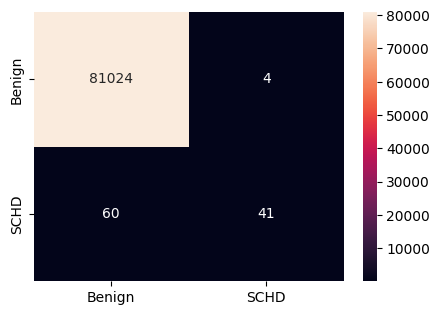





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  KNN   0.998    0.999   0.716  0.999  0.801  0.602  0.999    0.059     5.495
 1  SCHD          0    1     1  KNN   0.998    0.999   0.716  0.999  0.801  0.602  0.999    0.057     5.504
 2  SCHD          0    1     2  KNN   0.998    0.999   0.716  0.999  0.801  0.602  0.999    0.063     5.38
 3  SCHD          0    1     3  KNN   0.998    0.999   0.716  0.999  0.801  0.602  0.999    0.056     5.73
 4  SCHD          0    1     4  KNN   0.998    0.999   0.716  0.999  0.801  0.602  0.999    0.063     5.597
 5  SCHD          0    1     5  KNN   0.998    0.999   0.716  0.999  0.801  0.602  0.999    0.063     5.558
 6  SCHD          0    1     6  KNN   0.998    0.999   0.716  0.999  0.801  0.602  0.999    0.058     5.231
 7  SCHD          0    1  

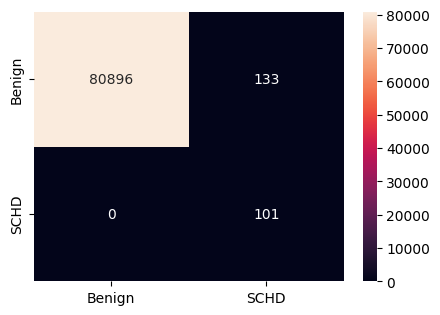





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  NB    0.986    0.993    0.54  0.993  0.571  0.147  0.993    0.006     0.102
 1  SCHD          0    1     1  NB    0.986    0.993    0.54  0.993  0.571  0.147  0.993    0.001     0.101
 2  SCHD          0    1     2  NB    0.986    0.993    0.54  0.993  0.571  0.147  0.993    0.006     0.083
 3  SCHD          0    1     3  NB    0.986    0.993    0.54  0.993  0.571  0.147  0.993    0.016     0.064
 4  SCHD          0    1     4  NB    0.986    0.993    0.54  0.993  0.571  0.147  0.993    0         0.111
 5  SCHD          0    1     5  NB    0.986    0.993    0.54  0.993  0.571  0.147  0.993    0.015     0.095
 6  SCHD          0    1     6  NB    0.986    0.993    0.54  0.993  0.571  0.147  0.993    0         0.085
 7  SCHD          0    1

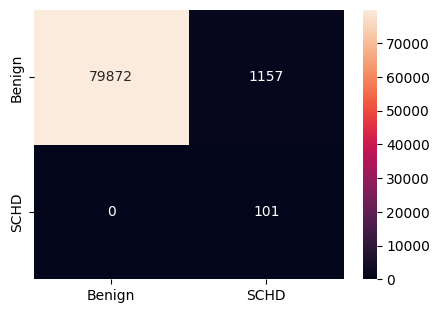





MHDis
['ts', 'IP_version', 'IP_flags', 'IP_proto', 'TCP_dataofs', 'TCP_options', 'sport_class', 'dport_class', 'Protocol', 'pck_size_mean_WE', 'pck_size_std_WE', 'ts_mean_WE', 'ts_sum_of_EW', 'TCP_window_sum_of_EW', 'ts_mean_2', 'ts_std_2', 'pck_size_mean_6', 'ts_mean_6', 'pck_size_mean_9', 'ts_mean_9', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  LR    0.998    0.999   0.989  0.999  0.994  0.988  0.999    0.229     0
 1  MHDis         0    1     1  LR    0.998    0.999   0.989  0.999  0.994  0.988  0.999    0.233     0
 2  MHDis         0    1     2  LR    0.998    0.999   0.989  0.999  0.994  0.988  0.999    0.183     0
 3  MHDis         0    1     3  LR    0.998    0.999   0.989  0.999  0.994  0.988  0.999    0.201     0.001
 4  MHDis         0    1     4  LR    0.998   

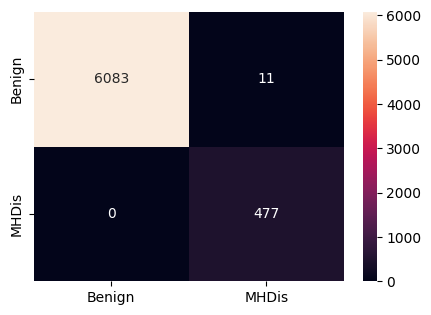





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  DT    0.995    0.964   0.997  0.964  0.98   0.96   0.964    0.031     0
 1  MHDis         0    1     1  DT    0.995    0.964   0.997  0.964  0.98   0.96   0.964    0.032     0.001
 2  MHDis         0    1     2  DT    0.995    0.968   0.997  0.968  0.982  0.964  0.968    0.018     0
 3  MHDis         0    1     3  DT    0.995    0.964   0.997  0.964  0.98   0.96   0.964    0.018     0
 4  MHDis         0    1     4  DT    0.995    0.968   0.997  0.968  0.982  0.964  0.968    0.018     0.001
 5  MHDis         0    1     5  DT    0.995    0.964   0.997  0.964  0.98   0.96   0.964    0.023     0
 6  MHDis         0    1     6  DT    0.995    0.968   0.997  0.968  0.982  0.964  0.968    0.024     0
 7  MHDis         0    1     7  DT    0.995 

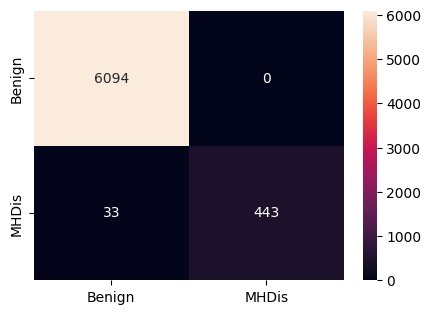





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  RF    0.995    0.967   0.996  0.967  0.981  0.963  0.967    0.569     0.032
 1  MHDis         0    1     1  RF    0.995    0.967   0.996  0.967  0.981  0.963  0.967    0.553     0.045
 2  MHDis         0    1     2  RF    0.995    0.964   0.996  0.964  0.98   0.959  0.964    0.547     0.036
 3  MHDis         0    1     3  RF    0.995    0.967   0.996  0.967  0.981  0.963  0.967    0.594     0.05
 4  MHDis         0    1     4  RF    0.995    0.967   0.996  0.967  0.981  0.963  0.967    0.573     0.031
 5  MHDis         0    1     5  RF    0.995    0.967   0.996  0.967  0.981  0.963  0.967    0.582     0.034
 6  MHDis         0    1     6  RF    0.995    0.967   0.996  0.967  0.981  0.963  0.967    0.565     0.031
 7  MHDis         0    1 

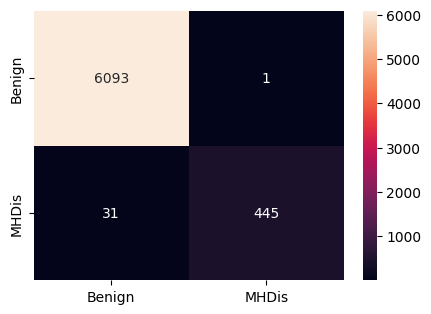





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  KNN   0.998    0.999   0.986  0.999  0.992  0.984  0.999    0.035     0.047
 1  MHDis         0    1     1  KNN   0.998    0.999   0.986  0.999  0.992  0.984  0.999    0.034     0.031
 2  MHDis         0    1     2  KNN   0.998    0.999   0.986  0.999  0.992  0.984  0.999    0.027     0.047
 3  MHDis         0    1     3  KNN   0.998    0.999   0.986  0.999  0.992  0.984  0.999    0.031     0.042
 4  MHDis         0    1     4  KNN   0.998    0.999   0.986  0.999  0.992  0.984  0.999    0.039     0.053
 5  MHDis         0    1     5  KNN   0.998    0.999   0.986  0.999  0.992  0.984  0.999    0.045     0.048
 6  MHDis         0    1     6  KNN   0.998    0.999   0.986  0.999  0.992  0.984  0.999    0.033     0.052
 7  MHDis         0    1

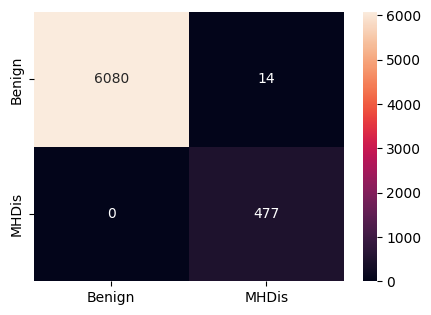





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  NB    0.334    0.641   0.549  0.641  0.309  0.054  0.641    0.007     0.007
 1  MHDis         0    1     1  NB    0.334    0.641   0.549  0.641  0.309  0.054  0.641    0.006     0.006
 2  MHDis         0    1     2  NB    0.334    0.641   0.549  0.641  0.309  0.054  0.641    0.006     0.005
 3  MHDis         0    1     3  NB    0.334    0.641   0.549  0.641  0.309  0.054  0.641    0         0.019
 4  MHDis         0    1     4  NB    0.334    0.641   0.549  0.641  0.309  0.054  0.641    0.016     0
 5  MHDis         0    1     5  NB    0.334    0.641   0.549  0.641  0.309  0.054  0.641    0.016     0
 6  MHDis         0    1     6  NB    0.334    0.641   0.549  0.641  0.309  0.054  0.641    0.008     0
 7  MHDis         0    1     7  NB  

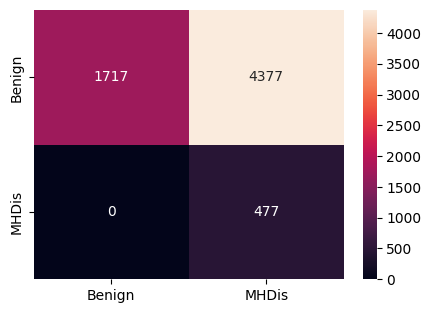

In [22]:
folder("results/val/")

for file in file_list:
    print(file)
    feature=feature_list[file]
    train=file_list[file][0]
    test=file_list[file][1]
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/val/{file}_VAL_chosed_output_ML_.csv"
    target_names=["Benign",file]
    ML(train,test,output_csv,feature,file,0)   


# TEST

In [23]:
file_list={'SYN': ['./INPUT/SM/DoS-SYN-1.csv',  './INPUT/TEST/small_Edge_IIoT_DDoS_TCP_SYN_Flood_Attacks_00000_20211124180237._SW.csv'],
 'HTTP': ['./INPUT/SM/MB-HTTP-4.csv',  './INPUT/TEST/NetatmoCamHTTPFlood_1_SW.csv'],
'ACK': ['./INPUT/SM/MB-ACK-4.csv',  './INPUT/TEST/NetatmoCamTCPFlood_3_SW.csv'],
 'UDP': ['./INPUT/SM/MB-UDP-4.csv',  './INPUT/TEST/Bot_IoT_UDP_DDoS_00001._SW.csv'],
 'ARP': ['./INPUT/SM/MitM-ARP-6.csv',   './INPUT/TEST/Kitsune_ARP_MitM._SW.csv'],
 'SP': ['./INPUT/SM/Scan-Port-3.csv', './INPUT/TEST/IoT_ENV_[Port_scan]Google_Home_Mini_SW.csv'],
 'BF': ['./INPUT/SM/MB-BF-5.csv',  './INPUT/TEST/AmcrestCamBruteForce_1_SW.csv'],
 'OS': ['./INPUT/SM/Scan-OS-3.csv',  './INPUT/TEST/IoT_ENV_[OS_Service_Detection]Google_Home_Mini_SW.csv'],
"SCHD":['./INPUT/SM/Scan-HDis-3.csv','./INPUT/SM/MB-HDis-3.csv'],
"MHDis":['./INPUT/SM/MB-HDis-3.csv','./INPUT/SM/Scan-HDis-3.csv' ]}

SYN
['ts', 'IP_flags', 'IP_DF', 'TCP_SYN', 'TCP_ACK', 'sport_class', 'dst_IP_diversity', 'IP_add_count', 'pck_size_std_WE', 'pck_size_sum_of_EW', 'ts_mean_WE', 'TCP_window_std_WE', 'pck_size_mean_2', 'TCP_window_mean_2', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_ACK_ratio', 'TCP_SYN_SR', 'TCP_ACK_SR', 'pck_size_mean_6', 'ts_mean_6', 'TCP_window_mean_6', 'ts_mean_9', 'ts_std_9', 'TCP_window_mean_9', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           1    1     0  LR        1        1       1      1  1      0.999      1    0.055     0
 1  SYN           1    1     1  LR        1        1       1      1  1      0.999      1    0.076     0.003
 2  SYN           1    1     2  LR        1        1       1      1  1      0.999      1    0.042     0.01
 3  SYN           1    1     3  LR        1 

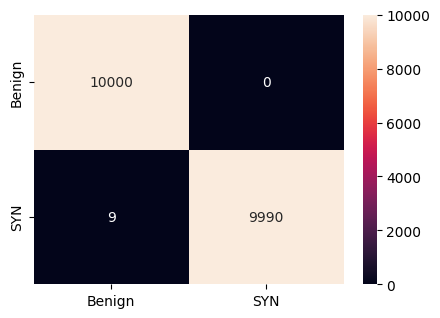





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SYN           1    1     0  DT        1        1       1      1     1      1      1    0.018     0
 1  SYN           1    1     1  DT        1        1       1      1     1      1      1    0.032     0.003
 2  SYN           1    1     2  DT        1        1       1      1     1      1      1    0.024     0.003
 3  SYN           1    1     3  DT        1        1       1      1     1      1      1    0.032     0.003
 4  SYN           1    1     4  DT        1        1       1      1     1      1      1    0.019     0.007
 5  SYN           1    1     5  DT        1        1       1      1     1      1      1    0.025     0.004
 6  SYN           1    1     6  DT        1        1       1      1     1      1      1    0.028     0.003
 7  SYN           1    1     7  DT   

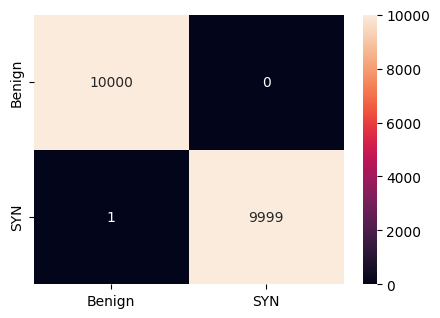





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SYN           1    1     0  RF        1        1       1      1     1      1      1    0.431     0.063
 1  SYN           1    1     1  RF        1        1       1      1     1      1      1    0.451     0.07
 2  SYN           1    1     2  RF        1        1       1      1     1      1      1    0.436     0.061
 3  SYN           1    1     3  RF        1        1       1      1     1      1      1    0.46      0.061
 4  SYN           1    1     4  RF        1        1       1      1     1      1      1    0.394     0.069
 5  SYN           1    1     5  RF        1        1       1      1     1      1      1    0.445     0.056
 6  SYN           1    1     6  RF        1        1       1      1     1      1      1    0.449     0.056
 7  SYN           1    1     7  RF

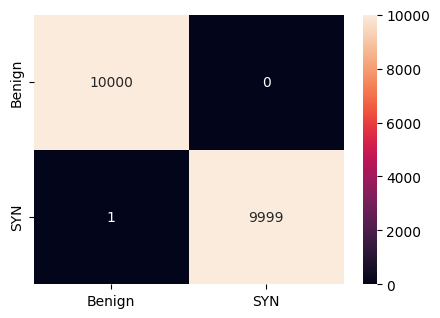





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           1    1     0  KNN     0.5      0.5    0.25    0.5  0.333      0    0.5    0.009     1.581
 1  SYN           1    1     1  KNN     0.5      0.5    0.25    0.5  0.333      0    0.5    0         1.695
 2  SYN           1    1     2  KNN     0.5      0.5    0.25    0.5  0.333      0    0.5    0         1.658
 3  SYN           1    1     3  KNN     0.5      0.5    0.25    0.5  0.333      0    0.5    0         1.732
 4  SYN           1    1     4  KNN     0.5      0.5    0.25    0.5  0.333      0    0.5    0.016     1.733
 5  SYN           1    1     5  KNN     0.5      0.5    0.25    0.5  0.333      0    0.5    0         1.71
 6  SYN           1    1     6  KNN     0.5      0.5    0.25    0.5  0.333      0    0.5    0.016     1.666
 7  SYN           1    1 

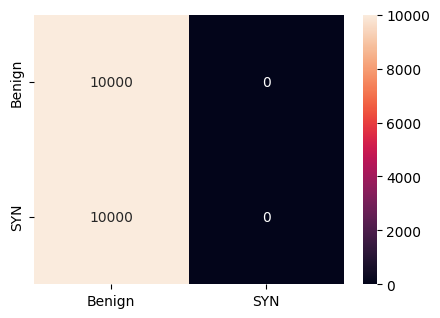





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           1    1     0  NB    0.998    0.998   0.998  0.998  0.998  0.996  0.998    0.023     0.015
 1  SYN           1    1     1  NB    0.998    0.998   0.998  0.998  0.998  0.996  0.998    0.016     0.032
 2  SYN           1    1     2  NB    0.998    0.998   0.998  0.998  0.998  0.996  0.998    0.016     0.016
 3  SYN           1    1     3  NB    0.998    0.998   0.998  0.998  0.998  0.996  0.998    0.004     0.031
 4  SYN           1    1     4  NB    0.998    0.998   0.998  0.998  0.998  0.996  0.998    0.014     0.022
 5  SYN           1    1     5  NB    0.998    0.998   0.998  0.998  0.998  0.996  0.998    0.014     0.035
 6  SYN           1    1     6  NB    0.998    0.998   0.998  0.998  0.998  0.996  0.998    0.006     0.023
 7  SYN           1    1

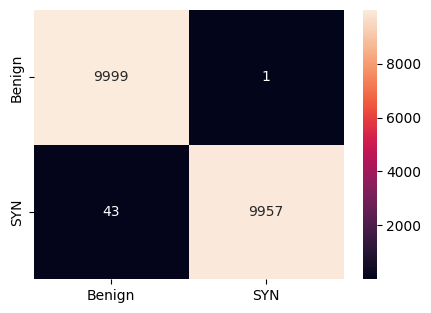





HTTP
['TCP_flags', 'dport_class', 'pck_size_sum_of_EW', 'ts_std_WE', 'ts_sum_of_EW', 'payload_bytes_sum_of_EW', 'entropy_mean_WE', 'TCP_window_mean_2', 'sport_sum', 'TCP_ACK_ratio', 'sum', 'TCP_PSH_SR', 'ts_std_6', 'entropy_mean_6', 'TCP_window_mean_9', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          1    1     0  LR      0.5      0.5    0.25    0.5  0.333     -0    0.5    0.492     0.004
 1  HTTP          1    1     1  LR      0.5      0.5    0.25    0.5  0.333     -0    0.5    0.412     0
 2  HTTP          1    1     2  LR      0.5      0.5    0.25    0.5  0.333     -0    0.5    0.452     0.001
 3  HTTP          1    1     3  LR      0.5      0.5    0.25    0.5  0.333     -0    0.5    0.452     0.001
 4  HTTP          1    1     4  LR      0.5      0.5    0.25    0.5  0.333     -0    0.5 

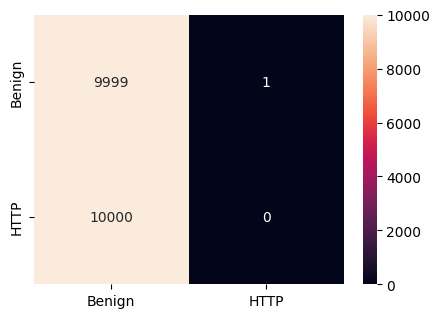





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          1    1     0  DT    1        1       1      1      1      1      1        0.048     0
 1  HTTP          1    1     1  DT    1        1       1      1      1      1      1        0.063     0.003
 2  HTTP          1    1     2  DT    1        1       1      1      1      1      1        0.048     0.006
 3  HTTP          1    1     3  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.055     0
 4  HTTP          1    1     4  DT    1        1       1      1      1      1      1        0.032     0.006
 5  HTTP          1    1     5  DT    0.55     0.55    0.763  0.55   0.436  0.101  0.55     0.031     0
 6  HTTP          1    1     6  DT    1        1       1      1      1      1      1        0.047     0
 7  HTTP          1    1     7  DT    1 

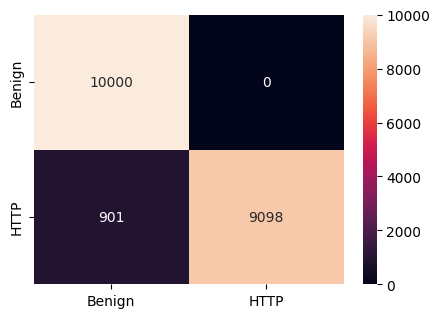





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  HTTP          1    1     0  RF        1        1       1      1     1      1      1    2.741     0.157
 1  HTTP          1    1     1  RF        1        1       1      1     1      1      1    2.824     0.173
 2  HTTP          1    1     2  RF        1        1       1      1     1      1      1    2.666     0.173
 3  HTTP          1    1     3  RF        1        1       1      1     1      1      1    2.696     0.173
 4  HTTP          1    1     4  RF        1        1       1      1     1      1      1    2.72      0.173
 5  HTTP          1    1     5  RF        1        1       1      1     1      1      1    2.473     0.168
 6  HTTP          1    1     6  RF        1        1       1      1     1      1      1    2.765     0.184
 7  HTTP          1    1     7  R

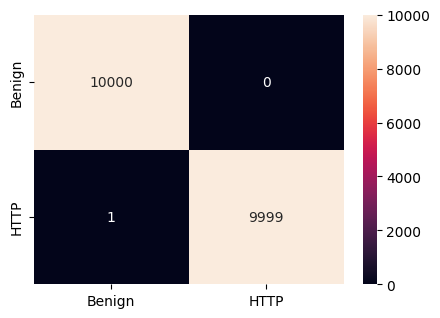





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          1    1     0  KNN    0.52     0.52   0.755   0.52  0.377   0.04   0.52    0.07      0.739
 1  HTTP          1    1     1  KNN    0.52     0.52   0.755   0.52  0.377   0.04   0.52    0.066     0.736
 2  HTTP          1    1     2  KNN    0.52     0.52   0.755   0.52  0.377   0.04   0.52    0.047     0.742
 3  HTTP          1    1     3  KNN    0.52     0.52   0.755   0.52  0.377   0.04   0.52    0.074     0.736
 4  HTTP          1    1     4  KNN    0.52     0.52   0.755   0.52  0.377   0.04   0.52    0.069     0.75
 5  HTTP          1    1     5  KNN    0.52     0.52   0.755   0.52  0.377   0.04   0.52    0.067     0.632
 6  HTTP          1    1     6  KNN    0.52     0.52   0.755   0.52  0.377   0.04   0.52    0.068     0.723
 7  HTTP          1    1 

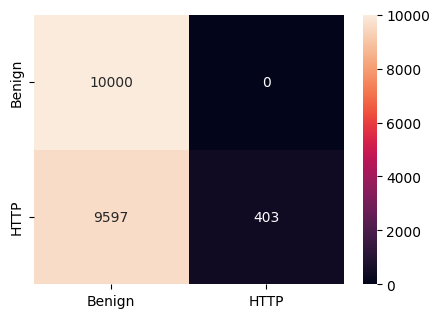





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          1    1     0  NB     0.52     0.52   0.734   0.52  0.377   0.04   0.52    0.009     0.011
 1  HTTP          1    1     1  NB     0.52     0.52   0.734   0.52  0.377   0.04   0.52    0.01      0.011
 2  HTTP          1    1     2  NB     0.52     0.52   0.734   0.52  0.377   0.04   0.52    0.012     0.013
 3  HTTP          1    1     3  NB     0.52     0.52   0.734   0.52  0.377   0.04   0.52    0.011     0.013
 4  HTTP          1    1     4  NB     0.52     0.52   0.734   0.52  0.377   0.04   0.52    0.012     0.014
 5  HTTP          1    1     5  NB     0.52     0.52   0.734   0.52  0.377   0.04   0.52    0.007     0.009
 6  HTTP          1    1     6  NB     0.52     0.52   0.734   0.52  0.377   0.04   0.52    0.012     0.012
 7  HTTP          1    1

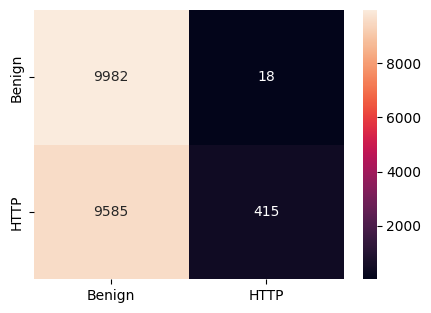





ACK
['ts_std_WE', 'TCP_window_sum_of_EW', 'payload_bytes_mean_WE', 'payload_bytes_sum_of_EW', 'sport_sum', 'TCP_ACK_ratio', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           1    1     0  LR    0.942    0.942   0.948  0.942  0.942  0.884  0.942   15.884     0.002
 1  ACK           1    1     1  LR    0.932    0.932   0.94   0.932  0.932  0.864  0.932   16.974     0.002
 2  ACK           1    1     2  LR    0.993    0.993   0.993  0.993  0.993  0.985  0.993   16.193     0
 3  ACK           1    1     3  LR    0.907    0.907   0.922  0.907  0.906  0.814  0.907   17.062     0
 4  ACK           1    1     4  LR    0.907    0.907   0.921  0.907  0.906  0.813  0.907   13.635     0
 5  ACK           1    1     5  LR    0.888    0.888   0.908  0.888  0.886  0.776  0.888   17.646     0
 6  ACK        

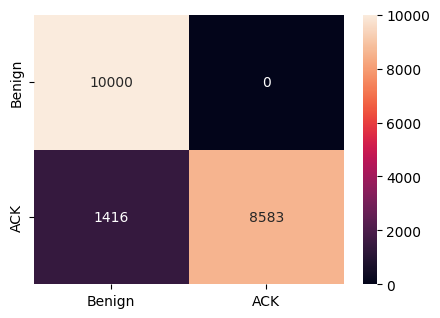





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           1    1     0  DT    0.994    0.994   0.994  0.994  0.994  0.988  0.994    0.016         0
 1  ACK           1    1     1  DT    0.5      0.5     0.25   0.5    0.333  0      0.5      0.016         0
 2  ACK           1    1     2  DT    0.998    0.998   0.998  0.998  0.998  0.996  0.998    0.016         0
 3  ACK           1    1     3  DT    0.5      0.5     0.25   0.5    0.333  0      0.5      0.01          0
 4  ACK           1    1     4  DT    0.5      0.5     0.25   0.5    0.333  0      0.5      0.016         0
 5  ACK           1    1     5  DT    0.5      0.5     0.25   0.5    0.333  0      0.5      0.018         0
 6  ACK           1    1     6  DT    0.994    0.994   0.994  0.994  0.994  0.988  0.994    0.016         0
 7  ACK           1    1

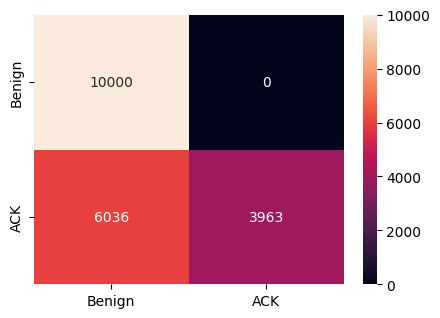





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           1    1     0  RF    0.994    0.994   0.994  0.994  0.994  0.988  0.994    3.746     0.205
 1  ACK           1    1     1  RF    0.994    0.994   0.994  0.994  0.994  0.988  0.994    3.743     0.204
 2  ACK           1    1     2  RF    0.994    0.994   0.994  0.994  0.994  0.988  0.994    3.875     0.205
 3  ACK           1    1     3  RF    0.994    0.994   0.994  0.994  0.994  0.988  0.994    3.663     0.22
 4  ACK           1    1     4  RF    0.994    0.994   0.994  0.994  0.994  0.988  0.994    3.635     0.22
 5  ACK           1    1     5  RF    0.994    0.994   0.994  0.994  0.994  0.988  0.994    3.958     0.204
 6  ACK           1    1     6  RF    0.994    0.994   0.994  0.994  0.994  0.988  0.994    3.853     0.189
 7  ACK           1    1  

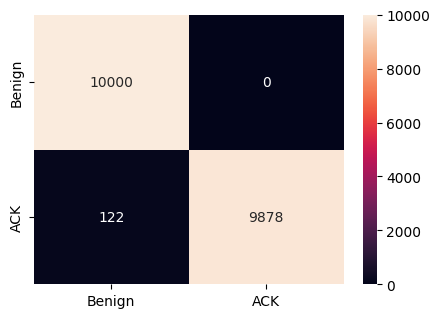





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  ACK           1    1     0  KNN   0.739    0.739   0.777  0.739  0.73  0.478  0.739    0.031     0.849
 1  ACK           1    1     1  KNN   0.739    0.739   0.777  0.739  0.73  0.478  0.739    0.016     1.114
 2  ACK           1    1     2  KNN   0.739    0.739   0.777  0.739  0.73  0.478  0.739    0.032     0.816
 3  ACK           1    1     3  KNN   0.739    0.739   0.777  0.739  0.73  0.478  0.739    0.016     0.834
 4  ACK           1    1     4  KNN   0.739    0.739   0.777  0.739  0.73  0.478  0.739    0.031     0.818
 5  ACK           1    1     5  KNN   0.739    0.739   0.777  0.739  0.73  0.478  0.739    0.031     0.786
 6  ACK           1    1     6  KNN   0.739    0.739   0.777  0.739  0.73  0.478  0.739    0.03      0.643
 7  ACK           1    1     7  K

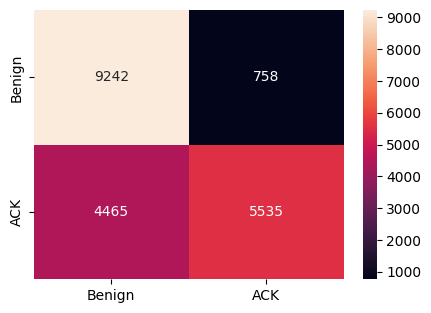





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           1    1     0  NB    0.737    0.737   0.828  0.737  0.718  0.475  0.737    0         0
 1  ACK           1    1     1  NB    0.737    0.737   0.828  0.737  0.718  0.475  0.737    0         0
 2  ACK           1    1     2  NB    0.737    0.737   0.828  0.737  0.718  0.475  0.737    0.016     0
 3  ACK           1    1     3  NB    0.737    0.737   0.828  0.737  0.718  0.475  0.737    0         0
 4  ACK           1    1     4  NB    0.737    0.737   0.828  0.737  0.718  0.475  0.737    0.009     0.003
 5  ACK           1    1     5  NB    0.737    0.737   0.828  0.737  0.718  0.475  0.737    0         0
 6  ACK           1    1     6  NB    0.737    0.737   0.828  0.737  0.718  0.475  0.737    0         0
 7  ACK           1    1     7  NB    0.737    0

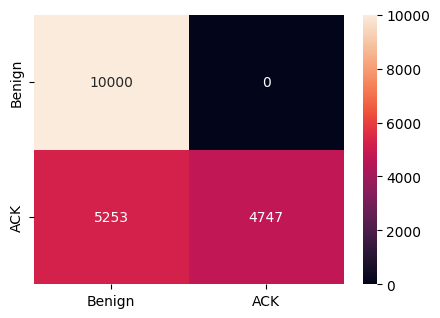





UDP
['IP_tos', 'IP_flags', 'IP_DF', 'IP_proto', 'TCP_dataofs', 'TCP_flags', 'TCP_ACK', 'TCP_window', 'TCP_options', 'sport_class', 'Protocol', 'ts_diff', 'ts_std_WE', 'TCP_window_mean_WE', 'TCP_window_std_WE', 'TCP_window_sum_of_EW', 'ts_mean_2', 'TCP_window_mean_2', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'sum', 'TCP_ACK_SR', 'ts_std_6', 'TCP_window_mean_6', 'entropy_std_6', 'ts_std_9', 'TCP_window_mean_9', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  LR     0.62     0.62   0.784   0.62  0.556   0.24   0.62    0.456     0
 1  UDP           1    1     1  LR     0.62     0.62   0.784   0.62  0.556   0.24   0.62    0.408     0.016
 2  UDP           1    1     2  LR     0.62     0.62   0.784   0.62  0.556   0.24   0.62    0.361     0
 3  UDP           1    1     3  LR  

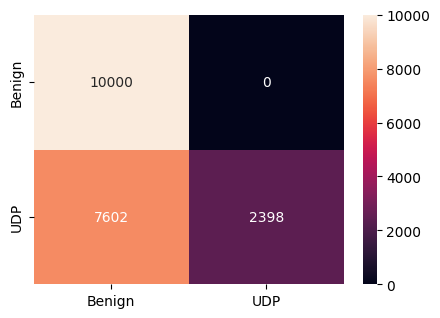





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  DT    0.62     0.62    0.784  0.62   0.556  0.24   0.62     0.05      0
 1  UDP           1    1     1  DT    0.62     0.62    0.784  0.62   0.556  0.24   0.62     0.048     0
 2  UDP           1    1     2  DT    0.62     0.62    0.784  0.62   0.556  0.24   0.62     0.047     0
 3  UDP           1    1     3  DT    0.889    0.889   0.907  0.889  0.888  0.778  0.889    0.079     0
 4  UDP           1    1     4  DT    0.62     0.62    0.784  0.62   0.556  0.24   0.62     0.046     0
 5  UDP           1    1     5  DT    0.62     0.62    0.784  0.62   0.556  0.24   0.62     0.046     0
 6  UDP           1    1     6  DT    0.62     0.62    0.784  0.62   0.556  0.24   0.62     0.032     0
 7  UDP           1    1     7  DT    0.62     0.62 

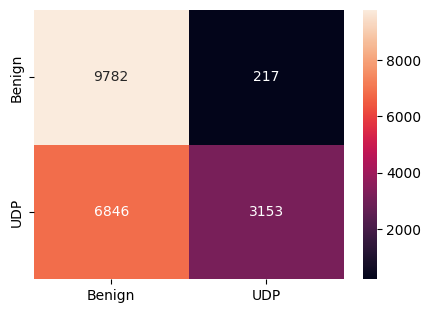





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  RF     0.62     0.62   0.784   0.62  0.556   0.24   0.62    5.865     0.351
 1  UDP           1    1     1  RF     0.62     0.62   0.784   0.62  0.556   0.24   0.62    5.666     0.298
 2  UDP           1    1     2  RF     0.62     0.62   0.784   0.62  0.556   0.24   0.62    5.745     0.299
 3  UDP           1    1     3  RF     0.62     0.62   0.784   0.62  0.556   0.24   0.62    5.399     0.277
 4  UDP           1    1     4  RF     0.62     0.62   0.784   0.62  0.556   0.24   0.62    5.613     0.286
 5  UDP           1    1     5  RF     0.62     0.62   0.784   0.62  0.556   0.24   0.62    5.357     0.298
 6  UDP           1    1     6  RF     0.62     0.62   0.784   0.62  0.556   0.24   0.62    5.713     0.314
 7  UDP           1    1

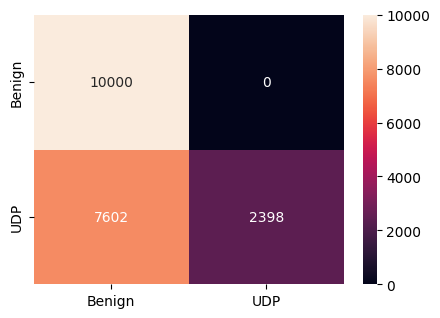





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  KNN   0.845    0.845   0.849  0.845  0.845   0.69  0.845    0.11      2.66
 1  UDP           1    1     1  KNN   0.845    0.845   0.849  0.845  0.845   0.69  0.845    0.138     2.669
 2  UDP           1    1     2  KNN   0.845    0.845   0.849  0.845  0.845   0.69  0.845    0.125     2.597
 3  UDP           1    1     3  KNN   0.845    0.845   0.849  0.845  0.845   0.69  0.845    0.112     2.795
 4  UDP           1    1     4  KNN   0.845    0.845   0.849  0.845  0.845   0.69  0.845    0.108     2.629
 5  UDP           1    1     5  KNN   0.845    0.845   0.849  0.845  0.845   0.69  0.845    0.11      2.652
 6  UDP           1    1     6  KNN   0.845    0.845   0.849  0.845  0.845   0.69  0.845    0.11      2.728
 7  UDP           1    1 

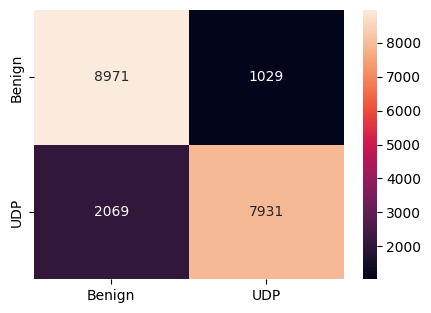





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  NB    0.897    0.897   0.914  0.897  0.896  0.794  0.897    0.015     0.022
 1  UDP           1    1     1  NB    0.897    0.897   0.914  0.897  0.896  0.794  0.897    0.016     0.022
 2  UDP           1    1     2  NB    0.897    0.897   0.914  0.897  0.896  0.794  0.897    0.014     0.018
 3  UDP           1    1     3  NB    0.897    0.897   0.914  0.897  0.896  0.794  0.897    0.017     0.021
 4  UDP           1    1     4  NB    0.897    0.897   0.914  0.897  0.896  0.794  0.897    0.016     0.021
 5  UDP           1    1     5  NB    0.897    0.897   0.914  0.897  0.896  0.794  0.897    0.019     0.02
 6  UDP           1    1     6  NB    0.897    0.897   0.914  0.897  0.896  0.794  0.897    0.017     0.019
 7  UDP           1    1 

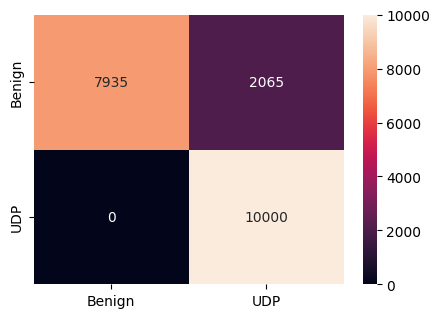





ARP
['ts', 'IP_version', 'IP_ihl', 'IP_tos', 'IP_DF', 'IP_ttl', 'IP_options', 'ICMP_code', 'TCP_reserved', 'TCP_flags', 'TCP_URG', 'TCP_ECE', 'TCP_CWR', 'TCP_urgptr', 'TCP_options', 'UDP_len', 'DNS_rd', 'DNS_qdcount', 'DNS_ancount', 'DNS_nscount', 'dport_class', 'entropy', 'dst_IP_diversity', 'pck_size_diff', 'pck_size_std_WE', 'ts_diff', 'payload_bytes_diff', 'payload_bytes_sum_of_EW', 'entropy_diff', 'entropy_mean_WE', 'entropy_std_WE', 'entropy_sum_of_EW', 'ts_mean_2', 'ts_std_2', 'payload_bytes_mean_2', 'payload_bytes_std_2', 'entropy_std_2', 'sport_sum', 'TCP_FIN_sum', 'TCP_SYN_sum', 'TCP_RST_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_RST_ratio', 'TCP_PSH_ratio', 'TCP_ACK_ratio', 'TCP_CWR_ratio', 'TCP_SYN_SR', 'TCP_PSH_SR', 'TCP_ECE_SR', 'TCP_CWR_SR', 'pck_size_std_6', 'ts_mean_6', 'ts_std_6', 'TCP_window_std_6', 'payload_bytes_mean_6', 'entropy_std_6', 'pck_size_std_9', 'ts_std_9', 'TCP_window_std_9', 'payload_bytes_mean_9', 'entropy_mean_9', 'entropy_std_9', 'Label']
    Dat

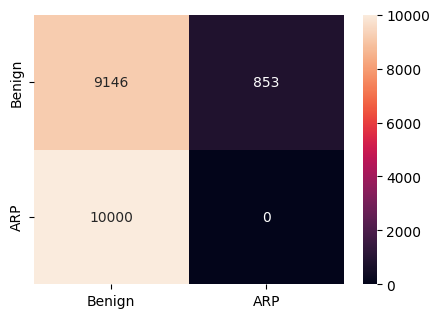





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ARP           1    1     0  DT    0.485    0.485   0.246  0.485  0.327  -0.029  0.485    0.391     0.006
 1  ARP           1    1     1  DT    0.445    0.445   0.235  0.445  0.308  -0.11   0.445    0.445     0.006
 2  ARP           1    1     2  DT    0.416    0.416   0.227  0.416  0.294  -0.167  0.416    0.537     0.006
 3  ARP           1    1     3  DT    0.499    0.499   0.496  0.499  0.395  -0.003  0.499    0.519     0.006
 4  ARP           1    1     4  DT    0.467    0.467   0.241  0.467  0.318  -0.066  0.467    0.504     0.006
 5  ARP           1    1     5  DT    0.483    0.483   0.246  0.483  0.325  -0.035  0.483    0.483     0.006
 6  ARP           1    1     6  DT    0.4      0.4     0.222  0.4    0.286  -0.199  0.4      0.355     0.004
 7  ARP        

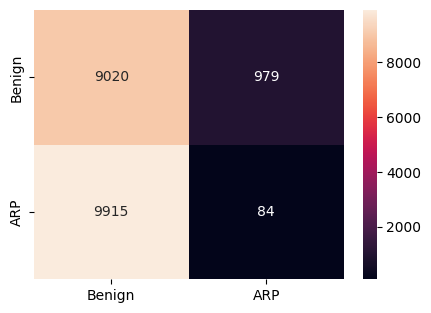





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ARP           1    1     0  RF    0.487    0.487   0.247  0.487  0.328  -0.026  0.487    4.078     0.284
 1  ARP           1    1     1  RF    0.492    0.492   0.248  0.492  0.33   -0.016  0.492    4.186     0.286
 2  ARP           1    1     2  RF    0.486    0.486   0.246  0.486  0.327  -0.028  0.486    4.069     0.256
 3  ARP           1    1     3  RF    0.489    0.489   0.247  0.489  0.328  -0.023  0.489    4.211     0.247
 4  ARP           1    1     4  RF    0.488    0.488   0.247  0.488  0.328  -0.023  0.488    4.133     0.258
 5  ARP           1    1     5  RF    0.489    0.489   0.247  0.489  0.328  -0.023  0.489    4.275     0.262
 6  ARP           1    1     6  RF    0.49     0.49    0.247  0.49   0.329  -0.02   0.49     4.15      0.278
 7  ARP        

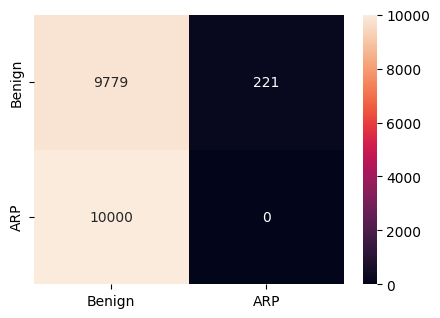





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ARP           1    1     0  KNN   0.448    0.448   0.237  0.448  0.309  -0.104  0.448    0.229     0.642
 1  ARP           1    1     1  KNN   0.448    0.448   0.237  0.448  0.309  -0.104  0.448    0.26      0.408
 2  ARP           1    1     2  KNN   0.448    0.448   0.237  0.448  0.309  -0.104  0.448    0.259     0.738
 3  ARP           1    1     3  KNN   0.448    0.448   0.237  0.448  0.309  -0.104  0.448    0.264     0.638
 4  ARP           1    1     4  KNN   0.448    0.448   0.237  0.448  0.309  -0.104  0.448    0.268     0.71
 5  ARP           1    1     5  KNN   0.448    0.448   0.237  0.448  0.309  -0.104  0.448    0.27      0.714
 6  ARP           1    1     6  KNN   0.448    0.448   0.237  0.448  0.309  -0.104  0.448    0.264     0.718
 7  ARP         

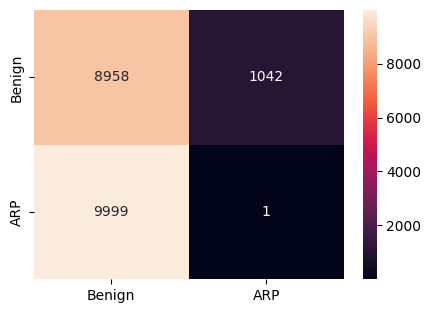





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ARP           1    1     0  NB    0.495    0.495   0.249  0.495  0.331  -0.009  0.495    0.035     0.052
 1  ARP           1    1     1  NB    0.495    0.495   0.249  0.495  0.331  -0.009  0.495    0.033     0.051
 2  ARP           1    1     2  NB    0.495    0.495   0.249  0.495  0.331  -0.009  0.495    0.035     0.052
 3  ARP           1    1     3  NB    0.495    0.495   0.249  0.495  0.331  -0.009  0.495    0.031     0.046
 4  ARP           1    1     4  NB    0.495    0.495   0.249  0.495  0.331  -0.009  0.495    0.033     0.05
 5  ARP           1    1     5  NB    0.495    0.495   0.249  0.495  0.331  -0.009  0.495    0.03      0.052
 6  ARP           1    1     6  NB    0.495    0.495   0.249  0.495  0.331  -0.009  0.495    0.032     0.051
 7  ARP         

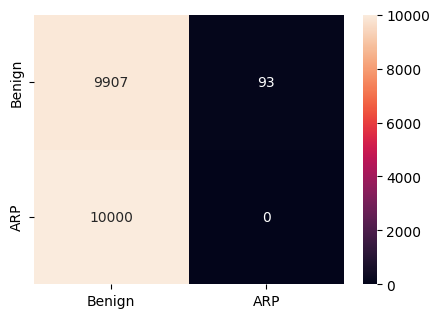





SP
['IP_flags', 'IP_DF', 'TCP_flags', 'TCP_SYN', 'TCP_ACK', 'dst_IP_diversity', 'entropy_std_WE', 'entropy_sum_of_EW', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'TCP_ACK_SR', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  SP            1    1     0  LR    0.516    0.475   0.267  0.475  0.341  -0.054  0.475    0.284     0.001
 1  SP            1    1     1  LR    0.516    0.475   0.267  0.475  0.341  -0.054  0.475    0.252     0.001
 2  SP            1    1     2  LR    0.516    0.475   0.267  0.475  0.341  -0.054  0.475    0.258     0.001
 3  SP            1    1     3  LR    0.516    0.475   0.267  0.475  0.341  -0.054  0.475    0.207     0
 4  SP            1    1     4  LR    0.516    0.475   0.267  0.475  0.341  -0.054  0.475    0.235     0.001
 5  SP            1    1     5  LR    0.516    0.475   0.267  0

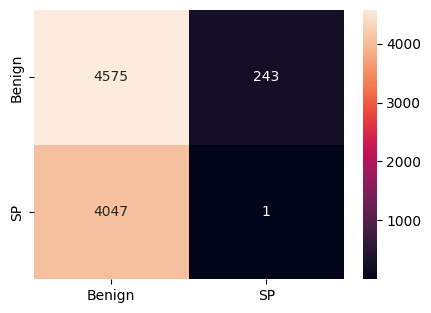





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  DT    0.995    0.996   0.995  0.996  0.995  0.991  0.996    0.014     0.001
 1  SP            1    1     1  DT    0.995    0.995   0.995  0.995  0.995  0.99   0.995    0.02      0
 2  SP            1    1     2  DT    0.995    0.995   0.995  0.995  0.995  0.99   0.995    0.024     0.001
 3  SP            1    1     3  DT    0.995    0.995   0.995  0.995  0.995  0.99   0.995    0.018     0.001
 4  SP            1    1     4  DT    0.753    0.73    0.84   0.73   0.722  0.48   0.73     0.021     0.001
 5  SP            1    1     5  DT    0.996    0.996   0.996  0.996  0.996  0.992  0.996    0.015     0.001
 6  SP            1    1     6  DT    0.752    0.729   0.838  0.729  0.722  0.478  0.729    0.016     0
 7  SP            1    1     7  

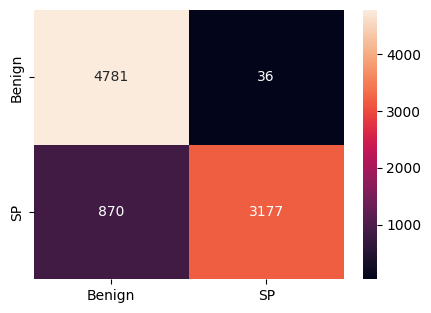





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  RF    0.969    0.966   0.972  0.966  0.968  0.937  0.966    0.447     0.049
 1  SP            1    1     1  RF    0.754    0.731   0.842  0.731  0.723  0.482  0.731    0.432     0.048
 2  SP            1    1     2  RF    0.754    0.731   0.842  0.731  0.724  0.482  0.731    0.451     0.026
 3  SP            1    1     3  RF    0.754    0.731   0.842  0.731  0.723  0.482  0.731    0.462     0.048
 4  SP            1    1     4  RF    0.754    0.731   0.842  0.731  0.723  0.482  0.731    0.432     0.049
 5  SP            1    1     5  RF    0.754    0.731   0.842  0.731  0.724  0.482  0.731    0.416     0.037
 6  SP            1    1     6  RF    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.412     0.047
 7  SP            1    1

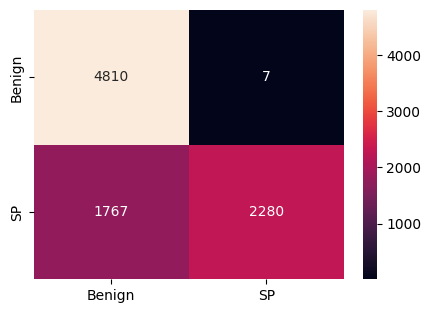





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  KNN   0.671    0.639   0.809  0.639  0.602  0.296  0.639    0.034     0.425
 1  SP            1    1     1  KNN   0.671    0.639   0.809  0.639  0.602  0.296  0.639    0.039     0.453
 2  SP            1    1     2  KNN   0.671    0.639   0.809  0.639  0.602  0.296  0.639    0.035     0.482
 3  SP            1    1     3  KNN   0.671    0.639   0.809  0.639  0.602  0.296  0.639    0.034     0.395
 4  SP            1    1     4  KNN   0.671    0.639   0.809  0.639  0.602  0.296  0.639    0.036     0.447
 5  SP            1    1     5  KNN   0.671    0.639   0.809  0.639  0.602  0.296  0.639    0.036     0.469
 6  SP            1    1     6  KNN   0.671    0.639   0.809  0.639  0.602  0.296  0.639    0.037     0.338
 7  SP            1    1

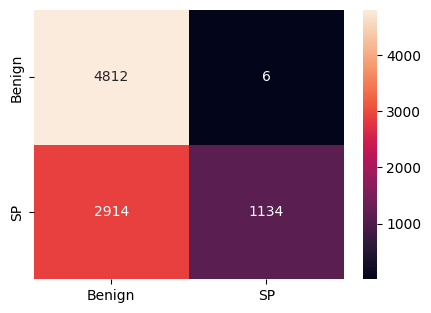





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  NB    0.859    0.849   0.878  0.849  0.854   0.71  0.849    0.004     0.002
 1  SP            1    1     1  NB    0.859    0.849   0.878  0.849  0.854   0.71  0.849    0.004     0.003
 2  SP            1    1     2  NB    0.859    0.849   0.878  0.849  0.854   0.71  0.849    0.005     0.001
 3  SP            1    1     3  NB    0.859    0.849   0.878  0.849  0.854   0.71  0.849    0.004     0.002
 4  SP            1    1     4  NB    0.859    0.849   0.878  0.849  0.854   0.71  0.849    0.004     0.002
 5  SP            1    1     5  NB    0.859    0.849   0.878  0.849  0.854   0.71  0.849    0.004     0.002
 6  SP            1    1     6  NB    0.859    0.849   0.878  0.849  0.854   0.71  0.849    0.004     0.002
 7  SP            1    1

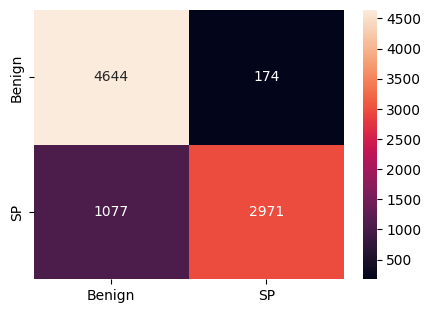





BF
['ts', 'TCP_window_sum_of_EW', 'entropy_mean_WE', 'pck_size_std_2', 'TCP_window_mean_2', 'TCP_window_std_2', 'payload_bytes_mean_2', 'sport_sum', 'TCP_FIN_sum', 'TCP_FIN_SR', 'pck_size_mean_6', 'pck_size_std_6', 'ts_std_6', 'TCP_window_mean_6', 'TCP_window_std_6', 'payload_bytes_mean_6', 'payload_bytes_std_6', 'ts_mean_9', 'ts_std_9', 'TCP_window_mean_9', 'TCP_window_std_9', 'payload_bytes_mean_9', 'payload_bytes_std_9', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  LR    0.475    0.518   0.732  0.518  0.351  0.032  0.518    0.063     0.001
 1  BF            1    1     1  LR    0.475    0.518   0.732  0.518  0.351  0.032  0.518    0.045     0.001
 2  BF            1    1     2  LR    0.475    0.518   0.732  0.518  0.351  0.032  0.518    0.033     0.001
 3  BF            1

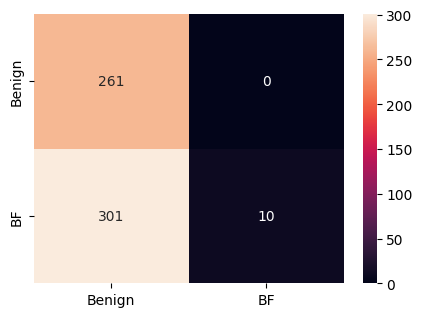





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  DT    0.455    0.5     0.228  0.5    0.313  0      0.5      0.047     0
 1  BF            1    1     1  DT    0.457    0.502   0.728  0.502  0.317  0.003  0.502    0.046     0
 2  BF            1    1     2  DT    0.459    0.503   0.729  0.503  0.32   0.006  0.503    0.047     0
 3  BF            1    1     3  DT    0.551    0.588   0.752  0.588  0.485  0.163  0.588    0.043     0
 4  BF            1    1     4  DT    0.466    0.51    0.73   0.51   0.334  0.018  0.51     0.055     0
 5  BF            1    1     5  DT    0.457    0.502   0.728  0.502  0.317  0.003  0.502    0.048     0
 6  BF            1    1     6  DT    0.455    0.5     0.228  0.5    0.313  0      0.5      0.042     0.001
 7  BF            1    1     7  DT    0.457    0

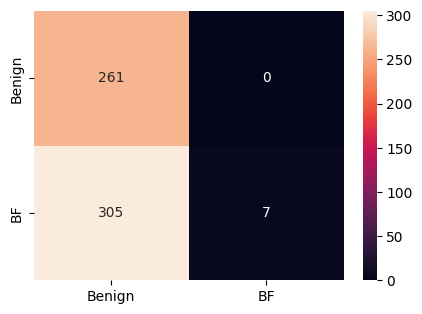





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  RF    0.457    0.502   0.728  0.502  0.317  0.003  0.502    2.389     0.029
 1  BF            1    1     1  RF    0.461    0.505   0.729  0.505  0.324  0.009  0.505    2.354     0.032
 2  BF            1    1     2  RF    0.461    0.505   0.729  0.505  0.324  0.009  0.505    2.289     0.031
 3  BF            1    1     3  RF    0.457    0.502   0.728  0.502  0.317  0.003  0.502    2.354     0.03
 4  BF            1    1     4  RF    0.457    0.502   0.728  0.502  0.317  0.003  0.502    2.289     0.031
 5  BF            1    1     5  RF    0.461    0.505   0.729  0.505  0.324  0.009  0.505    2.338     0.033
 6  BF            1    1     6  RF    0.457    0.502   0.728  0.502  0.317  0.003  0.502    2.382     0.029
 7  BF            1    1 

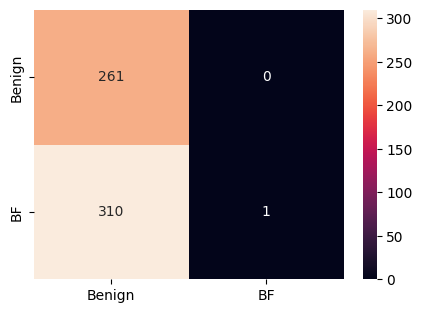





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  KNN   0.658    0.686   0.786  0.686  0.635   0.35  0.686    0.085     0.013
 1  BF            1    1     1  KNN   0.658    0.686   0.786  0.686  0.635   0.35  0.686    0.082     0.022
 2  BF            1    1     2  KNN   0.658    0.686   0.786  0.686  0.635   0.35  0.686    0.078     0.015
 3  BF            1    1     3  KNN   0.658    0.686   0.786  0.686  0.635   0.35  0.686    0.081     0.015
 4  BF            1    1     4  KNN   0.658    0.686   0.786  0.686  0.635   0.35  0.686    0.083     0.014
 5  BF            1    1     5  KNN   0.658    0.686   0.786  0.686  0.635   0.35  0.686    0.081     0.016
 6  BF            1    1     6  KNN   0.658    0.686   0.786  0.686  0.635   0.35  0.686    0.089     0.016
 7  BF            1    1

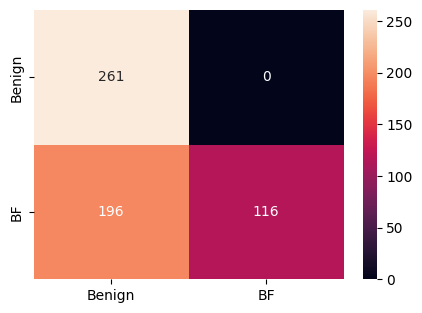





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  NB    0.805    0.818   0.836  0.818  0.803  0.617  0.818    0.005     0.001
 1  BF            1    1     1  NB    0.805    0.818   0.836  0.818  0.803  0.617  0.818    0.009     0.001
 2  BF            1    1     2  NB    0.805    0.818   0.836  0.818  0.803  0.617  0.818    0.008     0
 3  BF            1    1     3  NB    0.805    0.818   0.836  0.818  0.803  0.617  0.818    0.008     0
 4  BF            1    1     4  NB    0.805    0.818   0.836  0.818  0.803  0.617  0.818    0.008     0.001
 5  BF            1    1     5  NB    0.805    0.818   0.836  0.818  0.803  0.617  0.818    0.007     0
 6  BF            1    1     6  NB    0.805    0.818   0.836  0.818  0.803  0.617  0.818    0.008     0.001
 7  BF            1    1     7  NB  

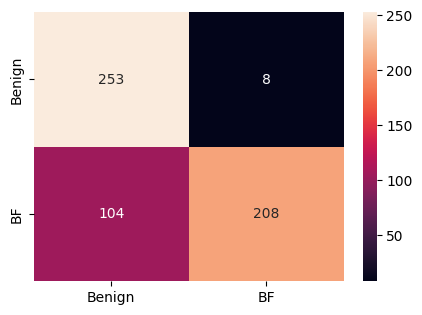





OS
['TCP_flags', 'TCP_SYN', 'TCP_ACK', 'TCP_URG', 'TCP_window', 'TCP_urgptr', 'UDP_len', 'entropy', 'Protocol', 'dst_port_diversity', 'pck_size_mean_WE', 'pck_size_std_WE', 'ts_diff', 'ts_std_WE', 'ts_sum_of_EW', 'TCP_window_std_WE', 'payload_bytes_diff', 'payload_bytes_mean_WE', 'payload_bytes_std_WE', 'entropy_mean_WE', 'entropy_std_WE', 'entropy_sum_of_EW', 'ts_mean_2', 'payload_bytes_std_2', 'dport_sum', 'TCP_SYN_sum', 'TCP_PSH_sum', 'TCP_ACK_sum', 'TCP_URG_sum', 'TCP_FIN_ratio', 'TCP_PSH_ratio', 'TCP_ACK_ratio', 'sum', 'TCP_FIN_SR', 'TCP_SYN_SR', 'TCP_PSH_SR', 'TCP_ACK_SR', 'TCP_URG_SR', 'TCP_ECE_SR', 'TCP_CWR_SR', 'pck_size_mean_6', 'pck_size_std_6', 'ts_mean_6', 'ts_std_6', 'payload_bytes_mean_6', 'entropy_mean_6', 'pck_size_mean_9', 'ts_mean_9', 'payload_bytes_mean_9', 'entropy_mean_9', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ---- 

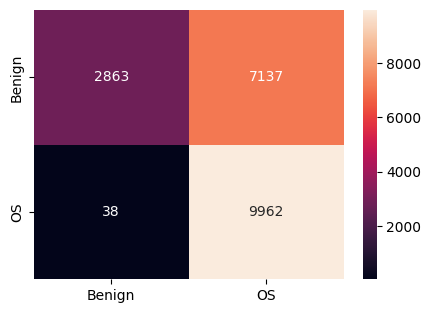





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            1    1     0  DT    0.755    0.755   0.821  0.755  0.741  0.51   0.755    0.037     0.006
 1  OS            1    1     1  DT    0.755    0.755   0.821  0.755  0.741  0.51   0.755    0.039     0.006
 2  OS            1    1     2  DT    0.731    0.731   0.789  0.731  0.717  0.462  0.731    0.043     0.006
 3  OS            1    1     3  DT    0.758    0.758   0.806  0.758  0.748  0.515  0.758    0.031     0.005
 4  OS            1    1     4  DT    0.755    0.755   0.821  0.755  0.741  0.51   0.755    0.037     0.007
 5  OS            1    1     5  DT    0.777    0.777   0.833  0.777  0.768  0.554  0.777    0.062     0.006
 6  OS            1    1     6  DT    0.773    0.773   0.817  0.773  0.765  0.546  0.773    0.057     0.005
 7  OS            1    1

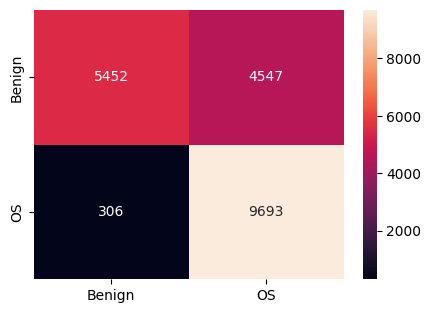





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            1    1     0  RF    0.768    0.768   0.812  0.768  0.759  0.535  0.768    0.263     0.053
 1  OS            1    1     1  RF    0.807    0.807   0.835  0.807  0.803  0.615  0.807    0.304     0.05
 2  OS            1    1     2  RF    0.77     0.77    0.813  0.77   0.762  0.541  0.77     0.29      0.051
 3  OS            1    1     3  RF    0.767    0.767   0.81   0.767  0.758  0.533  0.767    0.26      0.042
 4  OS            1    1     4  RF    0.579    0.579   0.696  0.579  0.505  0.158  0.579    0.364     0.056
 5  OS            1    1     5  RF    0.767    0.767   0.811  0.767  0.759  0.534  0.767    0.318     0.053
 6  OS            1    1     6  RF    0.76     0.76    0.808  0.76   0.751  0.52   0.76     0.283     0.052
 7  OS            1    1 

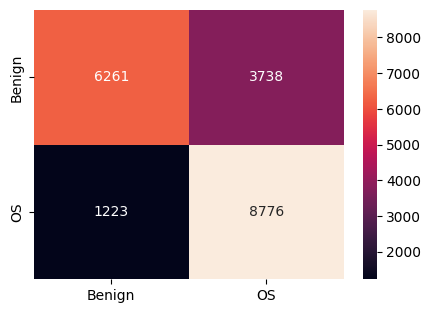





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  OS            1    1     0  KNN   0.495    0.495   0.258  0.495  0.331  -0.011  0.495    0.097     0.679
 1  OS            1    1     1  KNN   0.495    0.495   0.258  0.495  0.331  -0.011  0.495    0.092     0.731
 2  OS            1    1     2  KNN   0.495    0.495   0.258  0.495  0.331  -0.011  0.495    0.097     0.636
 3  OS            1    1     3  KNN   0.495    0.495   0.258  0.495  0.331  -0.011  0.495    0.085     0.688
 4  OS            1    1     4  KNN   0.495    0.495   0.258  0.495  0.331  -0.011  0.495    0.093     0.75
 5  OS            1    1     5  KNN   0.495    0.495   0.258  0.495  0.331  -0.011  0.495    0.094     0.522
 6  OS            1    1     6  KNN   0.495    0.495   0.258  0.495  0.331  -0.011  0.495    0.072     0.732
 7  OS          

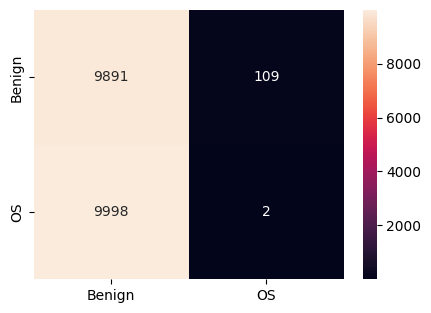





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            1    1     0  NB    0.574    0.574   0.699  0.574  0.494  0.147  0.574    0.014     0.036
 1  OS            1    1     1  NB    0.574    0.574   0.699  0.574  0.494  0.147  0.574    0.014     0.041
 2  OS            1    1     2  NB    0.574    0.574   0.699  0.574  0.494  0.147  0.574    0.011     0.039
 3  OS            1    1     3  NB    0.574    0.574   0.699  0.574  0.494  0.147  0.574    0.014     0.04
 4  OS            1    1     4  NB    0.574    0.574   0.699  0.574  0.494  0.147  0.574    0.011     0.039
 5  OS            1    1     5  NB    0.574    0.574   0.699  0.574  0.494  0.147  0.574    0.011     0.04
 6  OS            1    1     6  NB    0.574    0.574   0.699  0.574  0.494  0.147  0.574    0.014     0.04
 7  OS            1    1   

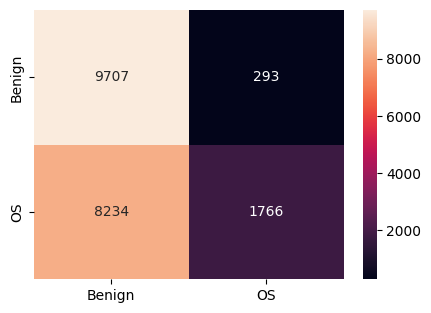





SCHD
['ts', 'Ether_type', 'IP_version', 'IP_ihl', 'TCP_dataofs', 'TCP_flags', 'TCP_ACK', 'TCP_options', 'sport_class', 'dport_class', 'pck_size_sum_of_EW', 'ts_mean_WE', 'ts_sum_of_EW', 'TCP_window_mean_WE', 'TCP_window_sum_of_EW', 'payload_bytes_mean_WE', 'payload_bytes_std_WE', 'payload_bytes_sum_of_EW', 'entropy_std_WE', 'TCP_PSH_sum', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'sum', 'pck_size_mean_6', 'ts_mean_6', 'ts_std_6', 'pck_size_mean_9', 'ts_mean_9', 'ts_std_9', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          1    1     0  LR    0.998    0.999   0.965  0.999  0.981  0.963  0.999    0.241     0.001
 1  SCHD          1    1     1  LR    0.998    0.999   0.965  0.999  0.981  0.963  0.999    0.208     0.001
 2  SCHD          1    1     2  LR    0.998    0.999   0.965  0.999  0.981  0.963  0.99

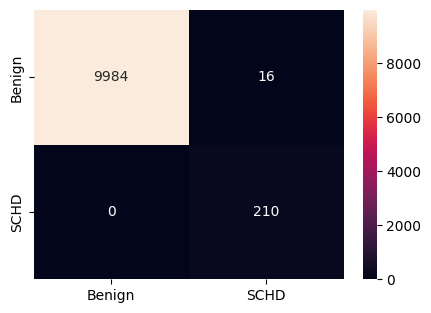





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          1    1     0  DT    0.998    0.999   0.951  0.999  0.973  0.947  0.999    0.022     0.002
 1  SCHD          1    1     1  DT    0.998    0.999   0.953  0.999  0.975  0.949  0.999    0.019     0.002
 2  SCHD          1    1     2  DT    0.998    0.999   0.965  0.999  0.981  0.963  0.999    0.019     0.002
 3  SCHD          1    1     3  DT    0.996    0.998   0.913  0.998  0.951  0.903  0.998    0.025     0.002
 4  SCHD          1    1     4  DT    0.998    0.999   0.965  0.999  0.981  0.963  0.999    0.02      0.002
 5  SCHD          1    1     5  DT    0.998    0.999   0.953  0.999  0.975  0.949  0.999    0.013     0.001
 6  SCHD          1    1     6  DT    0.998    0.999   0.965  0.999  0.981  0.963  0.999    0.027     0.003
 7  SCHD          1    1

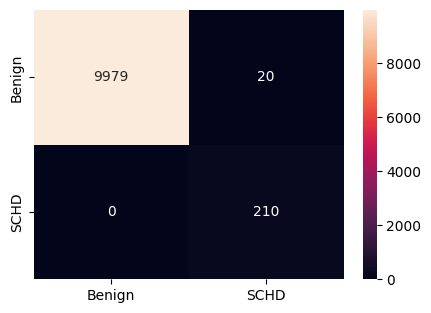





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          1    1     0  RF    0.984    0.619   0.955  0.619  0.685  0.374  0.619    1.113     0.053
 1  SCHD          1    1     1  RF    0.984    0.619   0.955  0.619  0.685  0.374  0.619    1.09      0.08
 2  SCHD          1    1     2  RF    0.984    0.619   0.955  0.619  0.685  0.374  0.619    1.061     0.077
 3  SCHD          1    1     3  RF    0.984    0.619   0.955  0.619  0.685  0.374  0.619    1.075     0.093
 4  SCHD          1    1     4  RF    0.984    0.619   0.947  0.619  0.685  0.372  0.619    1.062     0.08
 5  SCHD          1    1     5  RF    0.984    0.619   0.955  0.619  0.685  0.374  0.619    1.081     0.075
 6  SCHD          1    1     6  RF    0.984    0.619   0.955  0.619  0.685  0.374  0.619    1.085     0.082
 7  SCHD          1    1  

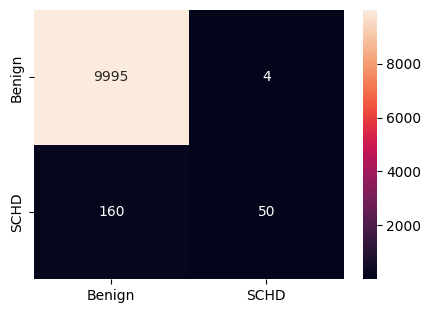





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SCHD          1    1     0  KNN   0.991    0.802   0.949  0.802  0.86  0.721  0.802    0.058     0.743
 1  SCHD          1    1     1  KNN   0.991    0.802   0.949  0.802  0.86  0.721  0.802    0.055     0.749
 2  SCHD          1    1     2  KNN   0.991    0.802   0.949  0.802  0.86  0.721  0.802    0.055     0.682
 3  SCHD          1    1     3  KNN   0.991    0.802   0.949  0.802  0.86  0.721  0.802    0.063     0.573
 4  SCHD          1    1     4  KNN   0.991    0.802   0.949  0.802  0.86  0.721  0.802    0.056     0.505
 5  SCHD          1    1     5  KNN   0.991    0.802   0.949  0.802  0.86  0.721  0.802    0.056     0.768
 6  SCHD          1    1     6  KNN   0.991    0.802   0.949  0.802  0.86  0.721  0.802    0.054     0.73
 7  SCHD          1    1     7  KN

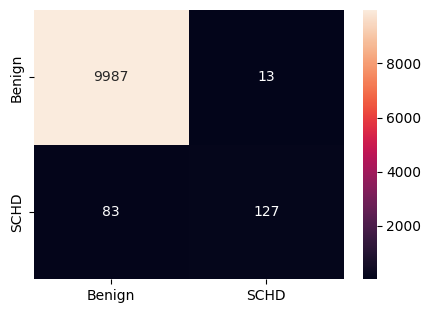





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          1    1     0  NB    0.985    0.983   0.788  0.983  0.859  0.718  0.983    0.007     0.008
 1  SCHD          1    1     1  NB    0.985    0.983   0.788  0.983  0.859  0.718  0.983    0.008     0.008
 2  SCHD          1    1     2  NB    0.985    0.983   0.788  0.983  0.859  0.718  0.983    0.007     0.008
 3  SCHD          1    1     3  NB    0.985    0.983   0.788  0.983  0.859  0.718  0.983    0.005     0.006
 4  SCHD          1    1     4  NB    0.985    0.983   0.788  0.983  0.859  0.718  0.983    0.006     0.009
 5  SCHD          1    1     5  NB    0.985    0.983   0.788  0.983  0.859  0.718  0.983    0.007     0.008
 6  SCHD          1    1     6  NB    0.985    0.983   0.788  0.983  0.859  0.718  0.983    0.007     0.01
 7  SCHD          1    1 

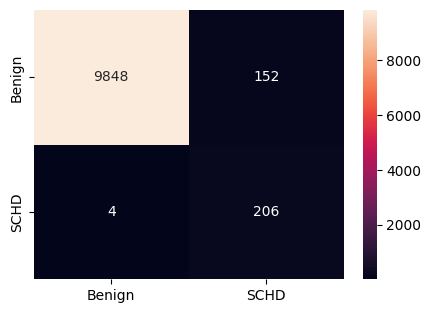





MHDis
['ts', 'IP_version', 'IP_flags', 'IP_proto', 'TCP_dataofs', 'TCP_options', 'sport_class', 'dport_class', 'Protocol', 'pck_size_mean_WE', 'pck_size_std_WE', 'ts_mean_WE', 'ts_sum_of_EW', 'TCP_window_sum_of_EW', 'ts_mean_2', 'ts_std_2', 'pck_size_mean_6', 'ts_mean_6', 'pck_size_mean_9', 'ts_mean_9', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         1    1     0  LR        1        1   0.996      1  0.998  0.996      1    0.218     0.001
 1  MHDis         1    1     1  LR        1        1   0.996      1  0.998  0.996      1    0.264     0
 2  MHDis         1    1     2  LR        1        1   0.996      1  0.998  0.996      1    0.245     0.001
 3  MHDis         1    1     3  LR        1        1   0.996      1  0.998  0.996      1    0.24      0.001
 4  MHDis         1    1     4  LR    

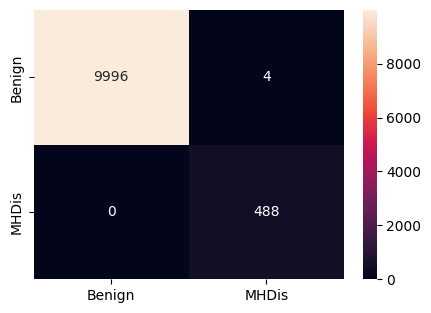





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         1    1     0  DT    0.998    0.974   0.998  0.974  0.986  0.971  0.974    0.028     0.001
 1  MHDis         1    1     1  DT    0.998    0.977   0.998  0.977  0.987  0.975  0.977    0.027     0.001
 2  MHDis         1    1     2  DT    0.998    0.974   0.998  0.974  0.986  0.971  0.974    0.028     0.002
 3  MHDis         1    1     3  DT    0.998    0.974   0.998  0.974  0.986  0.971  0.974    0.027     0.001
 4  MHDis         1    1     4  DT    0.998    0.974   0.998  0.974  0.986  0.971  0.974    0.027     0.001
 5  MHDis         1    1     5  DT    0.998    0.977   0.998  0.977  0.987  0.975  0.977    0.028     0.001
 6  MHDis         1    1     6  DT    0.998    0.977   0.998  0.977  0.987  0.975  0.977    0.024     0.001
 7  MHDis         1    1

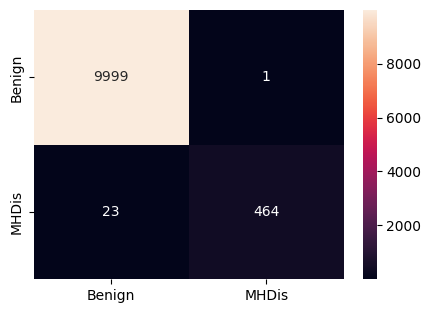





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         1    1     0  RF    0.998    0.976   0.998  0.976  0.987  0.974  0.976    0.576     0.057
 1  MHDis         1    1     1  RF    0.998    0.976   0.998  0.976  0.987  0.974  0.976    0.555     0.057
 2  MHDis         1    1     2  RF    0.998    0.977   0.998  0.977  0.987  0.975  0.977    0.586     0.063
 3  MHDis         1    1     3  RF    0.998    0.976   0.998  0.976  0.987  0.974  0.976    0.556     0.055
 4  MHDis         1    1     4  RF    0.998    0.976   0.998  0.976  0.987  0.974  0.976    0.519     0.055
 5  MHDis         1    1     5  RF    0.998    0.976   0.998  0.976  0.987  0.974  0.976    0.525     0.054
 6  MHDis         1    1     6  RF    0.998    0.976   0.998  0.976  0.987  0.974  0.976    0.57      0.059
 7  MHDis         1    1

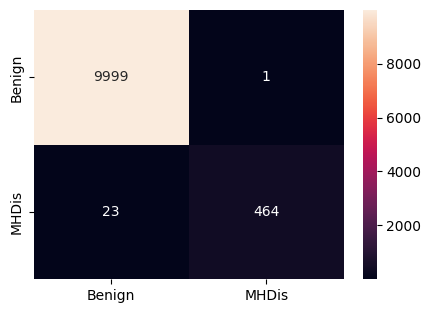





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         1    1     0  KNN   0.999    0.999   0.988  0.999  0.994  0.987  0.999    0.036     0.036
 1  MHDis         1    1     1  KNN   0.999    0.999   0.988  0.999  0.994  0.987  0.999    0.037     0.037
 2  MHDis         1    1     2  KNN   0.999    0.999   0.988  0.999  0.994  0.987  0.999    0.035     0.035
 3  MHDis         1    1     3  KNN   0.999    0.999   0.988  0.999  0.994  0.987  0.999    0.032     0.036
 4  MHDis         1    1     4  KNN   0.999    0.999   0.988  0.999  0.994  0.987  0.999    0.031     0.035
 5  MHDis         1    1     5  KNN   0.999    0.999   0.988  0.999  0.994  0.987  0.999    0.041     0.038
 6  MHDis         1    1     6  KNN   0.999    0.999   0.988  0.999  0.994  0.987  0.999    0.035     0.036
 7  MHDis         1    1

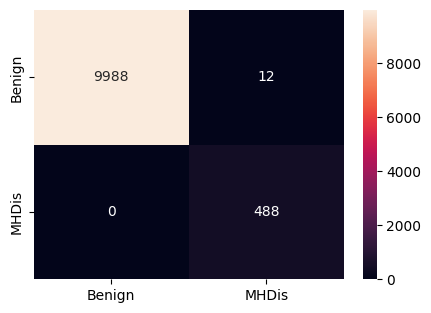





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         1    1     0  NB    0.916    0.956   0.678  0.956  0.739   0.49  0.956    0.006     0.006
 1  MHDis         1    1     1  NB    0.916    0.956   0.678  0.956  0.739   0.49  0.956    0.005     0.006
 2  MHDis         1    1     2  NB    0.916    0.956   0.678  0.956  0.739   0.49  0.956    0.007     0.008
 3  MHDis         1    1     3  NB    0.916    0.956   0.678  0.956  0.739   0.49  0.956    0.006     0.006
 4  MHDis         1    1     4  NB    0.916    0.956   0.678  0.956  0.739   0.49  0.956    0.006     0.006
 5  MHDis         1    1     5  NB    0.916    0.956   0.678  0.956  0.739   0.49  0.956    0.006     0.006
 6  MHDis         1    1     6  NB    0.916    0.956   0.678  0.956  0.739   0.49  0.956    0.006     0.006
 7  MHDis         1    1

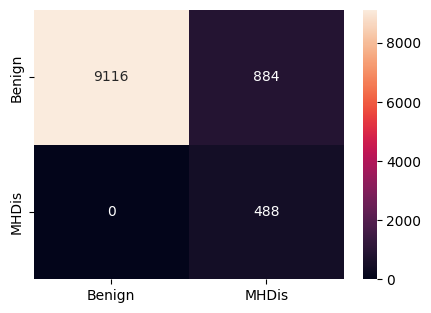

In [24]:
folder("results/test/")

for file in file_list:
    print(file)
    #if "UDP" in file:        feature=feature_list["UDP"]
    #else:        feature=feature_list[file]
    feature=feature_list[file]
    train=file_list[file][0]
    test=file_list[file][1]
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/test/{file}_TEST_chosed_output_ML_.csv"
    target_names=["Benign",file]
    ML(train,test,output_csv,feature,file,1)  


In [25]:
files_add=find_the_way("./results/test/","_.csv")
files_add

results=[['Attack', 'ML','Acc', 'b_Acc', 'Prec', 'Rec',
       'F1', 'kap', 'ROC', 'tra-T', 'test-T']]


    
for i in tqdm(files_add):
    df=pd.read_csv(i)
    temp=df.values
    df=df.mean()
    df=list(df.values)
    temp=[temp[0][0],temp[0][4]]
    temp=temp+df[3:]
    results.append(temp)
results = pd.DataFrame (results[1:], columns = results[0])
results.to_csv("MEAN-resluts.csv",index=False)
print (tabulate(results, headers=list(results.columns)))

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 355.26it/s]

    Attack    ML         Acc     b_Acc      Prec       Rec        F1          kap       ROC        tra-T       test-T
--  --------  ----  --------  --------  --------  --------  --------  -----------  --------  -----------  -----------
 0  ACK       DT    0.69818   0.69818   0.548199  0.69818   0.59818    0.39636     0.69818    0.0168586   0
 1  ACK       KNN   0.73885   0.73885   0.776901  0.73885   0.729559   0.4777      0.73885    0.0264435   0.827751
 2  ACK       LR    0.929155  0.929155  0.941042  0.929155  0.928246   0.85831     0.929155  16.0032      0.000936437
 3  ACK       NB    0.73735   0.73735   0.827804  0.73735   0.717889   0.4747      0.73735    0.00315399  0.00342581
 4  ACK       RF    0.9939    0.9939    0.993974  0.9939    0.9939     0.9878      0.9939     3.73215     0.206992
 5  ARP       DT    0.45522   0.45522   0.262589  0.45522   0.318677  -0.08956     0.45522    0.468009    0.00562358
 6  ARP       KNN   0.44795   0.44795   0.236751  0.44795   0.309446  -0.1

In [26]:
df=pd.read_csv("MEAN-resluts.csv")
bos=pd.DataFrame()
for i in df["Attack"].unique():
    small=df[df["Attack"]==i]
    bos[i]=small["F1"].values
    print(i)
bos.to_csv("tablo.csv",index=False)

ACK
ARP
BF
HTTP
MHDis
OS
SCHD
SP
SYN
UDP
